In [1]:
%%capture
#from jupyterthemes import jtplot
#jtplot.style()
import numpy as np
import operator
import seaborn as sns; sns.set()
from landlab import FieldError
from landlab.utils import get_watershed_mask
import xarray as xr
import pandas as pd
import scipy
import gdal
from scipy import ndimage
from scipy.ndimage.filters import *
import os
import math
from osgeo import osr
from fractions import Fraction
import timeit
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
#import matplotlib.image as mpimg
%matplotlib inline
import random
# import plotting tools
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import matplotlib as mpl
from landlab.plot.imshow import imshow_grid 

# import necessary landlab components
from landlab import RasterModelGrid, HexModelGrid
from landlab.components import FlowAccumulator, LakeMapperBarnes, SinkFillerBarnes
from landlab.components import(FlowDirectorD8, 
                               FlowDirectorDINF, 
                               FlowDirectorMFD, 
                               FlowDirectorSteepest)
from landlab.components import DepressionFinderAndRouter
# import landlab plotting functionality
from landlab.plot.drainage_plot import drainage_plot
from pylab import show, figure
from scipy.ndimage import gaussian_filter
from statsmodels.formula.api import ols
from scipy.stats import t
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from landlab.utils.flow__distance import calculate_flow__distance
from landlab.utils import watershed
from scipy.odr import *

In [2]:
def rectangleWindow(m, n):
    """Takes a value for number of rows (m) and number of columns (n) such that
       m and n are both positive real numbers and creates a rectangle of 
       boolian 'True' values."""
    rectangle = np.ones((m, n), dtype=bool) 
    return rectangle
def PCTL(x):
    """This function only works as an inside function to generic_filter function below. This
       is because generic_filter will take a 2d array and reshape it into a 1d array. Without this 
       step the 'central_value' variable will be outside of the array dimensions. 
       x = input DEM and r = radius of search window """
    centroid = x[central_value]                        
    y = np.sum(x < centroid)/num_values#Count number of values greater than centroid value
    return y
def number_of_values(Window):
    """This funciton takes the shape function as an input and returns a number 
        of values present in the specified shape. 
        
        This can be different for a different window shape and to initialize
        requires the specification of the function for the given window type and 
        parameter values required for that input function.
        
        To initialize this function for shape == rectangle type 'number_of_values(rectangleWindow(m,n)) 
        where m and n are any positive real number as per the rectangleWindow function."""
    denominator = sum(sum(Window > 0))
    return denominator
def slopeWindow(DEM_slope, x_cellsize, y_cellsize):
    """This function implements slope calculation using the same algorithm
       as ARCGIS (Outlined on the page 'How Slope Works').
       This particular example of the function is written such that it
       will only work if called within the ndimage generic_filter (as the first input).
       This is because the index arguments for a-e are given for the 1d array created
       by the generic_filter function after extracting values from the 3,3 rectangle window.
       NOTE: THIS FUNCTION ONLY WORKS WITH A 3x3 RECTANGLE WINDOW."""
    a = DEM_slope[0]; b = DEM_slope[1]; c = DEM_slope[2]
    d = DEM_slope[3]; e = DEM_slope[4]; f = DEM_slope[5]
    g = DEM_slope[6]; h = DEM_slope[7]; i = DEM_slope[8]
    dzdx = ((c + (2*f) + i) - (a + (2*d) + g)) / (8 * x_cellsize)
    dzdy = ((g + (2*h) + i) - (a + (2*b) + c)) / (8 * y_cellsize)
    rise_run = np.sqrt(dzdx**2 + dzdy**2)
    slope_degrees = np.arctan(rise_run) * (180/math.pi)
    slope_percent = rise_run * 100
    #Can also ask it to return slope_degrees but askinh for both causes it to throw and error.
    return slope_percent
def slopeWindowDegrees(DEM, x_cellsize, y_cellsize):
    """This function implements slope calculation using the same algorithm
       as ARCGIS (Outlined on the page 'How Slope Works').
       This particular example of the function is written such that it
       will only work if called within the ndimage generic_filter (as the first input).
       This is because the index arguments for a-e are given for the 1d array created
       by the generic_filter function after extracting values from the 3,3 rectangle window.
       NOTE: THIS FUNCTION ONLY WORKS WITH A 3x3 RECTANGLE WINDOW."""
    a = DEM[0]; b = DEM[1]; c = DEM[2]
    d = DEM[3]; e = DEM[4]; f = DEM[5]
    g = DEM[6]; h = DEM[7]; i = DEM[8]
    dzdx = ((c + (2*f) + i) - (a + (2*d) + g)) / (8 * x_cellsize)
    dzdy = ((g + (2*h) + i) - (a + (2*b) + c)) / (8 * y_cellsize)
    rise_run = np.sqrt(dzdx**2 + dzdy**2)
    slope_degrees = np.arctan(rise_run) * (180/math.pi)
    slope_percent = rise_run * 100
    #Can also ask it to return slope_degrees but asking for both causes it to throw and error.
    return slope_degrees
def slopeWindowMperM(DEM, x_cellsize, y_cellsize):
    """This function implements slope calculation using the same algorithm
       as ARCGIS (Outlined on the page 'How Slope Works').
       This particular example of the function is written such that it
       will only work if called within the ndimage generic_filter (as the first input).
       This is because the index arguments for a-e are given for the 1d array created
       by the generic_filter function after extracting values from the 3,3 rectangle window.
       NOTE: THIS FUNCTION ONLY WORKS WITH A 3x3 RECTANGLE WINDOW."""
    a = DEM[0]; b = DEM[1]; c = DEM[2]
    d = DEM[3]; e = DEM[4]; f = DEM[5]
    g = DEM[6]; h = DEM[7]; i = DEM[8]
    dzdx = ((c + (2*f) + i) - (a + (2*d) + g)) / (8 * x_cellsize)
    dzdy = ((g + (2*h) + i) - (a + (2*b) + c)) / (8 * y_cellsize)
    rise_run = np.sqrt(dzdx**2 + dzdy**2)
    slope_degrees = np.arctan(rise_run) * (180/math.pi)
    slope_m_per_m = rise_run
    #Can also ask it to return slope_degrees but asking for both causes it to throw and error.
    return slope_m_per_m
def planCurvature(DEM, cellsize):
    """This process is taken from Change (2014, Introduction to Geographic Information
    systems, Page 284)."""
    Z1 = DEM[0]; Z2 = DEM[1]; Z3 = DEM[2]
    Z4 = DEM[3]; Z0 = DEM[4]; Z5 = DEM[5]
    Z6 = DEM[6]; Z7 = DEM[7]; Z8 = DEM[8]
    D = (((Z4 + Z5)/2) - Z0) / cellsize**2
    E = (((Z2 + Z7)/2) - Z0) / cellsize**2
    F = (Z3 - Z1 + Z6 - Z8)/ (4 * cellsize**2)
    G = (Z5 - Z4) / (2 * cellsize)
    H = (Z2 - Z7) / (2 * cellsize)
    plan_curvature = 2 * ((D*H**2 + E*G**2 - F*G*H) / (G**2 + H**2))
    return plan_curvature
def profileCurvature(DEM, cellsize):
    """This process is taken from Change (2014, Introduction to Geographic Information
       systems, Page 284)."""
    Z1 = DEM[0]; Z2 = DEM[1]; Z3 = DEM[2]
    Z4 = DEM[3]; Z0 = DEM[4]; Z5 = DEM[5]
    Z6 = DEM[6]; Z7 = DEM[7]; Z8 = DEM[8]
    D = (((Z4 + Z5)/2) - Z0) / cellsize**2
    E = (((Z2 + Z7)/2) - Z0) / cellsize**2
    F = (Z3 - Z1 + Z6 - Z8)/ (4 * cellsize**2)
    G = (Z5 - Z4) / (2 * cellsize)
    H = (Z2 - Z7) / (2 * cellsize)
    profile_curvature = -2 * (D*G**2 + E*H**2 + F*G*H) / (G**2 + H**2)
    return profile_curvature
def circleWindow(radius):
    """Takes a value for radius (r where r is any positive real number) and creates 
       a circular window using that radius."""
    y, x = np.ogrid[-radius: radius + 1, -radius: radius + 1]
    circle = x**2 + y**2 <= radius**2
    return circle
def find_median_value(Window):
    """This function takes the shape function and returns the median value 
        for all valid values (values that fall in the circle) arranged into a 
        1d array. The function also takes the number_of_values function as an input.
        To execute this function type 'find_median_value(shape(r)) where r is any integer.
        #Note: using median like this only gives the correct value for circles with odd 
        radius values."""
    no_values = number_of_values(Window)
    value_range = np.arange(0, no_values + 1)
    central_value = int(np.median(value_range))
    return central_value
def differenceFromMeanElevation(elev):
    """This function only works as an inside function to generic_filter function below. This
       is because generic_filter will take a 2d array and reshape it into a 1d array. Without this 
       step the 'central_value' variable will be outside of the array dimensions. 
       x = input DEM and r = radius of search window """
    centroid = elev[central_value]                        
    mean = np.nanmean(elev)#Count number of values greater than centroid value
    diff = centroid - mean
    return diff
def ghFilter(gully_heads):
    """Reduce the number of candidate initial gully heads. The window size is custimizable through the 
    'footprint' argument. """
    surrounding_nodes_list = [];
    for i in range(0, num_values):
        if i != central_value:
            surrounding_nodes_list.append(gully_heads[i])
    
    surrounding_nodes_array = np.array(surrounding_nodes_list)
    non_zero_values = surrounding_nodes_array[surrounding_nodes_array > 0]
    if non_zero_values.size == 0:
        new_value = 0  
    else:
        if gully_heads[central_value] > 0 and np.min(non_zero_values) > gully_heads[central_value]:
            new_value = 1
        else:
            new_value = 0

    return new_value
def roundup(x):
    return int(math.ceil(x / 10.0)) * 10
def catchmentDicts(area_grid, gn, gh_nodes):
    """Creates a dictionary of node ID:catcment area values."""
    area_dict = {}
    nodes = gh_nodes
    x_axis_length = gn.shape[1]
    for i in nodes:
        row = int(np.floor(i / x_axis_length))
        col = int(i - (row*x_axis_length))
        area = area_grid[row,col]
        area_dict[i] = area
    return area_dict
def upslopeDivergence(catchment_area_list, change_detection_factor, step_size, comparison_distance):
    
    """"Looks at whether catchment area is increasing at any point upstream of a gully head.
    
    - 'catchment_area_list' is an ordered list of node catchment areas moving upstream.
    
    - 'change_detection_factor' is the percentage increase required for the function to consider the change
    to represent a point of divergent flow.
    
    - 'step_size' is the number of grid cells to be compared in downstream to upstream groups. E.g. step_size == 1 
    will compare node 1 and node 2, but step_size == 2 will compare node 1 and 2 to node 3 and 4.
    
    - 'comparison_distance' is the distance between the downstream nodes being compared to upstream nodes."""
    
    max_value_length = len(catchment_area_list) - step_size - comparison_distance - step_size
    for i in range(0, max_value_length):
                
        start_of_downstream_nodes = i
        end_of_downstream_nodes = i + step_size       
        downstream_nodes = catchment_area_list[start_of_downstream_nodes:end_of_downstream_nodes]
        
        start_of_upstream_nodes = i + step_size + comparison_distance
        end_of_usptreat_nodes = start_of_upstream_nodes + step_size
        upstream_nodes = catchment_area_list[start_of_upstream_nodes:end_of_usptreat_nodes]
        
        required_catchment_area_increase = max(downstream_nodes) + (max(downstream_nodes) * change_detection_factor)
        
        if all(nodes >= required_catchment_area_increase for nodes in upstream_nodes):
            divergence = 1
            break
        else:
            divergence = 0
    return divergence
def findGullyHeadNode(gully_heads, grid_nodes, DEM, ca, input_DEM_resolution, 
                      distance_from_node, contributing_fraction, required_ca):
    
    catchment_area_dict = {}
    catchment_area_node_list = []
    distance_from_node = int(np.ceil(distance_from_node/input_DEM_resolution))

    for i in gully_heads:

        result = np.where(grid_nodes == i)
        #################################################################################################
        # Find the index position (in the whole DEM) that corresponds to the current gully head point in the list.
        row_index = result[0][0];
        col_index = result[1][0];
        #################################################################################################
        # Create a subset based on above. Plus 1 to bottom abnd right so that the currenmmt gully ead node is always the 
        # centraL grid node of the subset.
        subset_row_top = int(row_index - distance_from_node)
        subset_row_bot = int(row_index + distance_from_node) + 1
        subset_col_left = int(col_index - distance_from_node)
        subset_col_right = int(col_index + distance_from_node) + 1
        #################################################################################################
        # Restrict the size of the subset in cases where it is on the edge of a DEM.
        subset_row_top_adjusted = max(subset_row_top, 0);
        subset_row_bot_adjusted = min(subset_row_bot, DEM.shape[0]);
        subset_col_left_adjusted = max(subset_col_left, 0);
        subset_col_right_adjusted = min(subset_col_right, DEM.shape[1]);
        #################################################################################################
        # Find the offset required by restricting the size of the subset around DEM edges.
        # This offset is needed to find the new location of the current gully head grid cell (no longer center of the subset).
        offset_row_top = int(np.sqrt((subset_row_top - subset_row_top_adjusted)**2)) * -1;
        offset_row_bot = int(np.sqrt((subset_row_bot - subset_row_bot_adjusted)**2));
        offset_col_left = int(np.sqrt((subset_col_left - subset_col_left_adjusted)**2)) * -1;
        offset_col_right = int(np.sqrt((subset_col_right - subset_col_right_adjusted)**2));
        #################################################################################################
        # Create subset around the current gully head grid node. 
        dem_subset = DEM[subset_row_top_adjusted:subset_row_bot_adjusted, 
                                     subset_col_left_adjusted:subset_col_right_adjusted]

        #################################################################################################
        ca_subset = ca[subset_row_top_adjusted:subset_row_bot_adjusted, 
                             subset_col_left_adjusted:subset_col_right_adjusted]
        print('max ca: ', np.amax(ca_subset))
        #################################################################################################
        # Find the latitude and longitude index positions of the gully head node in the subset DEM.
        node_lat = distance_from_node + offset_row_top
        node_lon = distance_from_node + offset_col_left
        #################################################################################################  
        # Run M8 for the subset DEM.
        flow_acc_surf_sub = np.copy(dem_subset).astype('float64');

        rows_sub = flow_acc_surf_sub.shape[0];
        cols_sub = flow_acc_surf_sub.shape[1];
        mg1 = RasterModelGrid((rows_sub,cols_sub), 1);
        z1 = mg1.add_field('topographic__elevation', flow_acc_surf_sub, at = 'node');
        sfb = SinkFillerBarnes(mg1, method = 'Steepest', ignore_overfill = True);
        sfb.run_one_step();
        fa = FlowAccumulator(mg1,
                            surface = 'topographic__elevation',
                            flow_director = 'FlowDirectorMFD',
                            diagonals = True);
        fa.run_one_step()
        fd = FlowDirectorMFD(mg1, 'topographic__elevation', diagonals = True);
        fd.run_one_step()
        #################################################################################################
        # Extract required grid properties
        da = np.array(mg1.at_node['drainage_area'].round(4)); # Drainage area.
        frn = mg1.at_node['flow__receiver_node'];# Flow receiver nodes.
        drainage_area = da.reshape(mg1.shape);
        frp = np.array(mg1.at_node['flow__receiver_proportions']);# Flow receiver proportions
        flow_rec_surf_rows = cols_sub * rows_sub;
        flow_rec_surf = frp.reshape(flow_rec_surf_rows,8);
        all_receiver_proportions = np.copy(frp);
        grid_nodes_sub = np.array(mg1.nodes.reshape(mg1.shape));
        #################################################################################################
        central_node = grid_nodes_sub[node_lat, node_lon]
        # Specific the size of the area to be checked. This represents a physical distance from the 
        # outlet but has no unit of measure. Its maximum size is the size of the 'distance_from_node' variable.

        # This value is used to initialise the search.
        catchment_outlet_id = central_node

        # Initate an outer loop that iterates through every distance interval from the outlet. Each iteration checks whether 
        # an area equal to the 'contributing_fraction' variable below is being directed in only one direction (converging).
        # Otherwise it moves to the nect grid cell downslope in the direction of steepest slope.

        # Create a grid of node value sfor the subset DEM.
        node_location = mg1.nodes.reshape(da.shape);
        for j in range(0, distance_from_node):
            # Begin at the point (node) digitized as the intersection between the central flow line and the gully head.
            if j == 0:
                candidate_gridcell = catchment_outlet_id;
            else:
                candidate_gridcell = next_cell_downstream;
            # Get all receiver nodes of the current node.
            grid_cell_receiver_nodes = frp[candidate_gridcell,:];
            # Check if there is a node that receives >= 'contributing_fraction' from the current node.
            candidate_gridcell_list = [candidate_gridcell]
            node_ca_int = catchmentDicts(ca_subset, grid_nodes_sub, candidate_gridcell_list) # Find the node's contributing area.
            node_ca = node_ca_int[candidate_gridcell]
            print('Node id: ', candidate_gridcell, 'Catchment area: ', node_ca)
            if np.amax(grid_cell_receiver_nodes) < contributing_fraction or node_ca < required_ca:
                # Check if this is the last possible grid cell in the subset that could meet the criteria. If so, then there
                # is no suitable grid cell (node).
                if j == distance_from_node - 1:
                    catchment_area_dict[i] = 'No grid cell found'
                else:
                    # Otherwise, find the next downslope grid cell receiving the highest proportion of flow and check that 
                    # in the next iteration.
                    index_next_cell_downstream = np.where(grid_cell_receiver_nodes == np.amax(grid_cell_receiver_nodes))[0][0];
                    next_cell_downstream = frn[candidate_gridcell, index_next_cell_downstream];
            else:
                # Find the position of the gridcell (node) that meets the criteria both in the subset and in the whole DEM
                # and record the node ID.
                final_node_index_lat =  np.where(grid_nodes_sub == candidate_gridcell)[0][0]
                final_node_index_lon =  np.where(grid_nodes_sub == candidate_gridcell)[1][0]
                
                # Find the offest between the index position of the node the loop ends on, and the index position of
                # the node that it started on. 
                final_lat_offset = final_node_index_lat - node_lat
                final_lon_offset = final_node_index_lon - node_lon
                # Then apply this offest to the index position of the starting node with respect top the whole DEM to find the 
                # node ID of the grid cell that met the criteria above.
                final_row_index = row_index + final_lat_offset
                final_col_index = col_index + final_lon_offset
                node_of_area_record = grid_nodes[final_row_index, final_col_index] # - this range is more than 1
                catchment_area_dict[i] = node_of_area_record
                catchment_area_node_list.append(node_of_area_record)
                break
                             
    return catchment_area_dict, catchment_area_node_list
def findPoint5mDownstream(gully_heads, grid_nodes, DEM, ca, input_DEM_resolution, 
                      distance_from_node):
    
    catchment_area_dict = {}
    catchment_area_node_list = []
    distance_from_node = int(np.ceil(distance_from_node/input_DEM_resolution))

    for i in gully_heads:

        result = np.where(grid_nodes == i)
        #################################################################################################
        # Find the index position (in the whole DEM) that corresponds to the current gully head point in the list.
        row_index = result[0][0];
        col_index = result[1][0];
        #################################################################################################
        # Create a subset based on above. Plus 1 to bottom abnd right so that the currenmmt gully ead node is always the 
        # centraL grid node of the subset.
        subset_row_top = int(row_index - distance_from_node)
        subset_row_bot = int(row_index + distance_from_node) + 1
        subset_col_left = int(col_index - distance_from_node)
        subset_col_right = int(col_index + distance_from_node) + 1
        #################################################################################################
        # Restrict the size of the subset in cases where it is on the edge of a DEM.
        subset_row_top_adjusted = max(subset_row_top, 0);
        subset_row_bot_adjusted = min(subset_row_bot, DEM.shape[0]);
        subset_col_left_adjusted = max(subset_col_left, 0);
        subset_col_right_adjusted = min(subset_col_right, DEM.shape[1]);
        #################################################################################################
        # Find the offset required by restricting the size of the subset around DEM edges.
        # This offset is needed to find the new location of the current gully head grid cell (no longer center of the subset).
        offset_row_top = int(np.sqrt((subset_row_top - subset_row_top_adjusted)**2)) * -1;
        offset_row_bot = int(np.sqrt((subset_row_bot - subset_row_bot_adjusted)**2));
        offset_col_left = int(np.sqrt((subset_col_left - subset_col_left_adjusted)**2)) * -1;
        offset_col_right = int(np.sqrt((subset_col_right - subset_col_right_adjusted)**2));
        #################################################################################################
        # Create subset around the current gully head grid node. 
        dem_subset = DEM[subset_row_top_adjusted:subset_row_bot_adjusted, 
                                     subset_col_left_adjusted:subset_col_right_adjusted]

        #################################################################################################
        ca_subset = ca[subset_row_top_adjusted:subset_row_bot_adjusted, 
                             subset_col_left_adjusted:subset_col_right_adjusted]
        print('max ca: ', np.amax(ca_subset))
        #################################################################################################
        # Find the latitude and longitude index positions of the gully head node in the subset DEM.
        node_lat = distance_from_node + offset_row_top
        node_lon = distance_from_node + offset_col_left
        #################################################################################################  
        # Run M8 for the subset DEM.
        flow_acc_surf_sub = np.copy(dem_subset).astype('float64');

        rows_sub = flow_acc_surf_sub.shape[0];
        cols_sub = flow_acc_surf_sub.shape[1];
        mg1 = RasterModelGrid((rows_sub,cols_sub), 1);
        z1 = mg1.add_field('topographic__elevation', flow_acc_surf_sub, at = 'node');
        sfb = SinkFillerBarnes(mg1, method = 'Steepest', ignore_overfill = True);
        sfb.run_one_step();
        fa = FlowAccumulator(mg1,
                            surface = 'topographic__elevation',
                            flow_director = 'FlowDirectorMFD',
                            diagonals = True);
        fa.run_one_step()
        fd = FlowDirectorMFD(mg1, 'topographic__elevation', diagonals = True);
        fd.run_one_step()
        #################################################################################################
        # Extract required grid properties
        da = np.array(mg1.at_node['drainage_area'].round(4)); # Drainage area.
        frn = mg1.at_node['flow__receiver_node'];# Flow receiver nodes.
        drainage_area = da.reshape(mg1.shape);
        frp = np.array(mg1.at_node['flow__receiver_proportions']);# Flow receiver proportions
        flow_rec_surf_rows = cols_sub * rows_sub;
        flow_rec_surf = frp.reshape(flow_rec_surf_rows,8);
        all_receiver_proportions = np.copy(frp);
        grid_nodes_sub = np.array(mg1.nodes.reshape(mg1.shape));
        #################################################################################################
        central_node = grid_nodes_sub[node_lat, node_lon]
        # Specific the size of the area to be checked. This represents a physical distance from the 
        # outlet but has no unit of measure. Its maximum size is the size of the 'distance_from_node' variable.

        # This value is used to initialise the search.
        catchment_outlet_id = central_node

        # Initate an outer loop that iterates through every distance interval from the outlet. Each iteration checks whether 
        # an area equal to the 'contributing_fraction' variable below is being directed in only one direction (converging).
        # Otherwise it moves to the nect grid cell downslope in the direction of steepest slope.

        # Create a grid of node value sfor the subset DEM.
        node_location = mg1.nodes.reshape(da.shape);
        for j in range(0, distance_from_node):
            # Begin at the point (node) digitized as the intersection between the central flow line and the gully head.
            if j == 0:
                candidate_gridcell = catchment_outlet_id;
            else:
                candidate_gridcell = next_cell_downstream;
            # Get all receiver nodes of the current node.
            grid_cell_receiver_nodes = frp[candidate_gridcell,:];
            # Check if there is a node that receives >= 'contributing_fraction' from the current node.
            candidate_gridcell_list = [candidate_gridcell]
            node_ca_int = catchmentDicts(ca_subset, grid_nodes_sub, candidate_gridcell_list) # Find the node's contributing area.
            node_ca = node_ca_int[candidate_gridcell]
            print('Node id: ', candidate_gridcell, 'Catchment area: ', node_ca)
            if j + 1 < distance_from_node:
                
                # Otherwise, find the next downslope grid cell receiving the highest proportion of flow and check that 
                # in the next iteration.
                index_next_cell_downstream = np.where(grid_cell_receiver_nodes == np.amax(grid_cell_receiver_nodes))[0][0];
                next_cell_downstream = frn[candidate_gridcell, index_next_cell_downstream];
            else:
                print(j)
                # Find the position of the gridcell (node) that meets the criteria both in the subset and in the whole DEM
                # and record the node ID.
                final_node_index_lat =  np.where(grid_nodes_sub == candidate_gridcell)[0][0]
                final_node_index_lon =  np.where(grid_nodes_sub == candidate_gridcell)[1][0]
                
                # Find the offest between the index position of the node the loop ends on, and the index position of
                # the node that it started on. 
                final_lat_offset = final_node_index_lat - node_lat
                final_lon_offset = final_node_index_lon - node_lon
                # Then apply this offest to the index position of the starting node with respect top the whole DEM to find the 
                # node ID of the grid cell that met the criteria above.
                final_row_index = row_index + final_lat_offset
                final_col_index = col_index + final_lon_offset
                node_of_area_record = grid_nodes[final_row_index, final_col_index] # - this range is more than 1
                catchment_area_dict[i] = node_of_area_record
                catchment_area_node_list.append(node_of_area_record)
                break
                             
    return catchment_area_dict, catchment_area_node_list
def closest(lst, K): 
     angle_list = lst
     index_pos = (np.abs(angle_list - K)).argmin() 
     return angle_list[index_pos]  
def data_range(data):
    data_min = np.amin(data); data_max = np.amax(data)
    value_range = data_max - data_min
    return value_range
def checkGullyHead(dfme_list, step_size, comparison_distance, minimum_depth, elevation_of_gh):
    
    """ """
    max_value_length = len(dfme_list) - step_size - comparison_distance - step_size
    for i in range(0, max_value_length):
                
        start_of_downstream_nodes = i
        end_of_downstream_nodes = i + step_size       
        downstream_nodes = dfme_list[start_of_downstream_nodes:end_of_downstream_nodes]
        
        start_of_upstream_nodes = i + step_size + comparison_distance
        end_of_usptreat_nodes = start_of_upstream_nodes + step_size
        upstream_nodes = dfme_list[start_of_upstream_nodes:end_of_usptreat_nodes]
        
        min_downstream = np.min(downstream_nodes)
        mean_upstream = np.mean(upstream_nodes)
        std_upstream = np.std(upstream_nodes)
        elevation_difference = min_downstream - mean_upstream
        print('minimum downstream value: ', min_downstream)
        print('mean upstream value: ', mean_upstream)
        print('std upstream value: ', std_upstream)
      
        if min_downstream <= minimum_depth and mean_upstream > elevation_of_gh and std_upstream < 0.1 and elevation_difference <= -0.2:
            keep_gully = 'yes'
            # below could use either floor or ceil instead of round 
            gully_head_location = int(end_of_downstream_nodes + np.round(comparison_distance/2))
            break
        else:
            keep_gully = 'no'
            gully_head_location = 'none'

    return keep_gully, gully_head_location
def checkGullyHeadElev(dfme_list, elev_list, step_size, comparison_distance, minimum_depth, elevation_of_gh, height_change):
    
    """ """
    max_value_length = len(dfme_list) - step_size - comparison_distance - step_size
    for i in range(0, max_value_length):
                
        start_of_downstream_nodes = i
        end_of_downstream_nodes = i + step_size       
        downstream_nodes = dfme_list[start_of_downstream_nodes:end_of_downstream_nodes]
        
        start_of_upstream_nodes = i + step_size + comparison_distance
        end_of_upstream_nodes = start_of_upstream_nodes + step_size
        upstream_nodes = dfme_list[start_of_upstream_nodes:end_of_upstream_nodes]
        
        #min_downstream = np.min(downstream_nodes)
        min_downstream = np.max(downstream_nodes)
        mean_upstream = np.mean(upstream_nodes)
        std_upstream = np.std(upstream_nodes)
        #std_upstream = np.std(elev_list[start_of_upstream_nodes:end_of_upstream_nodes])
        elevation_difference = np.median(elev_list[start_of_upstream_nodes:end_of_upstream_nodes]) - np.median(elev_list[start_of_downstream_nodes:end_of_downstream_nodes])
        print('minimum downstream value: ', min_downstream)
        print('mean upstream value: ', mean_upstream)
        print('std upstream value: ', std_upstream)
      
        if min_downstream <= minimum_depth and mean_upstream > elevation_of_gh and std_upstream < 0.1 and elevation_difference >= height_change:
            keep_gully = 'yes'
            # below could use either floor or ceil instead of round 
            gully_head_location = int(end_of_downstream_nodes + np.round(comparison_distance/2))
            break
        else:
            keep_gully = 'no'
            gully_head_location = 'none'

    return keep_gully, gully_head_location
def upstreamDrainageLine(meters_from_gully_head, input_DEM_resolution, grid_nodes, DEM, import_drainage_area, 
                         import_dfme, catchment_outlet_ids, step_size_m, comparison_distance_m,  
                         min_depth, gh_elevation):
    
    """This function works its way up the hillslope from a gully head recording 
    catchment area at each grid cell along the way. Then for each gully head it assesses whether divergence is occuring 
    at any point by using the upslopeDivergence function.
    
    meters_from_gully_head == distance upstream from gully head in meters.
    input_DEM_resolution == grid resolution of the input DEM.
    frn == flow receiver nodes stored on the model grid object.
    catchment_outlet_ids == a list of grid cells found using the estimateCatchmentArea function.
    drainage_area == drainage area stored on the model grid object.
    grid_nodes == grid node values stored on the model grid object.
    DEM == initial input_DEM
    step_size_m and comparison_distance_m are both enetered in meters and are then adjusted automatically
    to fit the resolution.
    slope_above_head == the distance from the convergence point that slope is taken."""
    
    final_gully_head_position_dict = {}
    catchment_area_node_list = []
    distance_from_node = int(meters_from_gully_head / input_DEM_resolution)
    is_gully_head = {}

    step_size = int(np.round(step_size_m / input_DEM_resolution))
    comparison_distance = int(np.round(comparison_distance_m / input_DEM_resolution))
    gully_head_node_dict = {}
    for i in catchment_outlet_ids:
        
        result = np.where(grid_nodes == i)
        #################################################################################################
        # Find the index position (in the whole DEM) that corresponds to the current gully head point in the list.
        row_index = result[0][0];
        col_index = result[1][0];
        #################################################################################################
        # Create a subset based on above. Plus 1 to bottom abnd right so that the currenmmt gully ead node is always the 
        # centraL grid node of the subset.
        subset_row_top = int(row_index - distance_from_node)
        subset_row_bot = int(row_index + distance_from_node) + 1
        subset_col_left = int(col_index - distance_from_node)
        subset_col_right = int(col_index + distance_from_node) + 1
        #################################################################################################
        # Restrict the size of the subset in cases where it is on the edge of a DEM.
        subset_row_top_adjusted = max(subset_row_top, 0);
        subset_row_bot_adjusted = min(subset_row_bot, DEM.shape[0]);
        subset_col_left_adjusted = max(subset_col_left, 0);
        subset_col_right_adjusted = min(subset_col_right, DEM.shape[1]);
        #################################################################################################
        # Find the offset required by restricting the size of the subset around DEM edges.
        # This offset is needed to find the new location of the current gully head grid cell (no longer center of the subset).
        offset_row_top = int(np.sqrt((subset_row_top - subset_row_top_adjusted)**2)) * -1;
        offset_row_bot = int(np.sqrt((subset_row_bot - subset_row_bot_adjusted)**2));
        offset_col_left = int(np.sqrt((subset_col_left - subset_col_left_adjusted)**2)) * -1;
        offset_col_right = int(np.sqrt((subset_col_right - subset_col_right_adjusted)**2));
        #################################################################################################
        # Create subset around the current gully head grid node. 
        dem_subset_copy = np.copy(DEM);
        dem_subset = dem_subset_copy[subset_row_top_adjusted:subset_row_bot_adjusted, 
                                     subset_col_left_adjusted:subset_col_right_adjusted]
                
        #################################################################################################
        # Find the latitude and longitude index positions of the gully head node in the subset DEM.
        node_lat = distance_from_node + offset_row_top
        node_lon = distance_from_node + offset_col_left
        #################################################################################################  
        # Run M8 for the subset DEM.
        flow_acc_surf_sub = np.copy(dem_subset).astype('float64');
        rows_sub = flow_acc_surf_sub.shape[0];
        cols_sub = flow_acc_surf_sub.shape[1];
        mg1 = RasterModelGrid((rows_sub,cols_sub), 1);
        z1 = mg1.add_field('topographic__elevation', flow_acc_surf_sub, at = 'node');

        sfb = SinkFillerBarnes(mg1, method = 'Steepest', ignore_overfill = True);
        sfb.run_one_step();
        fa = FlowAccumulator(mg1,
                            surface = 'topographic__elevation',
                            flow_director = 'FlowDirectorMFD',
                            diagonals = True);

        fa.run_one_step()
        fd = FlowDirectorMFD(mg1, 'topographic__elevation', diagonals = True);
        fd.run_one_step()
        #################################################################################################
        # Extract required grid properties
        da = np.array(mg1.at_node['drainage_area'].round(4)); # Drainage area.
        
        flattened_elevation = dem_subset.reshape(da.shape)
        
        #da_subset_copy = np.copy(import_drainage_area)
        import_da_subset = import_drainage_area[subset_row_top_adjusted:subset_row_bot_adjusted, 
                                     subset_col_left_adjusted:subset_col_right_adjusted]

        flattened_import_da = import_da_subset.reshape(da.shape)
        
        #dfme_subset_copy = np.copy(import_dfme)
        import_dfme_subset = import_dfme[subset_row_top_adjusted:subset_row_bot_adjusted, 
                                     subset_col_left_adjusted:subset_col_right_adjusted]
        flattened_import_dfme = import_dfme_subset.reshape(da.shape)
        
        grid_nodes_subset = grid_nodes[subset_row_top_adjusted:subset_row_bot_adjusted, 
                             subset_col_left_adjusted:subset_col_right_adjusted]
        
        flattened_grid_nodes_subset = grid_nodes_subset.reshape(da.shape)
        
        frn = mg1.at_node['flow__receiver_node'];# Flow receiver nodes.

        frp = np.array(mg1.at_node['flow__receiver_proportions']);# Flow receiver proportions
        flow_rec_surf_rows = cols_sub * rows_sub;
        flow_rec_surf = frp.reshape(flow_rec_surf_rows,8);
        all_receiver_proportions = np.copy(frp);
        grid_nodes_sub = np.array(mg1.nodes.reshape(mg1.shape));
        #################################################################################################
        central_node = grid_nodes_sub[node_lat, node_lon]
        print(central_node)
        print(mg1.shape)
        # Specific the size of the area to be checked. This represents a physical distance from the 
        # outlet but has no unit of measure. Its maximum size is the size of the 'distance_from_node' variable.       

        # This value is used to initialise the search.
        catchment_outlet_id = central_node

        # Initate an outer loop that iterates through every distance interval from the outlet. Each iteration checks whether 
        # an area equal to the 'contributing_fraction' variable below is being directed in only one direction (converging).
        # Otherwise it moves to the nect grid cell downslope in the direction of steepest slope.

        # Create a grid of node value sfor the subset DEM.
        node_location = mg1.nodes.reshape(da.shape);
        node_area_dict = {}
        node_dfme_dict = {}
        node_elevation_dict = {}
        original_node_id_dict = {}
        # This value is used to initialise the search.
        # Initate an outer loop that iterates through every distance interval from the outlet.
        watershed_grid_cells = []
        ordered_node_list = []

        for d in range(0, distance_from_node):
            # Just look at watershed grid cells here.
            # Create a list initially containing only the outlet grid cell.
            if d == 0:
                candidate_gridcells = [catchment_outlet_id];
            else:
                candidate_gridcells = list(set(upstream_nodes));
            # Empty the list of upsteam nodes.
            upstream_node_dict = {};
            upstream_dfme_dict = {};
            upstream_elevation_dict = {};
            upstream_original_node_id = {}
            # Intiate a new loop to check every gridcell at the current interval distance.
            for grid_cell in candidate_gridcells:
                # Check each flow direction of the current grid cell.The second dimension of the 
                # flow__receiver_node object will always be size == 8 for the MFD8.
                for j in range(frn.shape[1]):
                    # Return all rows (grid nodes) that send any flow to the target grid cell.
                    # Note: This can only be one grid cell because the prgram is looping through
                    # each direction one at a time so only one grid cell can be sending flow from any
                    # one given direction.
                    flow_from_whole_grid_cell = frn[np.where(frn[:,j] == grid_cell)];
                    # Check if the current direction contributes flow. If not, do nothing. 
                    # Else, append to dictionary.
                    if flow_from_whole_grid_cell.shape[0] == 0:
                        pass
                    else:
                        # Below variable finds the row position of the flow_from_direction gridcell
                        # in the flow__receiver_node array. This corresponds to the contributing
                        # cell's node id.
                        node_id_value = np.where(np.all(flow_from_whole_grid_cell==frn,axis=1))[0][0];
                        #Find the proportion of flow leaving the donor node and heading toward 
                        # the current grid cell.
                        proportion_of_flow = frp[node_id_value, j];
                        # Create a boolean array to use as mask on drainage area.
                        isolate_candidate_grid_cells = np.isin(node_location, node_id_value);
                        node_drainage_area = np.amax(np.multiply(isolate_candidate_grid_cells, flattened_import_da));
                        node_directional_drainage_area = node_drainage_area * proportion_of_flow;
                        upstream_node_dict.update({node_id_value:node_directional_drainage_area});
                        original_node_id = np.amax(np.multiply(isolate_candidate_grid_cells, flattened_grid_nodes_subset));
                        upstream_original_node_id.update({node_id_value:original_node_id});
                        node_dfme = np.amin(np.multiply(isolate_candidate_grid_cells, flattened_import_dfme));
                        upstream_dfme_dict.update({node_id_value:node_dfme});
                        node_elevation = np.amax(np.multiply(isolate_candidate_grid_cells, flattened_elevation));
                        upstream_elevation_dict.update({node_id_value:node_elevation});

                if len(upstream_node_dict) == 0:
                    pass
                else:
                    primary_flow_direction_id = max(upstream_node_dict.items(), key=operator.itemgetter(1))[0]
                    upstream_nodes = [];
                    upstream_nodes.append(primary_flow_direction_id);
                    ordered_node_list.append(primary_flow_direction_id);
                    print(primary_flow_direction_id);
                    watershed_grid_cells.append(primary_flow_direction_id);
                    node_area_dict[primary_flow_direction_id] = upstream_node_dict[primary_flow_direction_id]
                    node_elevation_dict[primary_flow_direction_id] = upstream_elevation_dict[primary_flow_direction_id]
                    node_dfme_dict[primary_flow_direction_id] = upstream_dfme_dict[primary_flow_direction_id]
                    original_node_id_dict[primary_flow_direction_id] = upstream_original_node_id[primary_flow_direction_id]
                    distance_in_meters = int(d*input_DEM_resolution)

                    
        dfme_along_central_drainage_line = []
        for key, value in node_dfme_dict.items():
            dfme_along_central_drainage_line.append(value)
        median_dfme_along_central_drainage_line = ndimage.median_filter(dfme_along_central_drainage_line, size=step_size_m)
        
        elevation_along_central_drainage_line = []
        for key, value in node_elevation_dict.items():
            elevation_along_central_drainage_line.append(value)
        median_elevation_along_central_drainage_line = ndimage.median_filter(elevation_along_central_drainage_line, size=step_size_m)
        print(elevation_along_central_drainage_line)
        
        original_node_id_along_central_drainage_line = []
        for key, value in original_node_id_dict.items():
            original_node_id_along_central_drainage_line.append(value)
        
        required_number_of_grid_cells = step_size + comparison_distance + step_size + 1
        if len(median_dfme_along_central_drainage_line) < required_number_of_grid_cells:
            is_gully_head[i] = 'not enough grid cells'
        else:
            print('node: ',i,)
            divergence_occuring, gully_head_node = checkGullyHeadElev(dfme_along_central_drainage_line,
                                                                      elevation_along_central_drainage_line,
                                                                     step_size, comparison_distance, 
                                                                      min_depth, gh_elevation, gh_relief)
            is_gully_head[i] = divergence_occuring
            gully_head_node_dict[i] = gully_head_node
            if isinstance(gully_head_node, str):
                pass
            else:
                final_gully_head_position_dict[i] = original_node_id_along_central_drainage_line[gully_head_node]
                
    return final_gully_head_position_dict, is_gully_head
def checkGullyEdges(dfme_list, step_size, comparison_distance, minimum_depth, elevation_of_gh):
    
    """ """
    max_value_length = len(dfme_list) - step_size - comparison_distance - step_size
    for i in range(0, max_value_length):
                
        start_of_downstream_nodes = i
        end_of_downstream_nodes = i + step_size       
        downstream_nodes = dfme_list[start_of_downstream_nodes:end_of_downstream_nodes]
        
        start_of_upstream_nodes = i + step_size + comparison_distance
        end_of_usptream_nodes = start_of_upstream_nodes + step_size
        upstream_nodes = dfme_list[start_of_upstream_nodes:end_of_usptream_nodes]
        
        min_downstream = np.min(downstream_nodes)
        mean_upstream = np.mean(upstream_nodes)
        std_upstream = np.std(upstream_nodes)
        elevation_difference = min_downstream - mean_upstream
        #print('minimum downstream value: ', min_downstream)
        #print('mean upstream value: ', mean_upstream)
        #print('std upstream value: ', std_upstream)
      
        if min_downstream <= minimum_depth and mean_upstream > elevation_of_gh and std_upstream < 0.1 and elevation_difference <= -0.2:
            keep_gully = 'yes'
            # below could use either floor or ceil instead of round 
            gully_head_location = int(start_of_upstream_nodes)
            break
        else:
            keep_gully = 'no'
            gully_head_location = 'none'

    return keep_gully, gully_head_location
def checkGullyEdgesElev(dfme_list, elev_list,step_size, comparison_distance, minimum_depth, elevation_of_gh, height_change):
    
    """ """
    max_value_length = len(dfme_list) - step_size - comparison_distance - step_size
    for i in range(0, max_value_length):
                
        start_of_downstream_nodes = i
        end_of_downstream_nodes = i + step_size       
        downstream_nodes = dfme_list[start_of_downstream_nodes:end_of_downstream_nodes]
        
        start_of_upstream_nodes = i + step_size + comparison_distance
        end_of_upstream_nodes = start_of_upstream_nodes + step_size
        upstream_nodes = dfme_list[start_of_upstream_nodes:end_of_upstream_nodes]
        
        min_downstream = np.min(downstream_nodes)
        mean_upstream = np.mean(upstream_nodes)
        #std_upstream = np.std(upstream_nodes)
        std_upstream = np.std(elev_list[start_of_upstream_nodes:end_of_upstream_nodes])
        elevation_difference = np.median(elev_list[start_of_upstream_nodes:end_of_upstream_nodes])-np.median(elev_list[start_of_downstream_nodes:end_of_downstream_nodes])
        print('elevation difference: ', elevation_difference)
        #print('minimum downstream value: ', min_downstream)
        #print('mean upstream value: ', mean_upstream)
        #print('std upstream value: ', std_upstream)
      
        if min_downstream <= minimum_depth and mean_upstream > elevation_of_gh and std_upstream < 0.1 and elevation_difference >= height_change:
            keep_gully = 'yes'
            # below could use either floor or ceil instead of round 
            gully_head_location = int(start_of_upstream_nodes)
            break
        else:
            keep_gully = 'no'
            gully_head_location = 'none'

    return keep_gully, gully_head_location
def thresholdLine(regression_dataset, area_column_title, slope_column_title):
    cooks_d_cutoff = 4 / len(regression_dataset)

    regression_dataset['log_area'] = np.log10(regression_dataset[area_column_title])
    regression_dataset['log_slope'] = np.log10(regression_dataset[slope_column_title])

    m = ols('log_slope ~ log_area',regression_dataset).fit()
    r_intercept = m.params[0]
    r_slope = m.params[1]

    above_model_line = []

    for j in regression_dataset.index:
        measured_slope = regression_dataset['log_slope'].loc[j]
        model_slope = r_slope * regression_dataset['log_area'].loc[j] + r_intercept
        if  measured_slope > model_slope:
            above_model_line.append(j)
        else:
            pass

    corrected_set = regression_dataset.drop(above_model_line, axis='index')

    if len(corrected_set) < 3:
        slope = 'not enough data'
        intercept = 'not enough data'
        pass
    else:
        lowest_points_m = ols('log_slope ~ log_area',corrected_set).fit()
        infl = lowest_points_m.get_influence()

        sm_fr = infl.summary_frame()
        if np.any(sm_fr['cooks_d'] > cooks_d_cutoff):
            high_value_list = sm_fr.index[sm_fr['cooks_d'] > cooks_d_cutoff].tolist()
            final_corrected_set = corrected_set.drop(high_value_list, axis='index')

        else:
            final_corrected_set = corrected_set
        if len(final_corrected_set) < 3:
            slope = 'not enough data'
            intercept = 'not enough data'
            pass
        else:
            final_m = ols('log_slope ~ log_area',final_corrected_set).fit()
            l_intercept = final_m.params[0]
            l_slope = final_m.params[1]

            intercept = 10**l_intercept

            slope = l_slope * -1
            
    return l_slope, l_intercept, slope, intercept, final_corrected_set
def upstreamSlope(meters_from_gully_head, input_DEM_resolution, grid_nodes, DEM, import_drainage_area, 
                         import_dfme, catchment_outlet_ids, step_size_m, comparison_distance_m,  
                         slope_above_head):#, min_depth, gh_elevation
    
    """This function works its way up the hillslope from a gully head recording 
    catchment area at each grid cell along the way. Then for each gully head it assesses whether divergence is occuring 
    at any point by using the upslopeDivergence function.
    
    meters_from_gully_head == distance upstream from gully head in meters.
    input_DEM_resolution == grid resolution of the input DEM.
    frn == flow receiver nodes stored on the model grid object.
    catchment_outlet_ids == a list of grid cells found using the estimateCatchmentArea function.
    drainage_area == drainage area stored on the model grid object.
    grid_nodes == grid node values stored on the model grid object.
    DEM == initial input_DEM
    step_size_m and comparison_distance_m are both enetered in meters and are then adjusted automatically
    to fit the resolution.
    slope_above_head == the distance from the convergence point that slope is taken."""
    
    final_gully_head_position_dict = {}
    catchment_area_node_list = []
    distance_from_node = int(meters_from_gully_head / input_DEM_resolution)
    is_gully_head = {}
    slope_dict = {}
    slope_at_head = {}
    elevation_at_head = {}
    
    step_size = int(np.round(step_size_m / input_DEM_resolution))
    comparison_distance = int(np.round(comparison_distance_m / input_DEM_resolution))
    gully_head_node_dict = {}
    for i in catchment_outlet_ids:
        
        result = np.where(grid_nodes == i)
        #################################################################################################
        # Find the index position (in the whole DEM) that corresponds to the current gully head point in the list.
        row_index = result[0][0];
        col_index = result[1][0];
        #################################################################################################
        # Create a subset based on above. Plus 1 to bottom abnd right so that the currenmmt gully ead node is always the 
        # centraL grid node of the subset.
        subset_row_top = int(row_index - distance_from_node)
        subset_row_bot = int(row_index + distance_from_node) + 1
        subset_col_left = int(col_index - distance_from_node)
        subset_col_right = int(col_index + distance_from_node) + 1
        #################################################################################################
        # Restrict the size of the subset in cases where it is on the edge of a DEM.
        subset_row_top_adjusted = max(subset_row_top, 0);
        subset_row_bot_adjusted = min(subset_row_bot, DEM.shape[0]);
        subset_col_left_adjusted = max(subset_col_left, 0);
        subset_col_right_adjusted = min(subset_col_right, DEM.shape[1]);
        #################################################################################################
        # Find the offset required by restricting the size of the subset around DEM edges.
        # This offset is needed to find the new location of the current gully head grid cell (no longer center of the subset).
        offset_row_top = int(np.sqrt((subset_row_top - subset_row_top_adjusted)**2)) * -1;
        offset_row_bot = int(np.sqrt((subset_row_bot - subset_row_bot_adjusted)**2));
        offset_col_left = int(np.sqrt((subset_col_left - subset_col_left_adjusted)**2)) * -1;
        offset_col_right = int(np.sqrt((subset_col_right - subset_col_right_adjusted)**2));
        #################################################################################################
        # Create subset around the current gully head grid node. 
        dem_subset_copy = np.copy(DEM);
        dem_subset = dem_subset_copy[subset_row_top_adjusted:subset_row_bot_adjusted, 
                                     subset_col_left_adjusted:subset_col_right_adjusted]
        
        #################################################################################################
        # Find the latitude and longitude index positions of the gully head node in the subset DEM.
        node_lat = distance_from_node + offset_row_top
        node_lon = distance_from_node + offset_col_left
        #################################################################################################  
        # Run M8 for the subset DEM.
        flow_acc_surf_sub = np.copy(dem_subset).astype('float64');
        rows_sub = flow_acc_surf_sub.shape[0];
        cols_sub = flow_acc_surf_sub.shape[1];
        mg1 = RasterModelGrid((rows_sub,cols_sub), 1);
        z1 = mg1.add_field('topographic__elevation', flow_acc_surf_sub, at = 'node');

        sfb = SinkFillerBarnes(mg1, method = 'Steepest', ignore_overfill = True);
        sfb.run_one_step();
        fa = FlowAccumulator(mg1,
                            surface = 'topographic__elevation',
                            flow_director = 'FlowDirectorMFD',
                            diagonals = True);

        fa.run_one_step()
        fd = FlowDirectorMFD(mg1, 'topographic__elevation', diagonals = True);
        fd.run_one_step()
        #################################################################################################
        # Extract required grid properties
        da = np.array(mg1.at_node['drainage_area'].round(4)); # Drainage area.
        
        #da_subset_copy = np.copy(import_drainage_area)
        import_da_subset = import_drainage_area[subset_row_top_adjusted:subset_row_bot_adjusted, 
                                     subset_col_left_adjusted:subset_col_right_adjusted]

        flattened_import_da = import_da_subset.reshape(da.shape)
        
        #dfme_subset_copy = np.copy(import_dfme)
        import_dfme_subset = import_dfme[subset_row_top_adjusted:subset_row_bot_adjusted, 
                                     subset_col_left_adjusted:subset_col_right_adjusted]
        flattened_import_dfme = import_dfme_subset.reshape(da.shape)
        
        grid_nodes_subset = grid_nodes[subset_row_top_adjusted:subset_row_bot_adjusted, 
                             subset_col_left_adjusted:subset_col_right_adjusted]
        
        flattened_grid_nodes_subset = grid_nodes_subset.reshape(da.shape)
        
        flattened_elevation_nodes = dem_subset.reshape(da.shape)
        
        frn = mg1.at_node['flow__receiver_node'];# Flow receiver nodes.

        frp = np.array(mg1.at_node['flow__receiver_proportions']);# Flow receiver proportions
        flow_rec_surf_rows = cols_sub * rows_sub;
        flow_rec_surf = frp.reshape(flow_rec_surf_rows,8);
        all_receiver_proportions = np.copy(frp);
        grid_nodes_sub = np.array(mg1.nodes.reshape(mg1.shape));
        #################################################################################################
        central_node = grid_nodes_sub[node_lat, node_lon]
        print(central_node)
        print(mg1.shape)
        # Specific the size of the area to be checked. This represents a physical distance from the 
        # outlet but has no unit of measure. Its maximum size is the size of the 'distance_from_node' variable.
        slope = generic_filter(dem_subset, slopeWindowMperM,
                      footprint= rectangleWindow(3,3),
                      mode='constant', extra_arguments = (input_DEM_resolution,input_DEM_resolution,));

        flattened_slope = slope.reshape(da.shape)

        # This value is used to initialise the search.
        catchment_outlet_id = central_node

        # Initate an outer loop that iterates through every distance interval from the outlet. Each iteration checks whether 
        # an area equal to the 'contributing_fraction' variable below is being directed in only one direction (converging).
        # Otherwise it moves to the nect grid cell downslope in the direction of steepest slope.

        # Create a grid of node value sfor the subset DEM.
        node_location = mg1.nodes.reshape(da.shape);
        node_area_dict = {}
        slope_mean_dict = {}
        node_dfme_dict = {}
        node_elevation_dict = {}
        original_node_id_dict = {}
        # This value is used to initialise the search.
        # Initate an outer loop that iterates through every distance interval from the outlet.
        watershed_grid_cells = []
        ordered_node_list = []

        for d in range(0, distance_from_node):
            target_distance = int(np.floor(slope_above_head/input_DEM_resolution)) 
            # Just look at watershed grid cells here.
            # Create a list initially containing only the outlet grid cell.
            if d == 0:
                candidate_gridcells = [catchment_outlet_id];
            else:
                candidate_gridcells = list(set(upstream_nodes));
            # Empty the list of upsteam nodes.
            upstream_node_dict = {};
            upstream_slope_dict = {};
            upstream_dfme_dict = {};
            upstream_elevation_dict = {};
            upstream_original_node_id = {}
            # Intiate a new loop to check every gridcell at the current interval distance.
            for grid_cell in candidate_gridcells:
                # Check each flow direction of the current grid cell.The second dimension of the 
                # flow__receiver_node object will always be size == 8.
                for j in range(frn.shape[1]):
                    # Return all rows (grid nodes) that send any flow to the target grid cell.
                    # Note: This can only be one grid cell because the prgram is looping through
                    # each direction one at a time so only one grid cell can be sending flow from any
                    # one given direction.
                    flow_from_whole_grid_cell = frn[np.where(frn[:,j] == grid_cell)];
                    # Check if the current direction contributes flow. If not, do nothing. 
                    # Else, append to dictionary.
                    if flow_from_whole_grid_cell.shape[0] == 0:
                        pass
                    else:
                        # Below variable finds the row position of the flow_from_direction gridcell
                        # in the flow__receiver_node array. This corresponds to the contributing
                        # cell's node id.
                        node_id_value = np.where(np.all(flow_from_whole_grid_cell==frn,axis=1))[0][0];
                        #Find the proportion of flow leaving the donor node and heading toward 
                        # the current grid cell.
                        proportion_of_flow = frp[node_id_value, j]
                        # Create a boolean array to use as mask on drainage area.
                        isolate_candidate_grid_cells = np.isin(node_location, node_id_value)
                        node_drainage_area = np.amax(np.multiply(isolate_candidate_grid_cells, flattened_import_da))
                        node_directional_drainage_area = node_drainage_area * proportion_of_flow
                        upstream_node_dict.update({node_id_value:node_directional_drainage_area});
                        node_slope = np.amax(np.multiply(isolate_candidate_grid_cells, flattened_slope))
                        upstream_slope_dict.update({node_id_value:node_slope})
                        node_elevation = np.amax(np.multiply(isolate_candidate_grid_cells, flattened_elevation_nodes))
                        upstream_elevation_dict.update({node_id_value:node_elevation})
                        original_node_id = np.amax(np.multiply(isolate_candidate_grid_cells, flattened_grid_nodes_subset))
                        upstream_original_node_id.update({node_id_value:original_node_id})
                        node_dfme = np.amin(np.multiply(isolate_candidate_grid_cells, flattened_import_dfme))
                        upstream_dfme_dict.update({node_id_value:node_dfme})

                if len(upstream_node_dict) == 0:
                    pass
                else:
                    primary_flow_direction_id = max(upstream_node_dict.items(), key=operator.itemgetter(1))[0]
                    upstream_nodes = []
                    upstream_nodes.append(primary_flow_direction_id);
                    ordered_node_list.append(primary_flow_direction_id);
                    print(primary_flow_direction_id)
                    watershed_grid_cells.append(primary_flow_direction_id);
                    node_area_dict[primary_flow_direction_id] = upstream_node_dict[primary_flow_direction_id]
                    slope_mean_dict[primary_flow_direction_id] = upstream_slope_dict[primary_flow_direction_id]
                    node_dfme_dict[primary_flow_direction_id] = upstream_dfme_dict[primary_flow_direction_id]
                    node_elevation_dict[primary_flow_direction_id] = upstream_elevation_dict[primary_flow_direction_id]
                    original_node_id_dict[primary_flow_direction_id] = upstream_original_node_id[primary_flow_direction_id]
                    distance_in_meters = int(d*input_DEM_resolution)
                    if d == target_distance:
                        print(target_distance, ' ', target_distance * input_DEM_resolution)
                        slope_at_head[i] = [upstream_slope_dict[primary_flow_direction_id],i]
                        elevation_at_head[i] = [upstream_elevation_dict[primary_flow_direction_id],i]
                    else:
                        pass    
                
    return slope_at_head, elevation_at_head
def removeSmallFeatures(x):
    """ """
    if x[central_value] == 0:
        keep_gh = 0
    elif np.nansum(x) <= np.floor(window_size/2):
        keep_gh = 0
    else:
        keep_gh = 1
    return keep_gh
def get_values(my_dict):
    convergence_points_to_keep = []
    gully_heads_to_keep = []
    for key, value in my_dict.items():
        convergence_points_to_keep.append(key)
        gully_heads_to_keep.append(value)
    return convergence_points_to_keep, gully_heads_to_keep
def gullyUnknownAngle(lat_dis, lon_dis):
    """Find ... """

    #################################################################################################
    # For gullies perfectly aligned along cardinal dorections. Quadrant is set to zero because they are all on boundaries.
    if lon_dis == 0 and lat_dis < 0:
        exact_angle = 180
        quadrant = 0
        
    elif lon_dis == 0 and lat_dis > 0:
        exact_angle = 0
        quadrant = 0
        
    elif lat_dis == 0 and lon_dis > 0:
        exact_angle = 90
        quadrant = 0
        
    elif lat_dis == 0 and lon_dis < 0:
        exact_angle = 270
        quadrant = 0
    #################################################################################################
    # For gullies of all otehr abgles.
    elif lat_dis > 0 and lon_dis > 0:
        angle_max = 90
        angle_min = 0
        quadrant = 1
        print('Quadrant = Q1', 'min angle', str(angle_min), 'max angle', str(angle_max))
        theta_a = np.degrees(np.arctan(np.abs(lat_dis)/np.abs(lon_dis)))
    
    elif lat_dis > 0 and lon_dis < 0:
        angle_max = 360
        angle_min = 270
        quadrant = 2
        print('Quadrant = Q2', 'min angle', str(angle_min), 'max angle', str(angle_max))
        theta_a = np.degrees(np.arctan(np.abs(lat_dis)/np.abs(lon_dis)))
        
    elif lat_dis < 0 and lon_dis < 0:
        angle_max = 270
        angle_min = 180
        quadrant = 3
        print('Quadrant = Q3', 'min angle', str(angle_min), 'max angle', str(angle_max))
        theta_a = np.degrees(np.arctan(np.abs(lat_dis)/np.abs(lon_dis)))
        
    else:
        angle_max = 180
        angle_min = 90
        quadrant = 4
        print('Quadrant = Q4', 'min angle', str(angle_min), 'max angle', str(angle_max))
        theta_a = np.degrees(np.arctan(np.abs(lat_dis)/np.abs(lon_dis)))   

    if quadrant == 1:
        gully_orientation = angle_max - theta_a
    elif quadrant == 2:
        gully_orientation = angle_min + theta_a
    elif quadrant == 3:
        gully_orientation = angle_max - theta_a
    elif quadrant == 4:
        gully_orientation = angle_min + theta_a
    else:
        gully_orientation = exact_angle
        
    return gully_orientation
class GullyOrientation:
    """Convention for first direction to take (d1) in cross section method 
    follows directional convention used in Landlab."""
    possible_angles = np.array([90, 0, 270, 180, 45, 315, 225, 135, 360])
    def __init__(self, angle, outlet, grid_shape):
        self.angle = angle
        self.outlet = outlet
        self.grid_shape = grid_shape
        idx = (np.abs(self.possible_angles - self.angle)).argmin() 
        find_angle_from_list = self.possible_angles[idx]
        self.closest_angle = find_angle_from_list

    def cross_section(self, line_length):
        cross_section_nodes_d1 = [self.outlet]
        cross_section_nodes_d2 = [self.outlet]
        if self.closest_angle == 90 or self.closest_angle == 270:
            print('east-west gully')
            for i in range(0, line_length):
                current_node_d1 = cross_section_nodes_d1[i]             
                current_node_d2 = cross_section_nodes_d2[i]
                next_node_d1 = current_node_d1 - self.grid_shape[1]
                next_node_d2 = current_node_d2 + self.grid_shape[1]
                cross_section_nodes_d1.append(next_node_d1)
                cross_section_nodes_d2.append(next_node_d2)

        elif self.closest_angle == 0 or self.closest_angle == 180 or self.closest_angle == 360:
            print('north-south gully')
            for i in range(0, line_length):
                current_node_d1 = cross_section_nodes_d1[i]
                current_node_d2 = cross_section_nodes_d2[i]
                next_node_d1 = current_node_d1 + 1
                next_node_d2 = current_node_d2 - 1
                cross_section_nodes_d1.append(next_node_d1)
                cross_section_nodes_d2.append(next_node_d2)

        elif self.closest_angle == 45 or self.closest_angle == 225:
            print('northeast-southwest gully')
            for i in range(0, line_length):
                current_node_d1 = cross_section_nodes_d1[i]             
                current_node_d2 = cross_section_nodes_d2[i]
                next_node_d1 = current_node_d1 - (self.grid_shape[1] + 1)
                next_node_d2 = current_node_d2 + (self.grid_shape[1] + 1)
                cross_section_nodes_d1.append(next_node_d1)
                cross_section_nodes_d2.append(next_node_d2)
        else:
            print('northwest-southeast gully')
            for i in range(0, line_length):
                current_node_d1 = cross_section_nodes_d1[i]             
                current_node_d2 = cross_section_nodes_d2[i]
                next_node_d1 = current_node_d1 - (self.grid_shape[1] - 1)
                next_node_d2 = current_node_d2 + (self.grid_shape[1] - 1)
                cross_section_nodes_d1.append(next_node_d1)
                cross_section_nodes_d2.append(next_node_d2)

        cross_section_nodes = np.array(list(set(cross_section_nodes_d1 + cross_section_nodes_d2)))
        return cross_section_nodes
def assignDirection(cross_section_df, approximate_angle):

    d1 = cross_section_parameters_transpose.loc[cross_section_parameters_transpose['Distance']<=0, 'DFME'].values.tolist()
    d1.reverse() # Reversed because starts from end for left side only.
    d1_nodes = cross_section_parameters_transpose.loc[cross_section_parameters_transpose['Distance']<=0, 'Node'].values.tolist()
    d1_nodes.reverse()
    d2 = cross_section_parameters_transpose.loc[cross_section_parameters_transpose['Distance']>=0, 'DFME'].values.tolist()
    d2_nodes = cross_section_parameters_transpose.loc[cross_section_parameters_transpose['Distance']>=0, 'Node'].values.tolist()
   
    return d1, d1_nodes, d2, d2_nodes
def assignDirectionElev(cross_section_df, approximate_angle):

    d1 = cross_section_parameters_transpose.loc[cross_section_parameters_transpose['Distance']<=0, 'Elevation'].values.tolist()
    d1.reverse() # Reversed because starts from end for left side only.
    d1_nodes = cross_section_parameters_transpose.loc[cross_section_parameters_transpose['Distance']<=0, 'Node'].values.tolist()
    d1_nodes.reverse()
    d2 = cross_section_parameters_transpose.loc[cross_section_parameters_transpose['Distance']>=0, 'Elevation'].values.tolist()
    d2_nodes = cross_section_parameters_transpose.loc[cross_section_parameters_transpose['Distance']>=0, 'Node'].values.tolist()
   
    return d1, d1_nodes, d2, d2_nodes
def pointsAlongGully(node_at_gully_edge, gully_angle_to_follow, distance, grid_node_array):
    
    """Can do both left and right sides."""

    if gully_angle_to_follow == 0 or gully_angle_to_follow == 360:
        print('north_to_south gully')
        node_next_to_head = node_at_gully_edge - (5 * grid_node_array.shape[1])

    elif gully_angle_to_follow == 180:
        print('south_to_north gully')
        node_next_to_head = node_at_gully_edge + (5 * grid_node_array.shape[1])

    elif gully_angle_to_follow == 270:
        print('west_to_east gully')
        node_next_to_head = node_at_gully_edge - 5
        
    elif gully_angle_to_follow == 90:
        print('east_to_west gully')
        node_next_to_head = node_at_gully_edge + 5
        
    elif gully_angle_to_follow == 45:
        print('northeast_to_southwest gully')
        node_next_to_head = node_at_gully_edge - (5 * grid_node_array.shape[1] - 1)
        
    elif gully_angle_to_follow == 225:
        print('southwest_to_notheast gully')
        node_next_to_head = node_at_gully_edge + (5 * grid_node_array.shape[1] - 1)
        
    elif gully_angle_to_follow == 315:
        print('northwest_to_southeast gully')
        node_next_to_head = node_at_gully_edge - (5 * grid_node_array.shape[1] + 1)
        
    else:
        print('southeast_to_northwest gully')
        node_next_to_head = node_at_gully_edge + (5 * grid_node_array.shape[1] + 1)

    return node_next_to_head
def getSlopeValues(node_list, slope_grid, grid_node_array):
    slope_values_dict = {}
    for i in node_list:
        result = np.where(grid_node_array == i);
        #################################################################################################
        # Find the index position (in the whole DEM) that corresponds to the current gully head point in the list.
        row_index = result[0][0];
        col_index = result[1][0];
        slope_value = slope_grid[row_index,col_index];
        slope_values_dict[i] = np.round(slope_value, 3);
    return slope_values_dict
def get_keys(value_list, my_dict):
    gh_node_list = []
    for node_value in value_list:   
        for key, value in my_dict.items(): 
             if node_value == value:
                    gh_node_list.append(key)
  
    return gh_node_list
def hengl2003TangentialCurvature(DEM, cellsize):
    """This process is taken from Hengl 2003."""
    z1 = DEM[0]; z2 = DEM[1]; z3 = DEM[2]
    z4 = DEM[3]; z5 = DEM[4]; z6 = DEM[5]
    z7 = DEM[6]; z8 = DEM[7]; z9 = DEM[8]
    G = (z3+z6+z9-z1-z4-z7)/(6*cellsize)
    H = (z1+z2+z3-z7-z8-z9)/(6*cellsize)
    D = (z1+z3+z4+z6+z7+z9 - 2*(z2+z5+z8))/(3*cellsize**2)
    E = ((z1+z2+z3+z7+z8+z9)-2*(z4+z5+z6))/(3*cellsize**2)
    F = (z3+z7-z1-z9)/(4*cellsize**2)
    tangential_curvature_knc = -1*(D*H**2 - (2*F*G*H)+ E*G**2) / ((G**2+H**2)*np.sqrt(1+G**2+H**2))
    return tangential_curvature_knc
def hengl2003ProfileCurvature(DEM, cellsize):
    """This process is taken from Change (2014, Introduction to Geographic Information
       systems, Page 284)."""
    z1 = DEM[0]; z2 = DEM[1]; z3 = DEM[2]
    z4 = DEM[3]; z5 = DEM[4]; z6 = DEM[5]
    z7 = DEM[6]; z8 = DEM[7]; z9 = DEM[8]
    G = (z3+z6+z9-z1-z4-z7)/(6*cellsize)
    H = (z1+z2+z3-z7-z8-z9)/(6*cellsize)
    D = (z1+z3+z4+z6+z7+z9 - 2*(z2+z5+z8))/(3*cellsize**2)
    E = ((z1+z2+z3+z7+z8+z9)-2*(z4+z5+z6))/(3*cellsize**2)
    F = (z3+z7-z1-z9)/(4*cellsize**2)
    profile_curvature_kns = -1*(D*G**2 +(2*F*G*H)+ E*H**2) / ((G**2+H**2)*np.sqrt((1+G**2+H**2)**3))
    return profile_curvature_kns
def hengl2003GeodesicTorsion(DEM, cellsize):
    """This process is taken from Change (2014, Introduction to Geographic Information
       systems, Page 284)."""
    z1 = DEM[0]; z2 = DEM[1]; z3 = DEM[2]
    z4 = DEM[3]; z5 = DEM[4]; z6 = DEM[5]
    z7 = DEM[6]; z8 = DEM[7]; z9 = DEM[8]
    G = (z3+z6+z9-z1-z4-z7)/(6*cellsize)
    H = (z1+z2+z3-z7-z8-z9)/(6*cellsize)
    D = (z1+z3+z4+z6+z7+z9 - 2*(z2+z5+z8))/(3*cellsize**2)
    E = ((z1+z2+z3+z7+z8+z9)-2*(z4+z5+z6))/(3*cellsize**2)
    F = (z3+z7-z1-z9)/(4*cellsize**2)
    contour_geodesic_torsion_tgc = (G*H*(D-E) - F*(G**2-H**2)) / ((G**2+H**2)*(1+G**2+H**2))
    return contour_geodesic_torsion_tgc
def thresholdLineNoCooks(regression_dataset, area_column_title, slope_column_title):

    m = ols('log_slope ~ log_area',regression_dataset).fit()
    r_intercept = m.params[0]
    r_slope = m.params[1]

    above_model_line = []

    for j in regression_dataset.index:
        measured_slope = regression_dataset['log_slope'].loc[j]
        model_slope = r_slope * regression_dataset['log_area'].loc[j] + r_intercept
        if  measured_slope > model_slope:
            above_model_line.append(j)
        else:
            pass

    corrected_set = regression_dataset.drop(above_model_line, axis='index')

    if len(corrected_set) < 3:
        slope = 'not enough data'
        intercept = 'not enough data'
        l_intercept = 'not enough data'
        l_slope = 'not enough data'
        pass
    else:
        lowest_points_m = ols('log_slope ~ log_area',corrected_set).fit()
        l_intercept = lowest_points_m.params[0]
        l_slope = lowest_points_m.params[1]
        intercept = 10**lowest_points_m.params[0]
        slope = lowest_points_m.params[1] * -1 
            
    return l_slope, l_intercept, slope, intercept, corrected_set
def thresholdLineFixedB(regression_dataset, area_column_title, slope_column_title, b):
    cooks_d_cutoff = 4 / len(regression_dataset)

    m = ols('log_slope ~ log_area',regression_dataset).fit()
    r_intercept = m.params[0]
    r_slope = -1*b

    above_model_line = []

    for j in regression_dataset.index:
        measured_slope = regression_dataset['log_slope'].loc[j]
        model_slope = r_slope * regression_dataset['log_area'].loc[j] + r_intercept
        if  measured_slope > model_slope:
            above_model_line.append(j)
        else:
            pass

    corrected_set = regression_dataset.drop(above_model_line, axis='index')

    if len(corrected_set) < 3:
        slope = 'not enough data'
        intercept = 'not enough data'
        l_intercept = 'not enough data'
        l_slope = 'not enough data'
        final_corrected_set = 'not enough data'
        print('not enough data')
        pass
    else:
        lowest_points_m = ols('log_slope ~ log_area',corrected_set).fit()
        infl = lowest_points_m.get_influence()

        sm_fr = infl.summary_frame()
        if np.any(sm_fr['cooks_d'] > cooks_d_cutoff):
            high_value_list = sm_fr.index[sm_fr['cooks_d'] > cooks_d_cutoff].tolist()
            final_corrected_set = corrected_set.drop(high_value_list, axis='index')

        else:
            final_corrected_set = corrected_set
        if len(final_corrected_set) < 3:
            slope = 'not enough data'
            intercept = 'not enough data'
            l_intercept = 'not enough data'
            l_slope = 'not enough data'
            print('not enough data')
            pass
        else:
            final_m = ols('log_slope ~ log_area',final_corrected_set).fit()
            l_intercept = final_m.params[0]
            l_slope = final_m.params[1]

            intercept = 10**l_intercept

            slope = l_slope * -1
            
    return l_slope, l_intercept, slope, intercept, final_corrected_set
def thresholdLineFixedB_r(regression_dataset, area_column_title, slope_column_title, b):
    cooks_d_cutoff = 4 / len(regression_dataset)

    m = ols('log_slope ~ log_area',regression_dataset).fit()
    r_intercept = m.params[0]
    r_slope = -1*b

    above_model_line = []

    for j in regression_dataset.index:
        measured_slope = regression_dataset['log_slope'].loc[j]
        model_slope = r_slope * regression_dataset['log_area'].loc[j] + r_intercept
        if  measured_slope < model_slope:
            above_model_line.append(j)
        else:
            pass

    corrected_set = regression_dataset.drop(above_model_line, axis='index')

    if len(corrected_set) < 3:
        slope = 'not enough data'
        intercept = 'not enough data'
        l_intercept = 'not enough data'
        l_slope = 'not enough data'
        final_corrected_set = 'not enough data'
        print('not enough data')
        pass
    else:
        lowest_points_m = ols('log_slope ~ log_area',corrected_set).fit()
        infl = lowest_points_m.get_influence()

        sm_fr = infl.summary_frame()
        if np.any(sm_fr['cooks_d'] > cooks_d_cutoff):
            high_value_list = sm_fr.index[sm_fr['cooks_d'] > cooks_d_cutoff].tolist()
            final_corrected_set = corrected_set.drop(high_value_list, axis='index')

        else:
            final_corrected_set = corrected_set
        if len(final_corrected_set) < 3:
            slope = 'not enough data'
            intercept = 'not enough data'
            l_intercept = 'not enough data'
            l_slope = 'not enough data'
            print('not enough data')
            pass
        else:
            final_m = ols('log_slope ~ log_area',final_corrected_set).fit()
            l_intercept = final_m.params[0]
            l_slope = final_m.params[1]

            intercept = 10**l_intercept

            slope = l_slope * -1
            
    return l_slope, l_intercept, slope, intercept, final_corrected_set
def thresholdLineOnlyCooks(regression_dataset, area_column_title, slope_column_title):
    cooks_d_cutoff = 4 / len(regression_dataset)
    if len(regression_dataset) < 3:
        corrected_set = 'not enough data'
        print('not enough data')
        pass
    else:
        m = ols('log_slope ~ log_area',regression_dataset).fit()
        infl = m.get_influence()
        sm_fr = infl.summary_frame()
        if np.any(sm_fr['cooks_d'] > cooks_d_cutoff):
            high_value_list = sm_fr.index[sm_fr['cooks_d'] > cooks_d_cutoff].tolist()
            corrected_set = regression_dataset.drop(high_value_list, axis='index')
        else:
            corrected_set = regression_dataset
            
    return corrected_set
            

In [3]:
input_DEM_resolution = 1
working_resolution = 1
location = (r'C:\PhD\manuscript\automated_topographic_thresholds\data\ra')
os.chdir(location)
input_geotiff = gdal.Open('ra_3_new.tif')
y = np.array(input_geotiff.GetRasterBand(1).ReadAsArray())
x = scipy.ndimage.zoom(y, input_DEM_resolution / working_resolution, order = 1)
empty_grid_rows = roundup(x.shape[0])
empty_grid_cols = roundup(x.shape[1])
input_DEM = np.zeros([empty_grid_rows,empty_grid_cols])
input_DEM[:x.shape[0], :x.shape[1]] = x

### Sub-catchment mask

In [5]:
input_geotiff = gdal.Open('ra_3_c_new.tif')
y = np.array(input_geotiff.GetRasterBand(1).ReadAsArray())
x = scipy.ndimage.zoom(y, input_DEM_resolution / working_resolution, order = 1)
empty_grid_rows = roundup(x.shape[0])
empty_grid_cols = roundup(x.shape[1])
mask_DEM = np.zeros([empty_grid_rows,empty_grid_cols])
mask_DEM[:x.shape[0], :x.shape[1]] = x
dem_mask = 1 - mask_DEM

# Model parameters

In [6]:
# Initial gully heads
dfme_threshold = -0.2 # Gets used at the start and as part of upslopeDrainageLine function.
threshold_minimum_drainage = 0.05
minimum_gully_length = 5
tangential_curvature_threshold = -0.05

convergence_threshold = 0.8

gh_relief = 0.3
gh_min_elev = -0.2

In [7]:
step_s = 3
comp_d = 1

In [8]:
mask_DEM.shape

(1770, 1870)

In [9]:
input_DEM.shape

(1770, 1870)

# Prepare ModelGrid

In [10]:
flow_acc_surf = np.copy(input_DEM).astype('float64');
#################################################################################################
rows = flow_acc_surf.shape[0];
cols = flow_acc_surf.shape[1];
mg = RasterModelGrid((rows,cols), 1);
z1 = mg.add_field('topographic__elevation', flow_acc_surf, at = 'node');

# Fill sinks and run single direction flow routing algorithm.

In [11]:
sfb = SinkFillerBarnes(mg, method = 'Steepest', ignore_overfill = True);
sfb.run_one_step();
fa = FlowAccumulator(mg,
                    surface = 'topographic__elevation',
                    flow_director = 'FlowDirectorD8');
fa.run_one_step();
fd = FlowDirectorD8(mg, 'topographic__elevation');
fd.run_one_step();

# Look at ModelGrid properties.

In [12]:
mg.at_node.keys()

['topographic__elevation',
 'sediment_fill__depth',
 'water__unit_flux_in',
 'flow__link_to_receiver_node',
 'flow__receiver_node',
 'topographic__steepest_slope',
 'drainage_area',
 'flow__data_structure_delta',
 'flow__upstream_node_order',
 'surface_water__discharge',
 'flow__sink_flag']

# Take drainage area and convert to hectares

In [13]:
da = np.array(mg.at_node['drainage_area'].round(4))
frn = mg.at_node['flow__receiver_node']
drainage_area = np.flip(da.reshape(mg.shape), 0);
ns = np.flip(mg.status_at_node.reshape(mg.shape), 0)
flow_rec_surf_rows = cols * rows;
catchment_area = da.reshape(mg.shape) / (10000 * (1/working_resolution**2))

# Create drainage skeleton

In [14]:
drainage_skeleton = np.copy(catchment_area)
drainage_skeleton[drainage_skeleton > 1] = 1
drainage_skeleton[drainage_skeleton < 1] = 0

# Smooth DEM with a gaussian filter

In [15]:
sigma = 1
truncate = 3

copy_dem = np.copy(input_DEM)
smoothed_dem = gaussian_filter(copy_dem, sigma=sigma, truncate = truncate)

# Difference from mean elevation (DFME)

In [16]:
shape = 5
central_value = find_median_value(circleWindow(shape))
num_values = number_of_values(circleWindow(shape))

DFME = generic_filter(smoothed_dem, differenceFromMeanElevation, 
                        footprint= circleWindow(shape), mode='nearest');
DFME[DFME<-10]=-10
DFME[DFME>=10]=10

In [17]:
dfme_copy = np.copy(DFME)
dfme_copy[dfme_copy > dfme_threshold] = 0
dfme_copy[dfme_copy < dfme_threshold] = 1

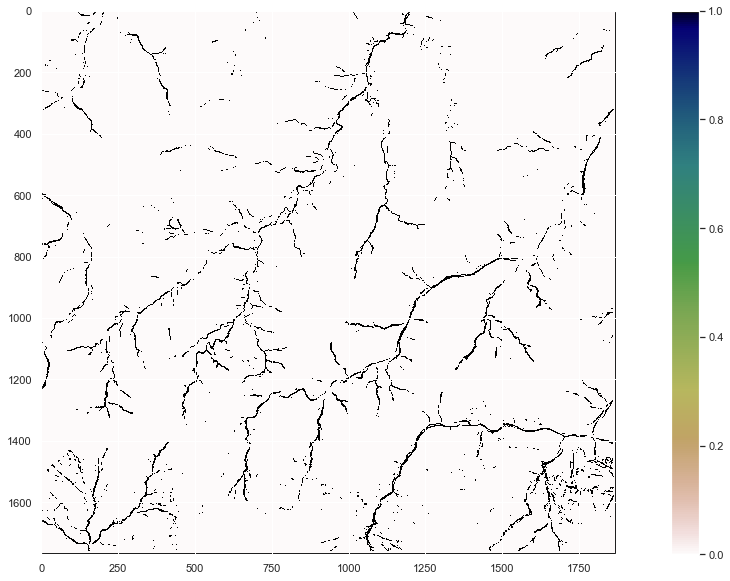

In [18]:
plt.figure(figsize=(20,10));
plt.imshow(dfme_copy, cmap="gist_earth_r");
plt.colorbar();

# Isolate drainage lines in gullies and channels

In [19]:
gully_internal_drainage = dfme_copy * catchment_area

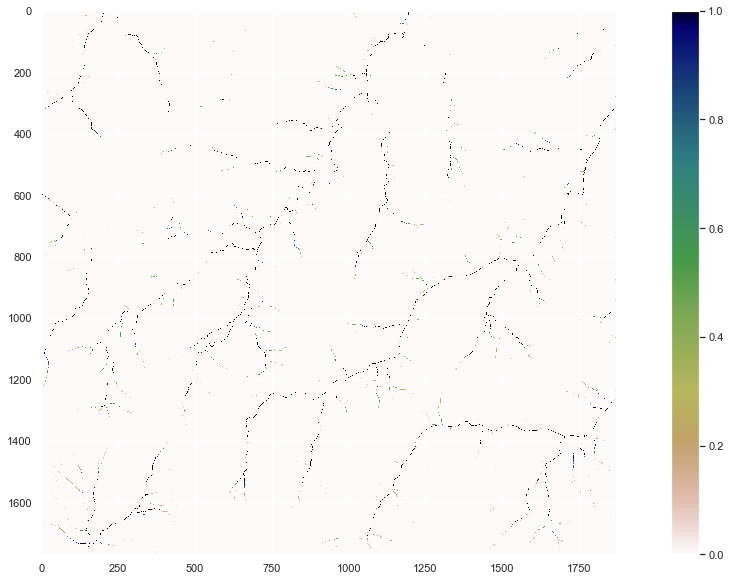

In [20]:
plt.figure(figsize=(20,10));
plt.imshow(gully_internal_drainage, cmap="gist_earth_r", vmax = 1);
plt.colorbar();

# Set a threshold drainage area for gully heads

In [21]:
min_drainage = np.copy(catchment_area)
min_drainage[min_drainage < threshold_minimum_drainage] = 0
min_drainage[min_drainage >= threshold_minimum_drainage] = 1
filtered_gully_drainage = gully_internal_drainage * min_drainage

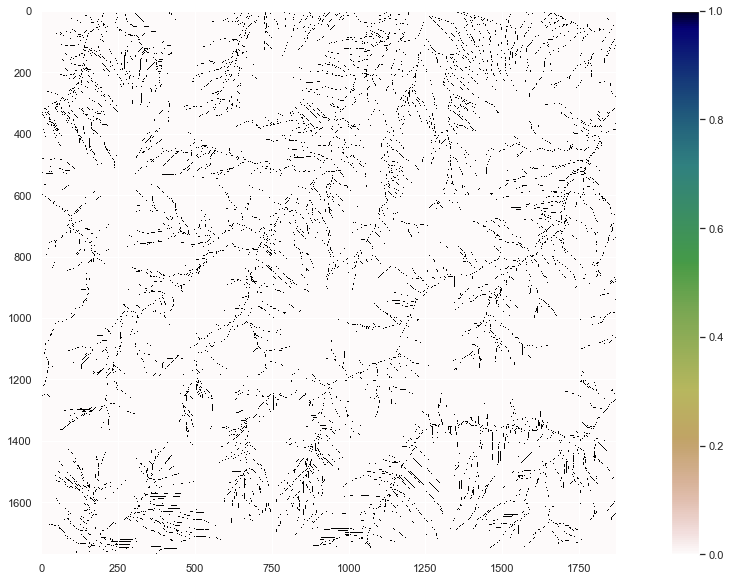

In [22]:
plt.figure(figsize=(20,10));
plt.imshow(min_drainage, cmap="gist_earth_r");
plt.colorbar();

# Find lowest contributing area of each section of isolated drainage area

### If the drainage skeleton found by the above steps has no breaks (is a continuous drainage network) then the below function will find only channel heads. However, this will almost never be the case and any one channel will have multiple candidate heads.

In [23]:
shape = 3
central_value = find_median_value(rectangleWindow(shape, shape))
num_values = number_of_values(rectangleWindow(shape, shape))

filtered_gully_head_points = generic_filter(filtered_gully_drainage, 
                            ghFilter, footprint= rectangleWindow(shape,shape), mode='constant');

# Count first estimate of number of gully heads

In [24]:
np.sum(filtered_gully_head_points)

1869.0

# Remove any gully candidates that do not meet some user-specified minimum length (m)

In [25]:
gully_lengths = np.copy(filtered_gully_drainage)
gully_lengths[gully_lengths > 0] = 1

for i in range(1, minimum_gully_length + 1):
    if i == 1:
        input_features = gully_lengths
    else:
        input_features = remove_small_features
    window_size = i*2+1
    central_value = find_median_value(rectangleWindow(window_size, window_size))
    remove_small_features = generic_filter(input_features, 
                                            removeSmallFeatures, 
                                           footprint= rectangleWindow(window_size,window_size), 
                                           mode='constant');
    

In [26]:
gully_heads_no_small_features = remove_small_features * filtered_gully_head_points

# Count second estimate of number of gully heads

In [27]:
np.sum(gully_heads_no_small_features)

1486.0

# Remove any small features along major drainage lines

In [28]:
initial_gh_drainage_areas = gully_heads_no_small_features * catchment_area * 10000

In [29]:
augmented_catchment_area = catchment_area + initial_gh_drainage_areas - (gully_heads_no_small_features * catchment_area)

In [30]:
np.max(initial_gh_drainage_areas)

1122950.0

In [31]:
def removeSmallChannelFeatures(gully_heads):
    """Reduce the number of candidate initial gully heads. The window size is custimizable through the 
    'footprint' argument. """
    surrounding_nodes_list = [];
    for i in range(0, num_values):
        if i != central_value:
            surrounding_nodes_list.append(gully_heads[i])
    surrounding_nodes_array = np.array(surrounding_nodes_list)
    largest_drainage_area = np.max(surrounding_nodes_array)
    target_gh_drainage_area = gully_heads[central_value]
    if target_gh_drainage_area < 100:
        keep_gh = 0
    elif largest_drainage_area / (target_gh_drainage_area/10000) > drainage_area_ratio_threshold:
        keep_gh = 0
    else:
        keep_gh = 1
    
    return keep_gh

In [32]:
drainage_area_ratio_threshold = 5

In [33]:
all_initial_gully_heads = np.copy(augmented_catchment_area)
window_size = 11
central_value = find_median_value(rectangleWindow(window_size, window_size))
num_values = number_of_values(rectangleWindow(window_size, window_size))


In [34]:
remove_small_channel_features = generic_filter(all_initial_gully_heads, 
                                        removeSmallChannelFeatures, 
                                       footprint= rectangleWindow(window_size,window_size), 
                                       mode='constant');

In [35]:
np.sum(remove_small_channel_features)

463.0

# Compute difference from mean elevation

In [36]:
tangential_curvature_smoothed= generic_filter(smoothed_dem, hengl2003TangentialCurvature, 
                footprint= rectangleWindow(3,3), 
                mode='constant', extra_arguments = (working_resolution,));

tangential_curvature_smoothed[tangential_curvature_smoothed<-0.3] = -0.3
tangential_curvature_smoothed[tangential_curvature_smoothed>0.3] = 0.3

In [144]:
tangential_curvature_threshold = -0.05

In [145]:
mask_tc = np.copy(tangential_curvature_smoothed)

mask_tc[mask_tc>tangential_curvature_threshold] = 0
mask_tc[mask_tc<=tangential_curvature_threshold] = 1
mask_tc_NaNs = np.isnan(mask_tc)
mask_tc[mask_tc_NaNs] = 0

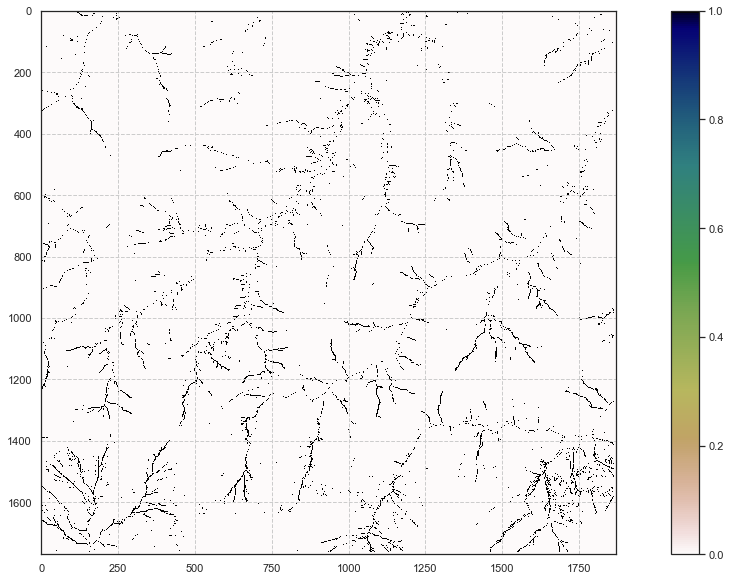

In [146]:
plt.figure(figsize=(20,10));
plt.imshow(mask_tc, cmap="gist_earth_r");
plt.colorbar();

In [140]:
def removeSmallChannels(x):
    """ """
    if x[central_value] == 0:
        keep_gh = 0
    elif np.nansum(x) <= window_size + 2:
        keep_gh = 0
    else:
        keep_gh = 1
    return keep_gh

In [141]:
search_size = 5

In [142]:
gully_lengths = np.copy(mask_tc)
gully_lengths[gully_lengths > 0] = 1

for i in range(1, search_size + 1):
    if i == 1:
        input_features = gully_lengths
    else:
        input_features = remove_small_features
    window_size = i*2+1
    central_value = find_median_value(rectangleWindow(window_size, window_size))
    remove_small_features = generic_filter(input_features, 
                                            removeSmallChannels, 
                                           footprint= rectangleWindow(window_size,window_size), 
                                           mode='constant');

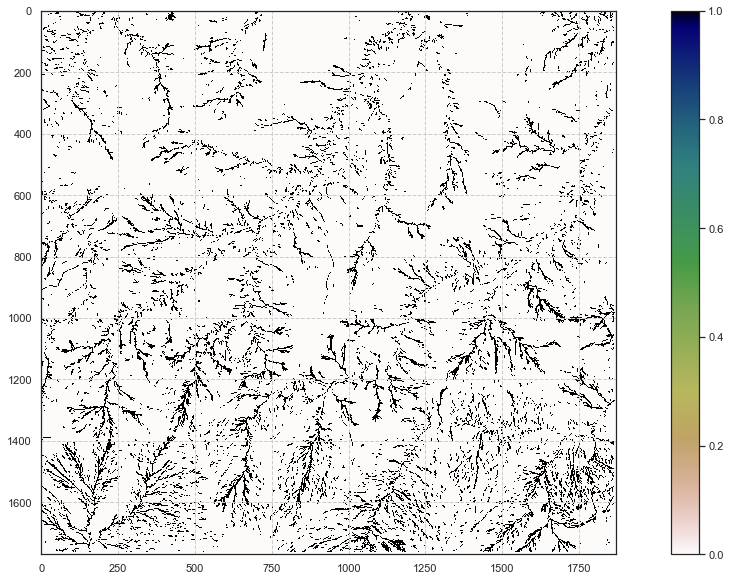

In [143]:
plt.figure(figsize=(20,10));
plt.imshow(remove_small_features, cmap="gist_earth_r");
plt.colorbar();

In [39]:
gully_heads_masked_by_curvature = gully_heads_no_small_features * mask_tc 

In [40]:
np.sum(gully_heads_masked_by_curvature)

910.0

## Mask by catchment boundary

In [41]:
masked_gully_heads = gully_heads_masked_by_curvature * dem_mask 

## Look at number of remaining gully heads

In [42]:
np.sum(masked_gully_heads)

416.0

## Isolate all gully head nodes

In [43]:
grid_nodes = np.array(mg.nodes.reshape(mg.shape));
grid_nodes_float = grid_nodes.astype('float64');
find_nodes = np.multiply(masked_gully_heads, grid_nodes);

## Create array of only gully head nodes 

In [44]:
gh_array = np.unique(find_nodes).astype('int32');

## Turn gully head node array into a list and remove the value 0

In [45]:
gh_list = gh_array.tolist();
gh_list.remove(0);

# Run multiple-direction flow routing algorithm

In [46]:
flow_acc_surf = np.copy(smoothed_dem).astype('float64');
#flow_acc_surf = np.copy(input_DEM).astype('float64');
#################################################################################################
rows = flow_acc_surf.shape[0];
cols = flow_acc_surf.shape[1];
mg = RasterModelGrid((rows,cols), 1);
z1 = mg.add_field('topographic__elevation', flow_acc_surf, at = 'node');

sfb = SinkFillerBarnes(mg, method = 'Steepest', ignore_overfill = True);
sfb.run_one_step();
fa = FlowAccumulator(mg,
                    surface = 'topographic__elevation',
                    flow_director = 'FlowDirectorMFD',
                    diagonals = True);
fa.run_one_step();
fd = FlowDirectorMFD(mg, 'topographic__elevation', diagonals = True);
fd.run_one_step();

da = np.array(mg.at_node['drainage_area'].round(4))
catchment_area_ha = np.divide(da.reshape(mg.shape), (100/working_resolution)**2)
frn = mg.at_node['flow__receiver_node']
drainage_area = np.flip(da.reshape(mg.shape), 0);
frp = np.array(mg.at_node['flow__receiver_proportions']);
ns = np.flip(mg.status_at_node.reshape(mg.shape), 0)
flow_rec_surf_rows = cols * rows;
flow_rec_surf = frp.reshape(flow_rec_surf_rows,8);

catchment_area = da.reshape(mg.shape) / (10000 * (1/working_resolution**2))

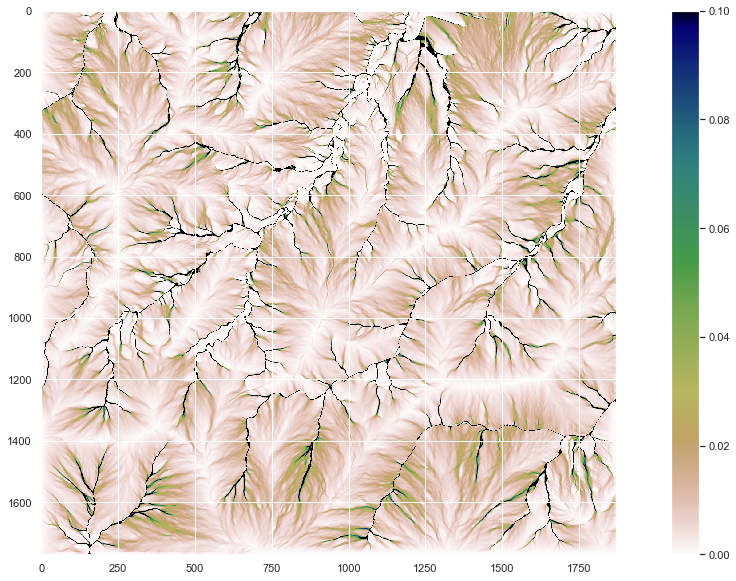

In [47]:
plt.figure(figsize=(20,10));
plt.imshow(catchment_area, cmap="gist_earth_r", vmax = .1);
plt.colorbar();

### The final variable in the function below sets the threshold catchment area at the point of convergence required to keep the gully head as a candidate. Default set to 0.1 ha.

## Work through list finding index positions of each node. catchment_area_node_list is the list of nodes where flow converges to a single cell.

In [48]:
catchment_area_dict, catchment_area_node_list = findGullyHeadNode(gh_list, grid_nodes, input_DEM, catchment_area,
                                                                  input_DEM_resolution, 10, convergence_threshold, threshold_minimum_drainage)        

max ca:  0.17465572
Node id:  115 Catchment area:  0.06723114
Node id:  94 Catchment area:  0.06620381
Node id:  72 Catchment area:  0.13060436
Node id:  51 Catchment area:  0.13631621
Node id:  30 Catchment area:  0.13045334
Node id:  8 Catchment area:  0.17465572
max ca:  0.10127068
Node id:  220 Catchment area:  0.02097332
Node id:  242 Catchment area:  0.02164541
Node id:  264 Catchment area:  0.02177958
Node id:  265 Catchment area:  0.02814303
Node id:  287 Catchment area:  0.03718075
Node id:  288 Catchment area:  0.05831353
max ca:  0.14883977
Node id:  220 Catchment area:  0.0403543
Node id:  200 Catchment area:  0.06536141
Node id:  222 Catchment area:  0.10672881
max ca:  13.26412001
Node id:  220 Catchment area:  8.95099335
Node id:  199 Catchment area:  7.44211342
max ca:  113.21823498
Node id:  220 Catchment area:  0.04949688
Node id:  198 Catchment area:  0.04152685
Node id:  176 Catchment area:  0.0312012
Node id:  175 Catchment area:  26.03445041
max ca:  0.10232419
No

Node id:  213 Catchment area:  0.08718586
Node id:  212 Catchment area:  0.08455849
Node id:  211 Catchment area:  0.08034482
max ca:  9.31149505
Node id:  220 Catchment area:  6.62771794
Node id:  199 Catchment area:  7.66136957
max ca:  0.23969066
Node id:  220 Catchment area:  0.175209
Node id:  199 Catchment area:  0.15314519
Node id:  179 Catchment area:  0.19928047
Node id:  159 Catchment area:  0.16700946
Node id:  138 Catchment area:  0.22533329
max ca:  0.11944407
Node id:  220 Catchment area:  0.0531247
Node id:  221 Catchment area:  0.06376395
Node id:  222 Catchment area:  0.08433698
max ca:  92.84057391
Node id:  220 Catchment area:  0.09746906
Node id:  242 Catchment area:  0.07865945
Node id:  243 Catchment area:  0.07727854
Node id:  244 Catchment area:  0.07397953
Node id:  245 Catchment area:  1.01663509
Node id:  246 Catchment area:  92.18861652
max ca:  3.5086541
Node id:  220 Catchment area:  0.74468755
Node id:  198 Catchment area:  1.09688802
Node id:  176 Catchm

Node id:  220 Catchment area:  0.02980786
Node id:  242 Catchment area:  0.02844891
Node id:  264 Catchment area:  0.02520131
Node id:  286 Catchment area:  0.02230893
Node id:  287 Catchment area:  0.029917
Node id:  288 Catchment area:  48.70886548
Node id:  268 Catchment area:  78.71701341
Node id:  248 Catchment area:  59.63487619
max ca:  78.18977584
Node id:  220 Catchment area:  0.03641134
Node id:  242 Catchment area:  0.03502439
Node id:  243 Catchment area:  0.03296967
Node id:  265 Catchment area:  22.31192027
Node id:  266 Catchment area:  64.23893315
max ca:  5.17326518
Node id:  220 Catchment area:  0.41939868
max ca:  0.64596464
Node id:  220 Catchment area:  0.04441199
Node id:  221 Catchment area:  0.04074298
Node id:  222 Catchment area:  0.03539635
Node id:  244 Catchment area:  0.05860909
Node id:  245 Catchment area:  0.10242739
max ca:  1.30647589
Node id:  220 Catchment area:  0.30882882
Node id:  198 Catchment area:  0.85243517
Node id:  177 Catchment area:  0.7

Node id:  220 Catchment area:  2.74119798
max ca:  0.93181579
Node id:  220 Catchment area:  0.37893048
max ca:  0.71823917
Node id:  220 Catchment area:  0.0852312
Node id:  199 Catchment area:  0.07942657
Node id:  178 Catchment area:  0.07605243
Node id:  157 Catchment area:  0.0874134
Node id:  137 Catchment area:  0.12757686
Node id:  138 Catchment area:  0.05203476
Node id:  118 Catchment area:  0.32138942
Node id:  119 Catchment area:  0.05350938
max ca:  0.27543672
Node id:  220 Catchment area:  0.01100578
Node id:  200 Catchment area:  0.04575565
Node id:  201 Catchment area:  0.04134087
Node id:  202 Catchment area:  0.07975868
max ca:  0.10756448
Node id:  220 Catchment area:  0.03812595
Node id:  199 Catchment area:  0.04541812
Node id:  178 Catchment area:  0.05031199
Node id:  157 Catchment area:  0.05419702
Node id:  136 Catchment area:  0.06186821
Node id:  115 Catchment area:  0.0699966
Node id:  94 Catchment area:  0.05706426
max ca:  5.53995927
Node id:  220 Catchmen

Node id:  220 Catchment area:  0.04685729
Node id:  198 Catchment area:  0.04969547
Node id:  176 Catchment area:  0.05145148
Node id:  154 Catchment area:  0.05735522
Node id:  133 Catchment area:  0.08699964
Node id:  111 Catchment area:  0.10563848
Node id:  89 Catchment area:  0.12536875
Node id:  67 Catchment area:  0.14430501
Node id:  45 Catchment area:  0.15957482
Node id:  23 Catchment area:  0.16744496
max ca:  0.23294813
Node id:  220 Catchment area:  0.08494641
Node id:  242 Catchment area:  0.10181627
Node id:  263 Catchment area:  0.10228811
Node id:  285 Catchment area:  0.12305618
Node id:  307 Catchment area:  0.12920956
Node id:  328 Catchment area:  0.13572289
Node id:  350 Catchment area:  0.16044406
Node id:  372 Catchment area:  0.18953021
Node id:  394 Catchment area:  0.21094168
Node id:  416 Catchment area:  0.22118661
max ca:  0.23938896
Node id:  220 Catchment area:  0.02592696
Node id:  242 Catchment area:  0.0352588
Node id:  264 Catchment area:  0.05264574

max ca:  0.09130762
Node id:  220 Catchment area:  0.01347166
Node id:  241 Catchment area:  0.02385559
Node id:  262 Catchment area:  0.05251256
Node id:  284 Catchment area:  0.06222535
Node id:  306 Catchment area:  0.06731733
Node id:  328 Catchment area:  0.06949954
Node id:  350 Catchment area:  0.06808088
Node id:  371 Catchment area:  0.08120865
Node id:  393 Catchment area:  0.0854629
Node id:  415 Catchment area:  0.0872572
max ca:  0.0872572
Node id:  220 Catchment area:  0.04290664
Node id:  221 Catchment area:  0.05105252
Node id:  222 Catchment area:  0.05013866
Node id:  244 Catchment area:  0.06071778
Node id:  266 Catchment area:  0.06643304
Node id:  288 Catchment area:  0.06970341
Node id:  310 Catchment area:  0.071979
Node id:  332 Catchment area:  0.07556759
Node id:  354 Catchment area:  0.08120865
Node id:  376 Catchment area:  0.0854629
max ca:  0.12950632
Node id:  220 Catchment area:  0.08120865
Node id:  242 Catchment area:  0.0854629
Node id:  264 Catchment

Node id:  222 Catchment area:  0.02365414
Node id:  202 Catchment area:  0.01005097
Node id:  181 Catchment area:  8.12308196
max ca:  0.44217353
Node id:  220 Catchment area:  0.12348802
Node id:  199 Catchment area:  0.16771167
Node id:  178 Catchment area:  0.20498696
Node id:  157 Catchment area:  0.22611004
Node id:  136 Catchment area:  0.22456513
Node id:  115 Catchment area:  0.2093488
Node id:  94 Catchment area:  0.19106763
Node id:  72 Catchment area:  0.29181551
Node id:  50 Catchment area:  0.3990718
Node id:  29 Catchment area:  0.41843939
max ca:  0.14571704
Node id:  220 Catchment area:  0.04685
Node id:  240 Catchment area:  0.06133523
Node id:  260 Catchment area:  0.07945014
Node id:  280 Catchment area:  0.09665092
Node id:  300 Catchment area:  0.10865233
Node id:  320 Catchment area:  0.11568458
Node id:  340 Catchment area:  0.11703469
Node id:  361 Catchment area:  0.12642195
Node id:  381 Catchment area:  0.14456864
max ca:  0.07668797
Node id:  220 Catchment a

Node id:  220 Catchment area:  0.09517399
Node id:  199 Catchment area:  0.10151802
Node id:  178 Catchment area:  0.10546609
Node id:  157 Catchment area:  0.11094875
Node id:  137 Catchment area:  0.22869723
Node id:  116 Catchment area:  0.2696767
Node id:  94 Catchment area:  0.23947391
Node id:  73 Catchment area:  0.32645371
Node id:  52 Catchment area:  0.39495192
max ca:  0.42448437
Node id:  220 Catchment area:  0.12107596
Node id:  199 Catchment area:  0.1348162
Node id:  178 Catchment area:  0.1594989
Node id:  157 Catchment area:  0.18931459
Node id:  136 Catchment area:  0.20434465
Node id:  114 Catchment area:  0.2696767
Node id:  92 Catchment area:  0.23947391
Node id:  71 Catchment area:  0.32645371
Node id:  50 Catchment area:  0.39495192
max ca:  0.11350515
Node id:  220 Catchment area:  0.05938559
Node id:  241 Catchment area:  0.05974061
Node id:  262 Catchment area:  0.06036817
Node id:  283 Catchment area:  0.06399887
Node id:  305 Catchment area:  0.07022069
Node

max ca:  0.08313815
Node id:  220 Catchment area:  0.05065216
Node id:  242 Catchment area:  0.05472878
Node id:  264 Catchment area:  0.05803068
Node id:  286 Catchment area:  0.06223267
Node id:  308 Catchment area:  0.06664616
Node id:  330 Catchment area:  0.07080892
Node id:  352 Catchment area:  0.07326474
Node id:  374 Catchment area:  0.07491765
Node id:  396 Catchment area:  0.07840389
Node id:  418 Catchment area:  0.08138904
max ca:  0.13010065
Node id:  220 Catchment area:  0.06538023
Node id:  219 Catchment area:  0.06971832
Node id:  239 Catchment area:  0.08076492
Node id:  238 Catchment area:  0.07998457
Node id:  258 Catchment area:  0.09366163
Node id:  257 Catchment area:  0.0866377
Node id:  277 Catchment area:  0.10495178
Node id:  297 Catchment area:  0.1168177
Node id:  317 Catchment area:  0.12345947
Node id:  337 Catchment area:  0.12834176
max ca:  0.42341381
Node id:  220 Catchment area:  0.01903778
Node id:  221 Catchment area:  0.20597108
Node id:  243 Catc

Node id:  220 Catchment area:  0.08238603
Node id:  198 Catchment area:  0.40562889
Node id:  177 Catchment area:  0.41622075
Node id:  155 Catchment area:  0.760681
Node id:  134 Catchment area:  0.65138517
Node id:  113 Catchment area:  0.53914694
Node id:  91 Catchment area:  0.71827212
Node id:  70 Catchment area:  0.61185652
Node id:  48 Catchment area:  0.77301784
Node id:  26 Catchment area:  0.95946941
max ca:  0.213107
Node id:  220 Catchment area:  0.09791127
Node id:  242 Catchment area:  0.10204268
Node id:  264 Catchment area:  0.11013156
Node id:  286 Catchment area:  0.12252556
Node id:  308 Catchment area:  0.14111562
Node id:  330 Catchment area:  0.15988959
Node id:  352 Catchment area:  0.17462639
Node id:  374 Catchment area:  0.19176981
Node id:  375 Catchment area:  0.11743323
Node id:  397 Catchment area:  0.144629
max ca:  1.76701323
Node id:  220 Catchment area:  1.12683363
Node id:  200 Catchment area:  0.98144355
Node id:  180 Catchment area:  0.65346401
Node

max ca:  7.58793254
Node id:  220 Catchment area:  0.0081258
Node id:  200 Catchment area:  0.05680175
max ca:  0.52249168
Node id:  220 Catchment area:  0.26149302
Node id:  241 Catchment area:  0.43195471
Node id:  263 Catchment area:  0.48953204
max ca:  1.83530662
Node id:  220 Catchment area:  0.68282883
Node id:  200 Catchment area:  1.02507776
Node id:  180 Catchment area:  1.12614942
Node id:  159 Catchment area:  1.23400278
Node id:  139 Catchment area:  0.88239557
Node id:  118 Catchment area:  1.23498888
Node id:  97 Catchment area:  1.75619261
max ca:  1.63514799
Node id:  220 Catchment area:  0.54223187
Node id:  241 Catchment area:  0.48902477
Node id:  263 Catchment area:  0.54137402
Node id:  284 Catchment area:  0.40293284
Node id:  306 Catchment area:  0.46204159
Node id:  307 Catchment area:  0.56273549
max ca:  0.09669364
Node id:  220 Catchment area:  0.02983545
Node id:  199 Catchment area:  0.03175567
Node id:  179 Catchment area:  0.03448502
Node id:  159 Catchm

max ca:  3.36772062
Node id:  220 Catchment area:  0.70363896
Node id:  242 Catchment area:  2.04775079
max ca:  0.18854114
Node id:  220 Catchment area:  0.0750929
Node id:  219 Catchment area:  0.08049211
Node id:  218 Catchment area:  0.08671168
Node id:  217 Catchment area:  0.0956433
Node id:  216 Catchment area:  0.11219863
Node id:  215 Catchment area:  0.13473684
Node id:  214 Catchment area:  0.15760711
Node id:  213 Catchment area:  0.16896489
Node id:  191 Catchment area:  0.16827535
Node id:  190 Catchment area:  0.18847406
max ca:  1.95714238
Node id:  220 Catchment area:  0.02494954
Node id:  200 Catchment area:  0.03097588
Node id:  180 Catchment area:  0.12366988
Node id:  160 Catchment area:  0.29847009
Node id:  140 Catchment area:  0.40307511
Node id:  120 Catchment area:  0.4383986
Node id:  100 Catchment area:  0.60959822
Node id:  80 Catchment area:  0.9745545
Node id:  60 Catchment area:  1.65268438
max ca:  4.5999535
Node id:  220 Catchment area:  0.0107041
Node

max ca:  7.87969934
Node id:  220 Catchment area:  0.12443004
Node id:  219 Catchment area:  0.12277988
Node id:  197 Catchment area:  0.13570724
Node id:  196 Catchment area:  5.02342817
max ca:  0.22849411
Node id:  220 Catchment area:  0.13117061
Node id:  198 Catchment area:  0.15365359
Node id:  176 Catchment area:  0.15622897
Node id:  175 Catchment area:  0.1746039
Node id:  153 Catchment area:  0.17052125
Node id:  152 Catchment area:  0.18557699
Node id:  130 Catchment area:  0.18404795
Node id:  108 Catchment area:  0.15915973
Node id:  107 Catchment area:  0.19338751
Node id:  106 Catchment area:  0.21602366
max ca:  7.87969934
Node id:  220 Catchment area:  2.28996705
Node id:  219 Catchment area:  4.60775957
Node id:  218 Catchment area:  5.72742809
Node id:  217 Catchment area:  3.11106986
max ca:  2.19286006
Node id:  220 Catchment area:  0.64574669
max ca:  7.66341658
Node id:  220 Catchment area:  0.01283558
Node id:  241 Catchment area:  0.04094272
Node id:  261 Catch

Node id:  220 Catchment area:  0.17956685
Node id:  242 Catchment area:  0.28026268
max ca:  0.52857422
Node id:  220 Catchment area:  0.02528207
Node id:  199 Catchment area:  0.03892163
Node id:  178 Catchment area:  0.207838
Node id:  158 Catchment area:  0.32593892
max ca:  0.20532729
Node id:  220 Catchment area:  0.04600247
Node id:  200 Catchment area:  0.04347814
Node id:  201 Catchment area:  0.08248716
Node id:  202 Catchment area:  0.13002718
Node id:  203 Catchment area:  0.18024761
Node id:  183 Catchment area:  0.17894516
Node id:  184 Catchment area:  0.20532729
Node id:  164 Catchment area:  0.20222758
Node id:  144 Catchment area:  0.18364925
Node id:  145 Catchment area:  0.20465755
max ca:  10.3403571
Node id:  220 Catchment area:  2.45817414
max ca:  0.17576392
Node id:  220 Catchment area:  0.06113521
Node id:  200 Catchment area:  0.12121587
Node id:  180 Catchment area:  0.1412481
Node id:  159 Catchment area:  0.15919387
max ca:  0.28119628
Node id:  220 Catchme

Node id:  220 Catchment area:  0.03870991
Node id:  219 Catchment area:  0.05027683
Node id:  218 Catchment area:  0.07127387
max ca:  10.38611907
Node id:  220 Catchment area:  4.06938306
Node id:  241 Catchment area:  5.70098313
Node id:  263 Catchment area:  0.39929617
Node id:  283 Catchment area:  5.22760558
Node id:  304 Catchment area:  3.71082246
Node id:  325 Catchment area:  3.12098536
max ca:  0.06666085
Node id:  220 Catchment area:  0.03104009
Node id:  200 Catchment area:  0.04442308
Node id:  201 Catchment area:  0.04384947
Node id:  181 Catchment area:  0.05758086
Node id:  182 Catchment area:  0.06024377
Node id:  183 Catchment area:  0.0537679
Node id:  163 Catchment area:  0.06666085
Node id:  164 Catchment area:  0.06399769
Node id:  165 Catchment area:  0.05594979
Node id:  145 Catchment area:  0.06486956
max ca:  0.10353863
Node id:  220 Catchment area:  0.0360882
Node id:  219 Catchment area:  0.03964509
Node id:  218 Catchment area:  0.04273855
Node id:  196 Cat

# Create a list of all gully head nodes that had a valid convergence point.

### In the catchment_area_dict the key is the initial gully head node and the value is the node where flow converges to a single cell (cp).

## This is a list of all initial gully heads to keep. Can have duplicates because some gully heads share a convergence point.

In [49]:
gully_heads_to_keep = get_keys(catchment_area_node_list, catchment_area_dict)
initial_gully_heads = np.isin(grid_nodes,gully_heads_to_keep).astype('int64')
initial_gully_head_and_cp_df = pd.DataFrame.from_dict(catchment_area_dict, orient='index')
initial_head_column = np.array(initial_gully_head_and_cp_df.index)
initial_gully_head_and_cp_df['initial'] = initial_head_column
initial_gully_head_and_cp_df.rename(columns={0: 'cp'}, inplace=True)

## This is a grid of all convergence points.

In [50]:
initial_cp_nodes = np.isin(grid_nodes,catchment_area_node_list).astype('int64')

In [51]:
initial_gh_nodes = np.isin(grid_nodes,initial_gully_head_and_cp_df['initial'].values).astype('int64')

In [52]:
np.sum(initial_cp_nodes)

239

# Can collect catchment area at this stage but need a reliable estimate of it (from a drainage area grid run with overlapping tiles).

In [53]:
cp_da_dict = {}

for i in catchment_area_node_list:
    result = np.where(grid_nodes == i);
    #################################################################################################
    # Find the index position (in the whole DEM) that corresponds to the current gully head point in the list.
    row_index = result[0][0];
    col_index = result[1][0];
    cp_da = catchment_area[row_index,col_index];
    cp_da_dict[i] = np.round(cp_da, 5);
    
cp_da_df = pd.DataFrame.from_dict(cp_da_dict, orient='index')
cp_da_df['cp'] = cp_da_df.index
initial_head_cp_df = initial_gully_head_and_cp_df.merge(cp_da_df, on="cp", how = 'inner')
initial_head_cp_df.rename(columns={0: 'area'}, inplace=True)


In [54]:
initial_head_cp_df

,cp,initial,area
0,423,9775,0.17466
1,30053,24438,0.05831
2,30053,31922,0.05831
3,25486,25484,0.10673
4,24511,26381,7.44211
...,...,...,...
250,3241772,3245511,0.05015
251,3234293,3245518,0.20127
252,3248388,3254003,0.24568
253,3255272,3255272,0.10204


In [55]:
initial_gh_da = initial_head_cp_df['initial'].values.tolist()

In [56]:
igh_da_dict = {}

for i in initial_gh_da:
    result = np.where(grid_nodes == i);
    #################################################################################################
    # Find the index position (in the whole DEM) that corresponds to the current gully head point in the list.
    row_index = result[0][0];
    col_index = result[1][0];
    igh_da = catchment_area[row_index,col_index];
    igh_da_dict[i] = np.round(igh_da, 5);
    
igh_da_df = pd.DataFrame.from_dict(igh_da_dict, orient='index')
igh_da_df['initial'] = igh_da_df.index
initial_head_cp_ighda_df = initial_head_cp_df.merge(igh_da_df, on="initial", how = 'inner')
initial_head_cp_ighda_df.rename(columns={0: 'gh_area'}, inplace=True)


In [57]:
pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_rows', 1000)

In [58]:
filter_test = initial_head_cp_ighda_df.copy()

In [59]:
drainage_ratio_threshold = 5

In [60]:
def drainageDiffrence(drainage_cp, drainage_gh):
    return drainage_cp/drainage_gh

filter_test['drainage_ratio'] = filter_test.apply(lambda x: drainageDiffrence(x['area'], x['gh_area']), axis=1)

In [61]:
filter_test.drop(filter_test[filter_test['drainage_ratio'] > drainage_ratio_threshold].index, inplace = True) 

# Now move 5m downstream of the remaining gully heads - this moves 5m downstream of 'gully_heads_to_keep' which is the list of inital gully heads meeting the convergence criterion.

In [62]:
downstream_5m_dict, downstream_5m_node_list = findPoint5mDownstream(gully_heads_to_keep, grid_nodes, input_DEM, catchment_area,
                                                                  input_DEM_resolution, 6) 

downstream_5m_df = pd.DataFrame.from_dict(downstream_5m_dict, orient='index')
downstream_5m_df['initial'] = downstream_5m_df.index
downstream_5m_df.rename(columns={0: '5m'}, inplace=True)

#initial_head_cp_5m_df = filter_test.merge(downstream_5m_df, on="initial", how = 'inner')
initial_head_cp_5m_df = initial_head_cp_ighda_df.merge(downstream_5m_df, on="initial", how = 'inner')

downstream_5m_node_array = np.isin(grid_nodes,downstream_5m_node_list).astype('int64')

max ca:  0.17465572
Node id:  71 Catchment area:  0.06723114
Node id:  58 Catchment area:  0.06620381
Node id:  44 Catchment area:  0.13060436
Node id:  31 Catchment area:  0.13631621
Node id:  18 Catchment area:  0.13045334
Node id:  4 Catchment area:  0.17465572
5
max ca:  0.0817679
Node id:  84 Catchment area:  0.02097332
Node id:  98 Catchment area:  0.02164541
Node id:  112 Catchment area:  0.02177958
Node id:  113 Catchment area:  0.02814303
Node id:  127 Catchment area:  0.03718075
Node id:  128 Catchment area:  0.05831353
5
max ca:  0.10127068
Node id:  84 Catchment area:  0.03475253
Node id:  72 Catchment area:  0.05831353
Node id:  73 Catchment area:  0.0817679
Node id:  74 Catchment area:  0.09968052
Node id:  75 Catchment area:  0.10127068
Node id:  63 Catchment area:  0.05879977
5
max ca:  0.14883977
Node id:  84 Catchment area:  0.0403543
Node id:  72 Catchment area:  0.06536141
Node id:  86 Catchment area:  0.10672881
Node id:  87 Catchment area:  0.14883977
Node id:  88

Node id:  84 Catchment area:  2.9054643
Node id:  70 Catchment area:  3.91125495
Node id:  56 Catchment area:  3.21624013
Node id:  42 Catchment area:  2.66632645
Node id:  28 Catchment area:  2.35389011
Node id:  15 Catchment area:  1.87101465
5
max ca:  1.57320429
Node id:  84 Catchment area:  1.24307996
Node id:  71 Catchment area:  0.94734653
Node id:  59 Catchment area:  1.36805128
Node id:  46 Catchment area:  1.00571168
Node id:  34 Catchment area:  1.57320429
Node id:  22 Catchment area:  1.06691305
5
max ca:  0.08784971
Node id:  84 Catchment area:  0.06937017
Node id:  98 Catchment area:  0.04221287
Node id:  99 Catchment area:  0.05508177
Node id:  100 Catchment area:  0.0692974
Node id:  101 Catchment area:  0.08429877
Node id:  102 Catchment area:  0.08784971
5
max ca:  0.08680388
Node id:  84 Catchment area:  0.06105236
Node id:  72 Catchment area:  0.07131146
Node id:  60 Catchment area:  0.07443628
Node id:  47 Catchment area:  0.07909472
Node id:  35 Catchment area:  0

Node id:  84 Catchment area:  1.29951429
Node id:  71 Catchment area:  1.51338598
Node id:  58 Catchment area:  1.70111169
Node id:  45 Catchment area:  1.61392256
Node id:  32 Catchment area:  1.23709632
Node id:  19 Catchment area:  0.84394028
5
max ca:  6.82061977
Node id:  84 Catchment area:  6.69155217
Node id:  72 Catchment area:  4.19199423
Node id:  60 Catchment area:  0.60912046
Node id:  47 Catchment area:  5.12154233
Node id:  34 Catchment area:  6.77032313
Node id:  22 Catchment area:  6.80143216
5
max ca:  0.4787193
Node id:  84 Catchment area:  0.35647878
Node id:  85 Catchment area:  0.28343835
Node id:  86 Catchment area:  0.16564781
Node id:  74 Catchment area:  0.32220527
Node id:  62 Catchment area:  0.42901516
Node id:  50 Catchment area:  0.4787193
5
max ca:  7.04019781
Node id:  84 Catchment area:  6.6601703
Node id:  71 Catchment area:  5.76843417
Node id:  57 Catchment area:  1.15606189
Node id:  45 Catchment area:  3.17478065
Node id:  33 Catchment area:  1.870

Node id:  84 Catchment area:  0.02618635
Node id:  97 Catchment area:  0.02696027
Node id:  110 Catchment area:  0.07025549
Node id:  123 Catchment area:  0.31897661
Node id:  136 Catchment area:  0.34800783
Node id:  150 Catchment area:  0.37312728
5
max ca:  0.51292397
Node id:  84 Catchment area:  0.12294007
Node id:  83 Catchment area:  0.41798965
Node id:  69 Catchment area:  0.44964162
Node id:  55 Catchment area:  0.42558552
Node id:  41 Catchment area:  0.34784605
Node id:  40 Catchment area:  0.51292397
5
max ca:  0.46641552
Node id:  84 Catchment area:  0.12856816
Node id:  85 Catchment area:  0.18312366
Node id:  86 Catchment area:  0.31660841
Node id:  87 Catchment area:  0.46641552
Node id:  75 Catchment area:  0.21636135
Node id:  76 Catchment area:  0.45966598
5
max ca:  0.53936719
Node id:  84 Catchment area:  0.3478765
Node id:  85 Catchment area:  0.32671222
Node id:  99 Catchment area:  0.35274101
Node id:  100 Catchment area:  0.39341847
Node id:  101 Catchment area

Node id:  84 Catchment area:  0.18539822
Node id:  71 Catchment area:  0.2097863
Node id:  59 Catchment area:  0.23959246
Node id:  47 Catchment area:  0.23288885
Node id:  35 Catchment area:  0.19347873
Node id:  22 Catchment area:  0.28788734
5
max ca:  1.28774678
Node id:  84 Catchment area:  0.81955198
Node id:  71 Catchment area:  0.97432907
Node id:  58 Catchment area:  0.92476621
Node id:  46 Catchment area:  1.01777337
Node id:  33 Catchment area:  1.27723958
Node id:  21 Catchment area:  0.99258225
5
max ca:  0.21238433
Node id:  84 Catchment area:  0.05380015
Node id:  98 Catchment area:  0.06501564
Node id:  112 Catchment area:  0.07530844
Node id:  100 Catchment area:  0.11861054
Node id:  88 Catchment area:  0.11601501
Node id:  89 Catchment area:  0.18534647
5
max ca:  0.86376587
Node id:  84 Catchment area:  0.45445204
Node id:  72 Catchment area:  0.30994194
Node id:  59 Catchment area:  0.50198225
Node id:  46 Catchment area:  0.51628085
Node id:  34 Catchment area:  0

Node id:  84 Catchment area:  0.0143905
Node id:  71 Catchment area:  0.01569422
Node id:  58 Catchment area:  0.01689704
Node id:  45 Catchment area:  0.01785247
Node id:  32 Catchment area:  0.01892106
Node id:  19 Catchment area:  0.0211036
5
max ca:  41.30387898
Node id:  84 Catchment area:  25.15303655
Node id:  72 Catchment area:  32.77326718
Node id:  60 Catchment area:  19.30771146
Node id:  61 Catchment area:  33.40067231
Node id:  49 Catchment area:  39.54860138
Node id:  37 Catchment area:  34.65794518
5
max ca:  0.99055901
Node id:  84 Catchment area:  0.17629441
Node id:  83 Catchment area:  0.94453199
Node id:  69 Catchment area:  0.88582449
Node id:  68 Catchment area:  0.7084619
Node id:  54 Catchment area:  0.79349419
Node id:  40 Catchment area:  0.77546786
5
max ca:  9.7881031
Node id:  84 Catchment area:  7.52881624
Node id:  85 Catchment area:  5.63720547
Node id:  86 Catchment area:  0.02365414
Node id:  74 Catchment area:  0.01005097
Node id:  61 Catchment area: 

Node id:  84 Catchment area:  1.22203839
Node id:  71 Catchment area:  1.47058992
Node id:  58 Catchment area:  2.0410474
Node id:  45 Catchment area:  2.9007128
Node id:  33 Catchment area:  1.73690874
Node id:  20 Catchment area:  2.84086209
5
max ca:  4.37820041
Node id:  84 Catchment area:  1.61114752
Node id:  72 Catchment area:  1.84511186
Node id:  73 Catchment area:  2.52612687
Node id:  61 Catchment area:  2.9007128
Node id:  49 Catchment area:  1.73690874
Node id:  36 Catchment area:  2.84086209
5
max ca:  3.71014621
Node id:  84 Catchment area:  1.22203839
Node id:  71 Catchment area:  1.47058992
Node id:  58 Catchment area:  2.0410474
Node id:  45 Catchment area:  2.9007128
Node id:  33 Catchment area:  1.73690874
Node id:  20 Catchment area:  2.84086209
5
max ca:  2.37271841
Node id:  84 Catchment area:  1.17751605
Node id:  72 Catchment area:  1.20153745
Node id:  73 Catchment area:  2.11387285
Node id:  74 Catchment area:  2.37271841
Node id:  75 Catchment area:  1.91154

Node id:  84 Catchment area:  1.60460146
Node id:  96 Catchment area:  1.42793757
Node id:  110 Catchment area:  2.12413638
Node id:  123 Catchment area:  1.85512618
Node id:  137 Catchment area:  2.1318569
Node id:  150 Catchment area:  1.91575647
5
max ca:  4.99101693
Node id:  84 Catchment area:  0.04422834
Node id:  71 Catchment area:  0.19146156
Node id:  58 Catchment area:  2.31725962
Node id:  46 Catchment area:  3.17044104
Node id:  34 Catchment area:  4.37221084
Node id:  22 Catchment area:  4.41824609
5
max ca:  4.99101693
Node id:  84 Catchment area:  0.04777008
Node id:  71 Catchment area:  0.04891311
Node id:  58 Catchment area:  2.24178399
Node id:  46 Catchment area:  3.09117606
Node id:  34 Catchment area:  4.03985546
Node id:  22 Catchment area:  4.99101693
5
max ca:  4.04116889
Node id:  84 Catchment area:  0.0287492
Node id:  71 Catchment area:  0.10941629
Node id:  59 Catchment area:  0.42328114
Node id:  46 Catchment area:  2.76471358
Node id:  33 Catchment area:  

Node id:  84 Catchment area:  0.02461785
Node id:  96 Catchment area:  0.03462047
Node id:  108 Catchment area:  0.03920111
Node id:  120 Catchment area:  0.03559423
Node id:  132 Catchment area:  0.02580681
Node id:  145 Catchment area:  0.03911556
5
max ca:  4.85792182
Node id:  84 Catchment area:  2.03281133
Node id:  96 Catchment area:  2.34111265
Node id:  95 Catchment area:  1.84086463
Node id:  107 Catchment area:  2.85047657
Node id:  119 Catchment area:  4.24909833
Node id:  131 Catchment area:  4.85792182
5
max ca:  5.68858879
Node id:  84 Catchment area:  0.04155952
Node id:  83 Catchment area:  0.04658646
Node id:  82 Catchment area:  0.05007136
Node id:  81 Catchment area:  0.07507538
Node id:  93 Catchment area:  0.04722095
Node id:  92 Catchment area:  0.23726691
5
max ca:  2.1287451
Node id:  84 Catchment area:  0.01291721
Node id:  70 Catchment area:  0.01457524
Node id:  56 Catchment area:  0.01528463
Node id:  42 Catchment area:  0.02225631
Node id:  29 Catchment are

max ca:  0.20127081
Node id:  84 Catchment area:  0.06299035
Node id:  70 Catchment area:  0.05825137
Node id:  56 Catchment area:  0.05925844
Node id:  43 Catchment area:  0.04074995
Node id:  29 Catchment area:  0.06017236
Node id:  15 Catchment area:  0.10940768
5
max ca:  0.29866927
Node id:  84 Catchment area:  0.01933516
Node id:  70 Catchment area:  0.04590529
Node id:  69 Catchment area:  0.0607901
Node id:  55 Catchment area:  0.14898909
Node id:  54 Catchment area:  0.15498065
Node id:  40 Catchment area:  0.2456752
5
max ca:  0.15356944
Node id:  84 Catchment area:  0.10203871
Node id:  72 Catchment area:  0.06899028
Node id:  73 Catchment area:  0.15356944
Node id:  61 Catchment area:  0.12284833
Node id:  62 Catchment area:  0.13334808
Node id:  50 Catchment area:  0.13729279
5
max ca:  0.15356944
Node id:  84 Catchment area:  0.07743053
Node id:  85 Catchment area:  0.06714704
Node id:  73 Catchment area:  0.09450174
Node id:  61 Catchment area:  0.11846609
Node id:  49 C

In [63]:
np.sum(downstream_5m_node_array)

250

# Remove any gully head candidates that have drainage area < given threshold estimated by multiple-direction algorithm. Haven't done this yet.

### Remove any gully heads around edges of the DEM

In [64]:
# Must be larger than 'line_length' (specified later).
size_of_edge = 30

In [65]:
grid_nodes = np.array(mg.nodes.reshape(mg.shape))
find_nodes = np.multiply(downstream_5m_node_array, grid_nodes);

gully_head_edge_mask = np.zeros([grid_nodes.shape[0], grid_nodes.shape[1]])
gully_head_mask_centre = np.ones([grid_nodes.shape[0] - size_of_edge*2, grid_nodes.shape[1] - size_of_edge*2])
gully_head_edge_mask[size_of_edge:-1*(size_of_edge), size_of_edge:-1*(size_of_edge)] = gully_head_mask_centre

remaining_gully_heads = find_nodes * gully_head_edge_mask
gh_array = np.unique(remaining_gully_heads).astype(int);
gh_list = gh_array.tolist();
gh_list.remove(0);
len(gh_list)

230

## Calculate slope

In [66]:
slope = generic_filter(input_DEM, slopeWindowMperM,
                  footprint= rectangleWindow(3,3),
                  mode='constant', extra_arguments = (input_DEM_resolution,input_DEM_resolution,));

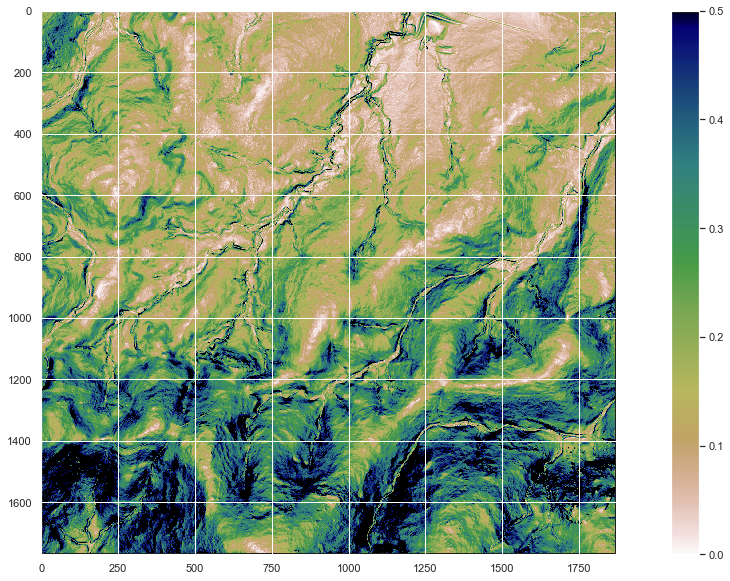

In [67]:
plt.figure(figsize=(20,10));
plt.imshow(slope, cmap="gist_earth_r", vmax = 0.5);
plt.colorbar();

## Specific the size of the area to be checked. This represents a physical distance from the outlet but has no unit of measure.

In [68]:
distance_from_outlet = 20

## Move upstream from the point 5m downstream until the gully head position is found. The first input is the maximum upstream distance checked.

In [69]:
len(gh_list)

230

In [70]:
final_gh_and_5m_downstream, gullies_to_keep_dict = upstreamDrainageLine(20, input_DEM_resolution, grid_nodes, 
                                       input_DEM, catchment_area, DFME,gh_list, step_s, comp_d, dfme_threshold, 
                                                                        gh_min_elev)

840
(41, 41)
839
879
878
877
917
916
956
955
995
994
993
992
991
990
989
988
987
986
1026
985
[190.325439453125, 190.56785583496094, 190.68441772460938, 190.94923400878906, 191.18310546875, 191.49620056152344, 191.74421691894531, 191.86329650878906, 192.00079345703125, 192.04110717773438, 192.105712890625, 192.11758422851563, 192.19686889648438, 192.2213134765625, 192.25279235839844, 192.28363037109375, 192.29011535644531, 192.33998107910156, 192.41239929199219, 192.43429565429688]
node:  79713
minimum downstream value:  -0.420455387538
mean upstream value:  -0.154476875949
std upstream value:  0.0847016902654
840
(41, 41)
882
923
965
1007
1048
1089
1130
1171
1212
1253
1293
1334
1375
1416
1457
1498
1539
1581
1540
[188.80506896972656, 188.92930603027344, 188.93763732910156, 188.97117614746094, 189.00321960449219, 189.10688781738281, 189.13963317871094, 189.08993530273438, 189.08721923828125, 189.13983154296875, 189.18885803222656, 189.24615478515625, 189.1751708984375, 189.1184844970703

840
(41, 41)
841
883
884
885
[206.12899780273438, 206.17391967773438, 206.30250549316406, 206.4765625]
840
(41, 41)
881
922
963
1004
1045
1044
1002
1001
1041
1040
1039
1038
1037
1036
1035
993
951
909
867
825
[189.61048889160156, 189.62321472167969, 189.65339660644531, 189.70814514160156, 189.75749206542969, 189.89163208007813, 190.33241271972656, 190.86959838867188, 191.30766296386719, 191.3819580078125, 191.53643798828125, 191.68272399902344, 191.87898254394531, 192.13104248046875, 192.45635986328125, 192.56001281738281, 192.78092956542969, 193.19972229003906, 193.43995666503906, 193.62577819824219]
node:  150729
minimum downstream value:  -0.764646240938
mean upstream value:  -0.416737415736
std upstream value:  0.160943023623
minimum downstream value:  -0.697175415663
mean upstream value:  -0.211938906768
std upstream value:  0.155519057607
minimum downstream value:  -0.625726579174
mean upstream value:  -0.0818309836704
std upstream value:  0.107813508588
minimum downstream value: 

840
(41, 41)
881
922
964
1005
1047
1088
1130
1172
1214
1256
1298
1299
1341
1383
1425
1467
1468
1510
1552
1553
[209.85203552246094, 209.85099792480469, 209.91767883300781, 209.88734436035156, 210.0008544921875, 210.14718627929688, 210.19998168945313, 210.34901428222656, 210.47508239746094, 210.6231689453125, 210.62608337402344, 210.6356201171875, 210.59579467773438, 210.5572509765625, 210.91854858398438, 211.11006164550781, 211.22761535644531, 211.28816223144531, 211.39578247070313, 211.43818664550781]
node:  222859
minimum downstream value:  -0.403624534817
mean upstream value:  -0.448406074764
std upstream value:  0.0108962837036
minimum downstream value:  -0.403624534817
mean upstream value:  -0.456615697172
std upstream value:  0.00261763988978
minimum downstream value:  -0.403624534817
mean upstream value:  -0.456797899189
std upstream value:  0.00278318743861
minimum downstream value:  -0.433382682222
mean upstream value:  -0.460453185573
std upstream value:  0.00251531889256
mini

840
(41, 41)
841
842
843
844
845
805
765
724
684
644
604
563
523
482
442
402
362
322
281
241
[216.38529968261719, 216.62062072753906, 216.74293518066406, 216.82130432128906, 216.92041015625, 217.05158996582031, 217.26509094238281, 217.3626708984375, 217.64517211914063, 217.84620666503906, 218.12181091308594, 218.32192993164063, 218.49385070800781, 218.66970825195313, 218.80628967285156, 219.01722717285156, 219.16603088378906, 219.37054443359375, 219.6016845703125, 219.81465148925781]
node:  260316
minimum downstream value:  -0.249257102499
mean upstream value:  -0.283088266949
std upstream value:  0.0134436006424
minimum downstream value:  -0.249257102499
mean upstream value:  -0.293793487351
std upstream value:  0.00473387118897
minimum downstream value:  -0.249257102499
mean upstream value:  -0.294151188758
std upstream value:  0.00500862244362
minimum downstream value:  -0.25363436483
mean upstream value:  -0.304844433343
std upstream value:  0.0101466204166
minimum downstream value

840
(41, 41)
881
922
963
1003
1043
1002
960
919
[205.9725341796875, 205.99153137207031, 206.09310913085938, 206.359130859375, 206.38145446777344, 206.40538024902344, 206.43975830078125, 206.49124145507813]
node:  319913
minimum downstream value:  -0.322299378414
mean upstream value:  -0.0926479234807
std upstream value:  0.0409171683567
840
(41, 41)
881
921
962
1003
1043
1083
1123
1164
1205
1246
1286
1326
1367
1408
1448
1447
1446
1445
1403
1361
[192.46490478515625, 192.3839111328125, 192.28446960449219, 192.10563659667969, 192.45600891113281, 192.94725036621094, 192.83470153808594, 192.77558898925781, 192.72410583496094, 192.66545104980469, 192.81619262695313, 192.92649841308594, 192.94184875488281, 192.96681213378906, 193.02407836914063, 193.16598510742188, 193.32113647460938, 193.46920776367188, 193.70286560058594, 194.03976440429688]
node:  320835
minimum downstream value:  -0.351739207614
mean upstream value:  -0.183854612933
std upstream value:  0.100428571655
minimum downstream v

840
(41, 41)
881
922
963
1004
1045
1087
1128
1169
1211
1253
1294
1335
1376
1417
1458
1500
1541
1582
1623
1624
[215.32052612304688, 215.41714477539063, 215.50477600097656, 215.61111450195313, 215.70404052734375, 215.78302001953125, 216.01002502441406, 216.17684936523438, 216.45626831054688, 216.46934509277344, 216.50048828125, 216.5533447265625, 216.62130737304688, 216.615966796875, 216.69625854492188, 216.75369262695313, 216.77577209472656, 216.79817199707031, 216.83526611328125, 216.91886901855469]
node:  370901
minimum downstream value:  -0.207359567025
mean upstream value:  -0.152815900546
std upstream value:  0.0526779052625
840
(41, 41)
880
920
960
959
1000
1040
1081
1122
1163
1203
1244
1284
1324
1364
1363
1403
1444
1484
1524
1564
[216.38200378417969, 216.4700927734375, 216.73220825195313, 216.99897766113281, 217.19874572753906, 217.53126525878906, 217.74552917480469, 218.28254699707031, 218.48886108398438, 218.60894775390625, 218.64448547363281, 218.76545715332031, 218.8381652832

840
(41, 41)
881
921
962
1003
1044
1085
1127
1128
1129
1171
1212
1254
1296
1337
1378
1419
1461
1503
1545
1586
[198.30281066894531, 198.35978698730469, 198.47959899902344, 198.51593017578125, 198.55001831054688, 198.59536743164063, 198.5499267578125, 198.72927856445313, 198.812255859375, 198.98611450195313, 199.28324890136719, 199.32087707519531, 199.38981628417969, 199.45947265625, 199.4788818359375, 199.50355529785156, 199.55975341796875, 199.62860107421875, 199.662841796875, 199.69967651367188]
node:  418320
minimum downstream value:  -0.251576181304
mean upstream value:  -0.078316223444
std upstream value:  0.0251314687803
minimum downstream value:  -0.152882944897
mean upstream value:  -0.0449526184681
std upstream value:  0.0374819057611
minimum downstream value:  -0.100090814928
mean upstream value:  -0.0143674220733
std upstream value:  0.0203186031524
minimum downstream value:  -0.0917555891843
mean upstream value:  0.0
std upstream value:  0.0
minimum downstream value:  -0.043

840
(41, 41)
881
921
961
1001
1042
1083
1124
1165
1206
1247
1287
1286
1326
1325
1365
1364
1363
1362
1361
1319
[209.02452087402344, 209.07870483398438, 209.12533569335938, 209.07444763183594, 209.29275512695313, 209.44081115722656, 209.518310546875, 209.59336853027344, 209.64076232910156, 209.70382690429688, 209.66090393066406, 209.71163940429688, 209.72364807128906, 209.62467956542969, 209.80767822265625, 209.84178161621094, 209.9031982421875, 209.93283081054688, 210.07487487792969, 210.1424560546875]
node:  486300
minimum downstream value:  -0.237247076331
mean upstream value:  -0.149542442325
std upstream value:  0.0559123298121
840
(41, 41)
798
797
796
837
[213.08534240722656, 213.2911376953125, 213.52789306640625, 213.55642700195313]
840
(41, 41)
839
879
878
877
876
834
833
832
790
748
747
705
664
663
662
661
660
659
658
698
[222.87103271484375, 222.95230102539063, 223.1097412109375, 223.13893127441406, 223.48916625976563, 223.53343200683594, 223.68901062011719, 223.84771728515625,

840
(41, 41)
882
923
964
1005
1046
1087
1128
1169
1210
1251
1292
1333
1374
1415
1456
1497
1538
1579
1620
1619
[230.38032531738281, 230.77127075195313, 231.17298889160156, 231.36482238769531, 231.4708251953125, 231.91058349609375, 231.91474914550781, 231.95486450195313, 232.1322021484375, 232.19752502441406, 232.31813049316406, 232.306396484375, 232.41207885742188, 232.73121643066406, 232.93379211425781, 232.96018981933594, 233.0408935546875, 233.28622436523438, 233.546630859375, 233.6378173828125]
node:  680843
minimum downstream value:  -0.400670084419
mean upstream value:  -0.344039758924
std upstream value:  0.0116504188905
minimum downstream value:  -0.357430768974
mean upstream value:  -0.363985860108
std upstream value:  0.0299453758869
minimum downstream value:  -0.343169898998
mean upstream value:  -0.395340628729
std upstream value:  0.0273109992607
minimum downstream value:  -0.330225797763
mean upstream value:  -0.424616977941
std upstream value:  0.0177784396455
minimum dow

840
(41, 41)
798
756
715
673
672
630
588
546
504
462
461
419
377
376
334
292
250
208
167
125
[202.5260009765625, 202.70565795898438, 202.84738159179688, 203.1407470703125, 203.28373718261719, 203.60821533203125, 203.79139709472656, 204.04629516601563, 204.39886474609375, 204.64488220214844, 204.72251892089844, 205.05349731445313, 205.32876586914063, 205.39830017089844, 205.61807250976563, 205.86524963378906, 206.04902648925781, 206.43675231933594, 206.67303466796875, 206.91900634765625]
node:  766447
minimum downstream value:  -0.391244197666
mean upstream value:  -0.397418515697
std upstream value:  0.0194546686075
minimum downstream value:  -0.41439789174
mean upstream value:  -0.417890404968
std upstream value:  0.0214449959091
minimum downstream value:  -0.378934809291
mean upstream value:  -0.429053480636
std upstream value:  0.00802224774284
minimum downstream value:  -0.378934809291
mean upstream value:  -0.417100189363
std upstream value:  0.0215297926195
minimum downstream val

840
(41, 41)
880
922
963
1003
1043
1083
1084
1126
1168
1210
1252
1294
1336
1378
1420
1462
1504
1546
1588
1630
[185.4625244140625, 185.50932312011719, 185.61021423339844, 185.62800598144531, 185.65705871582031, 185.68269348144531, 185.68927001953125, 185.74359130859375, 185.90141296386719, 186.2100830078125, 186.46882629394531, 186.70780944824219, 186.86271667480469, 187.01556396484375, 187.20298767089844, 187.45358276367188, 187.55690002441406, 187.68421936035156, 187.79135131835938, 187.87588500976563]
node:  914339
minimum downstream value:  -0.155618822557
mean upstream value:  -0.175618990449
std upstream value:  0.0293260269931
minimum downstream value:  -0.155618822557
mean upstream value:  -0.16095208977
std upstream value:  0.0395217314444
minimum downstream value:  -0.155618822557
mean upstream value:  -0.115394184445
std upstream value:  0.0276531994674
minimum downstream value:  -0.166356111668
mean upstream value:  -0.0674789795669
std upstream value:  0.0499621684294
minim

840
(41, 41)
881
922
963
1004
1045
1046
1088
1089
1049
1050
1051
1052
1094
1136
1137
1179
1221
1263
1305
1306
[236.21697998046875, 236.28250122070313, 236.32977294921875, 236.41001892089844, 236.40878295898438, 236.55267333984375, 236.55914306640625, 236.62846374511719, 236.66212463378906, 236.66546630859375, 236.69760131835938, 236.75344848632813, 236.77749633789063, 236.79910278320313, 236.83489990234375, 236.89480590820313, 236.99465942382813, 237.04621887207031, 237.10881042480469, 237.13351440429688]
node:  1307217
minimum downstream value:  -0.276296894808
mean upstream value:  -0.142279709259
std upstream value:  0.0662465726753
minimum downstream value:  -0.250226904357
mean upstream value:  -0.0745793135092
std upstream value:  0.0399882612813
minimum downstream value:  -0.230582254523
mean upstream value:  -0.0328334393244
std upstream value:  0.0292394642833
minimum downstream value:  -0.125237622555
mean upstream value:  -0.00916035575824
std upstream value:  0.012954699349

840
(41, 41)
882
923
965
1007
1049
1090
1131
1173
1214
1256
1297
1339
1380
1422
1463
1504
1545
1587
1628
1627
[245.79489135742188, 245.78253173828125, 245.88607788085938, 246.09548950195313, 246.20780944824219, 246.25656127929688, 246.27159118652344, 246.28732299804688, 246.35044860839844, 246.35755920410156, 246.41505432128906, 246.42564392089844, 246.46321105957031, 246.52619934082031, 246.53485107421875, 246.57575988769531, 246.60984802246094, 246.56721496582031, 246.56636047363281, 246.73013305664063]
node:  1668186
minimum downstream value:  -0.316372268692
mean upstream value:  -0.161050647795
std upstream value:  0.00402983978775
840
(41, 41)
880
879
919
959
999
1039
1080
1120
1161
1202
1243
1285
1326
1367
1408
1449
1490
1531
1572
1612
[249.24754333496094, 249.34011840820313, 249.55604553222656, 249.64898681640625, 249.71371459960938, 249.68431091308594, 249.7935791015625, 249.79244995117188, 249.75975036621094, 249.77435302734375, 249.82461547851563, 249.86433410644531, 249.860

840
(41, 41)
798
756
714
713
712
670
669
668
626
625
624
623
622
621
579
537
495
453
411
370
[226.87181091308594, 227.31327819824219, 227.87223815917969, 228.259521484375, 228.74459838867188, 229.08920288085938, 230.30561828613281, 230.8427734375, 231.29708862304688, 231.68862915039063, 232.09150695800781, 232.47187805175781, 232.86845397949219, 233.25094604492188, 233.74964904785156, 234.2664794921875, 234.67897033691406, 235.14404296875, 235.55245971679688, 235.82447814941406]
node:  2309376
minimum downstream value:  -0.537030261546
mean upstream value:  -0.474453466498
std upstream value:  0.102182774305
minimum downstream value:  -0.591070251215
mean upstream value:  -0.354516397621
std upstream value:  0.120607970497
minimum downstream value:  -0.577277547617
mean upstream value:  -0.283250215125
std upstream value:  0.0490259852128
minimum downstream value:  -0.510975408581
mean upstream value:  -0.274541489297
std upstream value:  0.0406449292353
minimum downstream value:  -0.3

840
(41, 41)
799
758
717
677
636
595
554
512
471
429
387
345
303
261
219
177
135
93
52
51
[238.56956481933594, 238.68093872070313, 238.94950866699219, 239.11529541015625, 239.36943054199219, 239.60728454589844, 239.89892578125, 240.22576904296875, 240.53639221191406, 240.88804626464844, 241.15029907226563, 241.55223083496094, 241.99534606933594, 242.46484375, 242.83837890625, 243.29652404785156, 243.85475158691406, 244.38465881347656, 244.82737731933594, 245.08441162109375]
node:  2497712
minimum downstream value:  -0.35185712892
mean upstream value:  -0.352205115036
std upstream value:  0.0151537492665
minimum downstream value:  -0.365372634005
mean upstream value:  -0.324911997486
std upstream value:  0.0287557186656
minimum downstream value:  -0.365372634005
mean upstream value:  -0.298607127244
std upstream value:  0.0239557909153
minimum downstream value:  -0.356026080533
mean upstream value:  -0.278717483268
std upstream value:  0.00595290106835
minimum downstream value:  -0.3320

840
(41, 41)
880
921
961
1001
1041
1082
1122
1164
1205
1246
1286
1327
1326
1325
1324
1365
1364
[207.83964538574219, 207.89004516601563, 207.97245788574219, 208.02372741699219, 208.14106750488281, 208.17904663085938, 208.09797668457031, 208.32591247558594, 208.31294250488281, 208.40049743652344, 208.51174926757813, 208.63859558105469, 208.71839904785156, 208.87361145019531, 209.05816650390625, 209.20928955078125, 209.24263000488281]
node:  2530041
minimum downstream value:  -0.411254632683
mean upstream value:  -0.313187171366
std upstream value:  0.0449747084009
minimum downstream value:  -0.356102647441
mean upstream value:  -0.330073870835
std upstream value:  0.0505637104573
minimum downstream value:  -0.312110678634
mean upstream value:  -0.329622078168
std upstream value:  0.0502205597508
minimum downstream value:  -0.312110678634
mean upstream value:  -0.370705047006
std upstream value:  0.00814252510227
minimum downstream value:  -0.258650764158
mean upstream value:  -0.35042555

840
(41, 41)
839
797
796
754
753
752
710
709
667
666
665
623
622
621
620
619
577
576
575
534
[213.87019348144531, 213.94580078125, 213.97267150878906, 214.00149536132813, 214.0457763671875, 214.04310607910156, 214.12785339355469, 214.11300659179688, 214.06782531738281, 214.07209777832031, 214.12120056152344, 214.18702697753906, 214.23989868164063, 214.34577941894531, 214.36344909667969, 214.4227294921875, 214.50971984863281, 214.51158142089844, 214.54507446289063, 214.84495544433594]
node:  2559821
minimum downstream value:  -0.438187248161
mean upstream value:  -0.52713478537
std upstream value:  0.0575321011944
minimum downstream value:  -0.462628767919
mean upstream value:  -0.524748977507
std upstream value:  0.0576095517816
minimum downstream value:  -0.462628767919
mean upstream value:  -0.601980541885
std upstream value:  0.0685077022583
minimum downstream value:  -0.456415619603
mean upstream value:  -0.61719754314
std upstream value:  0.0708173708536
minimum downstream value: 

840
(41, 41)
880
920
960
959
958
998
1038
1079
1120
1162
1203
1244
1284
1324
1365
1407
1448
1489
1530
1571
[212.72746276855469, 212.90847778320313, 212.98097229003906, 213.13189697265625, 213.22770690917969, 213.44244384765625, 213.44561767578125, 213.64859008789063, 213.70854187011719, 213.7867431640625, 213.86341857910156, 213.90974426269531, 213.95684814453125, 214.0477294921875, 214.16537475585938, 214.19219970703125, 214.25970458984375, 214.36077880859375, 214.4539794921875, 214.56332397460938]
node:  2612219
minimum downstream value:  -0.283887076597
mean upstream value:  -0.182952587308
std upstream value:  0.00431729190574
840
(41, 41)
800
760
720
679
639
599
559
519
478
438
397
357
317
277
278
238
198
158
118
78
[297.89666748046875, 298.14590454101563, 298.62255859375, 298.764404296875, 299.28564453125, 299.702392578125, 300.1939697265625, 300.65408325195313, 300.9530029296875, 301.47579956054688, 301.6513671875, 302.130859375, 302.51498413085938, 302.9224853515625, 303.129150

840
(41, 41)
881
921
962
1004
1046
1087
1127
1168
1209
1250
1291
1331
1372
1414
1454
1494
1534
1533
1573
1572
[215.22622680664063, 215.25399780273438, 215.43290710449219, 215.73361206054688, 215.70513916015625, 215.92259216308594, 216.01631164550781, 216.12187194824219, 216.44053649902344, 216.60464477539063, 216.74143981933594, 216.76914978027344, 216.84135437011719, 216.90959167480469, 216.80122375488281, 217.18096923828125, 217.24638366699219, 217.23103332519531, 217.35235595703125, 217.36959838867188]
node:  2677657
minimum downstream value:  -0.280615269065
mean upstream value:  -0.0700810274899
std upstream value:  0.0088099058567
840
(41, 41)
880
921
962
1002
1043
1083
1123
1163
1203
1243
1283
1324
1364
1404
1444
1484
1524
1564
1604
1563
[238.92282104492188, 238.95744323730469, 239.20875549316406, 239.23211669921875, 239.29231262207031, 239.61808776855469, 239.50914001464844, 239.59791564941406, 239.80522155761719, 240.00431823730469, 239.98193359375, 240.05081176757813, 240.351

840
(41, 41)
799
759
718
678
637
597
556
516
476
435
394
354
314
273
233
192
152
112
72
73
[283.6260986328125, 283.8448486328125, 284.19082641601563, 284.4197998046875, 284.88751220703125, 285.41574096679688, 285.65054321289063, 286.12936401367188, 286.544921875, 286.75146484375, 287.10507202148438, 287.86697387695313, 287.99908447265625, 288.20562744140625, 288.49005126953125, 288.88015747070313, 289.12466430664063, 289.51788330078125, 290.01812744140625, 290.46694946289063]
node:  2713750
minimum downstream value:  -0.800985990206
mean upstream value:  -0.825571918834
std upstream value:  0.00751502956229
minimum downstream value:  -0.800985990206
mean upstream value:  -0.811883247052
std upstream value:  0.0192253445141
minimum downstream value:  -0.800985990206
mean upstream value:  -0.789121002121
std upstream value:  0.0206013264022
minimum downstream value:  -0.827822731363
mean upstream value:  -0.770026326741
std upstream value:  0.0121692646676
minimum downstream value:  -0.8

840
(41, 41)
799
759
718
677
637
596
556
516
475
434
393
352
312
272
231
190
150
109
69
68
[274.54962158203125, 274.80072021484375, 274.92437744140625, 275.25924682617188, 275.56948852539063, 275.65286254882813, 276.26983642578125, 276.52789306640625, 276.86737060546875, 276.87286376953125, 276.99639892578125, 277.13552856445313, 277.36477661132813, 277.6082763671875, 277.65460205078125, 277.9627685546875, 278.27047729492188, 278.56512451171875, 278.78262329101563, 278.991455078125]
node:  2771702
minimum downstream value:  -0.781419708954
mean upstream value:  -0.738940269286
std upstream value:  0.0810189243506
minimum downstream value:  -0.798396234985
mean upstream value:  -0.646449855756
std upstream value:  0.102740482044
minimum downstream value:  -0.809852551661
mean upstream value:  -0.572262336249
std upstream value:  0.0391960473073
minimum downstream value:  -0.781424395681
mean upstream value:  -0.571831400552
std upstream value:  0.0386106165985
minimum downstream value: 

840
(41, 41)
798
838
837
797
755
754
753
752
[246.96713256835938, 246.99729919433594, 247.07955932617188, 247.19989013671875, 247.50001525878906, 247.75035095214844, 247.96737670898438, 248.19978332519531]
node:  2839822
minimum downstream value:  -0.623377850276
mean upstream value:  -0.0161319702454
std upstream value:  0.0228140511088
840
(41, 41)
881
921
962
1002
1043
1084
1124
1165
1206
1247
1288
1329
1371
1412
1453
1494
1535
1576
1617
1618
[249.0772705078125, 249.24208068847656, 249.23100280761719, 249.19403076171875, 249.0302734375, 249.54864501953125, 249.94024658203125, 250.09292602539063, 250.14158630371094, 250.38041687011719, 250.54876708984375, 250.65969848632813, 250.70452880859375, 250.70671081542969, 250.78973388671875, 251.03042602539063, 251.06588745117188, 251.05339050292969, 251.16328430175781, 251.39682006835938]
node:  2858508
minimum downstream value:  -0.331421227534
mean upstream value:  -0.552643456152
std upstream value:  0.0871201804431
minimum downstream va

840
(41, 41)
799
758
717
676
636
596
555
515
474
433
393
353
312
272
231
190
150
110
69
70
[255.68095397949219, 255.78849792480469, 256.1082763671875, 256.20846557617188, 256.59432983398438, 256.74069213867188, 256.89349365234375, 257.17401123046875, 257.43441772460938, 257.52389526367188, 257.77182006835938, 258.16909790039063, 258.41909790039063, 258.81195068359375, 259.00521850585938, 259.49755859375, 259.94894409179688, 260.45150756835938, 260.68441772460938, 260.7884521484375]
node:  2883880
minimum downstream value:  -0.507015486793
mean upstream value:  -0.447027335633
std upstream value:  0.0306866953843
minimum downstream value:  -0.544822527264
mean upstream value:  -0.452120182009
std upstream value:  0.0317511642853
minimum downstream value:  -0.448459637962
mean upstream value:  -0.487215207179
std upstream value:  0.0206683936943
minimum downstream value:  -0.408748286644
mean upstream value:  -0.512056229987
std upstream value:  0.0386696445182
minimum downstream value: 

840
(41, 41)
881
922
963
1004
1045
1087
1127
1167
1208
1248
1288
1328
1327
1367
1407
1447
1446
1486
1526
1566
[252.27291870117188, 252.40817260742188, 252.46247863769531, 252.94955444335938, 253.21844482421875, 253.281982421875, 253.45652770996094, 253.58489990234375, 253.56124877929688, 253.61817932128906, 253.63800048828125, 253.73030090332031, 253.79780578613281, 253.95304870605469, 254.473388671875, 254.45779418945313, 254.58523559570313, 254.63815307617188, 254.39173889160156, 254.62451171875]
node:  2910865
minimum downstream value:  -0.727138482233
mean upstream value:  -0.534531014918
std upstream value:  0.0498763008721
minimum downstream value:  -0.607062664332
mean upstream value:  -0.516201912705
std upstream value:  0.0655920950215
minimum downstream value:  -0.503357486846
mean upstream value:  -0.512579593266
std upstream value:  0.0607114342537
minimum downstream value:  -0.503357486846
mean upstream value:  -0.560908276055
std upstream value:  0.0817868243973
minimum d

840
(41, 41)
798
756
714
673
631
589
547
505
463
421
379
337
295
253
211
169
127
86
44
43
[222.72328186035156, 223.1290283203125, 223.5584716796875, 223.91514587402344, 224.47407531738281, 225.03457641601563, 225.35287475585938, 226.10609436035156, 226.62449645996094, 227.15846252441406, 227.71910095214844, 228.21929931640625, 228.77641296386719, 229.17868041992188, 229.54301452636719, 229.93595886230469, 230.38932800292969, 230.81468200683594, 231.2593994140625, 231.6722412109375]
node:  2932327
minimum downstream value:  -0.252266995569
mean upstream value:  -0.213502367982
std upstream value:  0.0211474067913
minimum downstream value:  -0.219515353498
mean upstream value:  -0.22207337297
std upstream value:  0.0156743651537
minimum downstream value:  -0.193175035042
mean upstream value:  -0.228939172271
std upstream value:  0.01004802744
minimum downstream value:  -0.193175035042
mean upstream value:  -0.225212133883
std upstream value:  0.00514191753771
minimum downstream value:  -

840
(41, 41)
880
879
919
960
1000
1040
1081
1080
1079
1119
[259.37652587890625, 259.27938842773438, 259.56051635742188, 259.93377685546875, 260.67672729492188, 260.73553466796875, 260.69869995117188, 260.8990478515625, 261.1434326171875, 261.98538208007813]
node:  2966935
minimum downstream value:  -0.502580651588
mean upstream value:  -0.318568734614
std upstream value:  0.0756646261438
minimum downstream value:  -0.379715096232
mean upstream value:  -0.374786577027
std upstream value:  0.0354454707269
minimum downstream value:  -0.222605910335
mean upstream value:  -0.369091396993
std upstream value:  0.0433829454787
840
(41, 41)
799
757
716
674
633
592
551
510
470
429
388
347
306
266
225
184
143
102
61
60
[217.44187927246094, 217.73312377929688, 218.14936828613281, 218.32054138183594, 218.60032653808594, 218.7860107421875, 218.84349060058594, 218.95130920410156, 219.24177551269531, 219.28205871582031, 219.48077392578125, 219.88522338867188, 220.38876342773438, 220.59555053710938, 22

840
(41, 41)
799
758
717
676
636
596
555
513
471
429
387
346
305
264
223
181
140
99
58
57
[212.46482849121094, 212.49211120605469, 212.58297729492188, 212.71058654785156, 213.17752075195313, 213.24102783203125, 213.35096740722656, 213.61039733886719, 213.8883056640625, 214.04690551757813, 214.079345703125, 214.35063171386719, 214.44772338867188, 214.55023193359375, 214.68450927734375, 214.8302001953125, 215.0576171875, 215.38787841796875, 215.43954467773438, 215.74212646484375]
node:  3014615
minimum downstream value:  -0.479410212929
mean upstream value:  -0.610348440839
std upstream value:  0.112288086965
minimum downstream value:  -0.437883021771
mean upstream value:  -0.612609453612
std upstream value:  0.109125684497
minimum downstream value:  -0.437883021771
mean upstream value:  -0.485265142162
std upstream value:  0.173254530861
minimum downstream value:  -0.437883021771
mean upstream value:  -0.341143497926
std upstream value:  0.0841681884049
minimum downstream value:  -0.453

508
467
425
384
343
302
261
220
178
137
96
55
[211.56735229492188, 211.59432983398438, 211.82460021972656, 211.90022277832031, 212.0860595703125, 212.20173645019531, 212.28367614746094, 212.48419189453125, 212.66891479492188, 212.98692321777344, 213.08407592773438, 213.35452270507813, 213.50454711914063, 213.82749938964844, 214.0914306640625, 214.30000305175781, 214.491455078125, 214.64115905761719, 214.96476745605469, 215.16380310058594]
node:  3053865
minimum downstream value:  -0.215847616885
mean upstream value:  -0.306499331266
std upstream value:  0.0050964450706
minimum downstream value:  -0.281919841968
mean upstream value:  -0.332027535873
std upstream value:  0.0311461598089
minimum downstream value:  -0.281919841968
mean upstream value:  -0.345190883158
std upstream value:  0.0264882313062
minimum downstream value:  -0.299462625239
mean upstream value:  -0.342990702211
std upstream value:  0.0293281354314
minimum downstream value:  -0.299462625239
mean upstream value:  -0.33

840
(41, 41)
882
923
965
1006
1047
1088
1129
1169
1209
1250
1291
1331
1372
1413
1453
1494
1534
1574
1615
1614
[279.6141357421875, 279.549560546875, 279.56256103515625, 279.83258056640625, 279.95147705078125, 280.09054565429688, 280.18856811523438, 280.27828979492188, 280.34194946289063, 280.41494750976563, 280.44940185546875, 280.53561401367188, 280.5518798828125, 280.58099365234375, 280.81881713867188, 280.92471313476563, 281.07745361328125, 281.05999755859375, 281.02005004882813, 281.29806518554688]
node:  3087152
minimum downstream value:  -0.343014731637
mean upstream value:  -0.176803002383
std upstream value:  0.0395724725886
840
(41, 41)
841
801
761
762
722
682
642
643
644
645
605
606
566
567
568
569
570
571
572
613
[225.26072692871094, 225.51206970214844, 225.64068603515625, 226.0216064453125, 226.48622131347656, 226.67817687988281, 226.7725830078125, 226.99293518066406, 227.20808410644531, 227.40269470214844, 227.45111083984375, 227.65629577636719, 227.7628173828125, 227.93151

840
(41, 41)
799
758
718
678
638
597
557
517
477
478
438
480
440
441
401
360
361
321
281
241
[220.50491333007813, 220.81005859375, 221.131591796875, 221.59222412109375, 222.03903198242188, 222.15362548828125, 222.42713928222656, 222.43740844726563, 222.70211791992188, 223.2498779296875, 223.40695190429688, 223.55653381347656, 223.803466796875, 224.23239135742188, 224.21124267578125, 224.32853698730469, 224.50225830078125, 224.89720153808594, 225.12617492675781, 225.26072692871094]
node:  3121289
minimum downstream value:  -0.162624112649
mean upstream value:  -0.275351389579
std upstream value:  0.0320976708306
minimum downstream value:  -0.162624112649
mean upstream value:  -0.347111000187
std upstream value:  0.0895001431258
minimum downstream value:  -0.252226485094
mean upstream value:  -0.468460031786
std upstream value:  0.121003207257
minimum downstream value:  -0.252226485094
mean upstream value:  -0.537636958918
std upstream value:  0.0614431570987
minimum downstream value:  -

840
(41, 41)
880
920
919
959
958
957
956
955
995
1035
1034
1033
1032
1031
1071
1111
1151
1191
1232
1272
[284.05889892578125, 284.16458129882813, 284.48516845703125, 284.77200317382813, 285.07418823242188, 285.4910888671875, 285.57989501953125, 285.88616943359375, 286.25262451171875, 286.55410766601563, 286.85809326171875, 287.01629638671875, 287.2559814453125, 287.37002563476563, 287.61520385742188, 288.04232788085938, 288.541015625, 288.77447509765625, 288.9031982421875, 289.24969482421875]
node:  3156318
minimum downstream value:  -0.558435203913
mean upstream value:  -0.390764364757
std upstream value:  0.054925782767
minimum downstream value:  -0.545558005111
mean upstream value:  -0.333257648304
std upstream value:  0.0358598737649
minimum downstream value:  -0.463320723869
mean upstream value:  -0.302198227241
std upstream value:  0.020113203988
minimum downstream value:  -0.37850583306
mean upstream value:  -0.27502953208
std upstream value:  0.0185685424412
minimum downstream v

840
(41, 41)
799
758
717
676
635
594
554
514
474
434
394
395
354
355
356
357
358
318
319
320
[203.11550903320313, 203.19267272949219, 203.43733215332031, 203.49336242675781, 203.72360229492188, 203.96443176269531, 204.021484375, 204.13912963867188, 204.27424621582031, 204.45867919921875, 204.48028564453125, 204.48550415039063, 204.51710510253906, 204.63856506347656, 204.81675720214844, 204.94645690917969, 205.12803649902344, 205.25575256347656, 205.12530517578125, 205.00553894042969]
node:  3188543
minimum downstream value:  -0.476396889558
mean upstream value:  -0.426378814485
std upstream value:  0.018540317559
minimum downstream value:  -0.442274398137
mean upstream value:  -0.409654504704
std upstream value:  0.0266199101048
minimum downstream value:  -0.432194565301
mean upstream value:  -0.381931087731
std upstream value:  0.0158757492191
minimum downstream value:  -0.432194565301
mean upstream value:  -0.366707984366
std upstream value:  0.01117677069
minimum downstream value:  

840
(41, 41)
798
838
837
836
876
875
915
914
954
953
952
951
991
990
989
988
1028
1027
1026
1067
[327.99310302734375, 328.33502197265625, 328.62005615234375, 329.02816772460938, 329.65451049804688, 330.03207397460938, 330.32125854492188, 330.67276000976563, 331.0919189453125, 331.23287963867188, 331.74154663085938, 332.15240478515625, 332.52023315429688, 333.07412719726563, 333.56930541992188, 334.0299072265625, 334.60971069335938, 334.92236328125, 335.37762451171875, 335.61563110351563]
node:  3215494
minimum downstream value:  -0.442126286508
mean upstream value:  -0.300095366483
std upstream value:  0.0210015823585
minimum downstream value:  -0.43988368482
mean upstream value:  -0.292818699318
std upstream value:  0.0112704910366
minimum downstream value:  -0.328950765107
mean upstream value:  -0.297604575815
std upstream value:  0.0127556104256
minimum downstream value:  -0.291760627867
mean upstream value:  -0.330478576404
std upstream value:  0.0337442966472
minimum downstream va

840
(41, 41)
841
842
843
844
845
846
847
848
849
850
851
852
853
854
855
897
898
940
941
900
[205.43673706054688, 205.84272766113281, 206.30165100097656, 206.63777160644531, 207.10568237304688, 207.51812744140625, 207.93032836914063, 208.23187255859375, 208.57192993164063, 209.00784301757813, 209.388671875, 209.79171752929688, 210.15394592285156, 210.40187072753906, 210.85906982421875, 211.30604553222656, 211.58973693847656, 211.95083618164063, 212.11314392089844, 212.24325561523438]
node:  3248388
minimum downstream value:  -0.33314782941
mean upstream value:  -0.208295866521
std upstream value:  0.00986171826342
minimum downstream value:  -0.271052214908
mean upstream value:  -0.206461970286
std upstream value:  0.00727496946664
minimum downstream value:  -0.222215590055
mean upstream value:  -0.217487668001
std upstream value:  0.0129036055594
minimum downstream value:  -0.200586869777
mean upstream value:  -0.230562545388
std upstream value:  0.0102779149955
minimum downstream valu

### In the final gully head dictionary the key is the point 5 m downstream of the gully head (later CP) and the value is the gully head found by moving back upstream (later GH)

In [71]:
final_and_5m_df = pd.DataFrame.from_dict(final_gh_and_5m_downstream, orient='index')
final_and_5m_df['5m'] = final_and_5m_df.index
initial_cp_5m_final_df = initial_head_cp_5m_df.merge(final_and_5m_df, on="5m", how = 'inner')
initial_cp_5m_final_df.rename(columns={0: 'final'}, inplace=True)

In [72]:
len(initial_cp_5m_final_df)

136

In [73]:
final_5m_downstream, final_gully_heads = get_values(final_gh_and_5m_downstream)

In [74]:
slope_above_head, elevation_above_head = upstreamSlope(20, input_DEM_resolution, grid_nodes, 
                                       input_DEM, catchment_area, DFME,final_gully_heads, step_s, comp_d, 5);

slope_above_head_df = pd.DataFrame.from_dict(slope_above_head, orient='index');
slope_above_head_df.rename(columns={0: 'GHSlope', 1: 'final'}, inplace=True);

elevation_above_head_df = pd.DataFrame.from_dict(elevation_above_head, orient='index');
elevation_above_head_df.rename(columns={0: 'GHelevation', 1: 'final'}, inplace=True);

840
(41, 41)
880
879
919
918
958
957
5   5
956
955
954
953
952
951
950
949
989
988
987
986
985
1026
840
(41, 41)
881
921
962
1003
1043
1083
5   5
1123
1163
1162
1202
1242
1282
1322
840
(41, 41)
880
921
961
1001
1042
1082
5   5
1122
1163
1203
1243
1283
1324
1364
1363
1403
1443
1483
1523
1563
1562
840
(41, 41)
839
879
878
877
876
875
5   5
874
873
831
789
747
705
663
621
580
538
497
456
414
372
840
(41, 41)
880
879
878
918
958
1000
5   5
1041
1083
1125
1167
1208
1249
1291
1292
1293
1294
1295
1296
1297
1257
840
(41, 41)
841
883
925
967
1008
1048
5   5
1090
1132
1173
1214
1255
1254
1294
1335
840
(41, 41)
839
879
837
836
835
875
5   5
915
955
954
994
993
992
991
990
1030
1029
1028
1068
1067
1108
840
(41, 41)
880
921
961
1002
1043
1084
5   5
1124
1165
1206
1247
1288
1329
1370
1411
1452
1493
1533
1573
1614
1613
840
(41, 41)
798
756
714
672
671
670
5   5
669
668
667
666
624
582
581
580
538
496
454
413
372
331
840
(41, 41)
880
920
960
1000
1040
1081
5   5
1121
1161
1202
1242
1282
1281
1280
1320

840
(41, 41)
799
759
718
678
638
598
5   5
599
559
519
479
439
399
359
318
278
279
239
199
200
160
840
(41, 41)
881
923
965
1006
1046
1087
5   5
1128
1169
1210
1250
1291
1333
1373
1413
1453
1452
1492
1532
1531
1571
840
(41, 41)
882
924
966
1008
1050
1092
5   5
1133
1175
1217
1258
1299
1341
1383
1425
1467
1508
1550
1592
1634
1635
840
(41, 41)
882
923
963
1004
1045
1086
5   5
1127
1167
1208
1250
1290
1330
1370
1369
1409
1449
1448
1488
1528
1568
840
(41, 41)
882
923
964
1006
1047
1088
5   5
1128
1169
1210
1251
1292
1334
1375
1416
1458
1500
1542
1584
1626
1627
840
(41, 41)
880
920
961
1001
1041
1081
5   5
1121
1162
1202
1243
1283
1323
1363
1403
1402
1442
1482
1522
1562
1602
840
(41, 41)
881
922
963
1004
1045
1086
5   5
1127
1168
1209
1250
1291
1332
1373
1414
1455
1496
1537
1578
1619
1620
840
(41, 41)
798
797
796
795
794
793
5   5
792
750
749
748
706
705
704
662
661
660
659
658
657
616
840
(41, 41)
881
921
961
1002
1043
1084
5   5
1126
1166
1206
1248
1288
1330
1371
1411
1451
1492
1533
1574


In [75]:
slope_and_elevation_5m_df = slope_above_head_df.merge(elevation_above_head_df, on="final", how = 'inner')

In [76]:
slope_above_head_10m, elevation_above_head_10m = upstreamSlope(20, input_DEM_resolution, grid_nodes, 
                                       input_DEM, catchment_area, DFME,final_gully_heads, step_s, comp_d, 10);

slope_above_head_10m_df = pd.DataFrame.from_dict(slope_above_head_10m, orient='index');
slope_above_head_10m_df.rename(columns={0: 'GHSlope10', 1: 'final'}, inplace=True);

elevation_above_head_10m_df = pd.DataFrame.from_dict(elevation_above_head_10m, orient='index');
elevation_above_head_10m_df.rename(columns={0: 'GHelevation10', 1: 'final'}, inplace=True);

840
(41, 41)
880
879
919
918
958
957
956
955
954
953
952
10   10
951
950
949
989
988
987
986
985
1026
840
(41, 41)
881
921
962
1003
1043
1083
1123
1163
1162
1202
1242
10   10
1282
1322
840
(41, 41)
880
921
961
1001
1042
1082
1122
1163
1203
1243
1283
10   10
1324
1364
1363
1403
1443
1483
1523
1563
1562
840
(41, 41)
839
879
878
877
876
875
874
873
831
789
747
10   10
705
663
621
580
538
497
456
414
372
840
(41, 41)
880
879
878
918
958
1000
1041
1083
1125
1167
1208
10   10
1249
1291
1292
1293
1294
1295
1296
1297
1257
840
(41, 41)
841
883
925
967
1008
1048
1090
1132
1173
1214
1255
10   10
1254
1294
1335
840
(41, 41)
839
879
837
836
835
875
915
955
954
994
993
10   10
992
991
990
1030
1029
1028
1068
1067
1108
840
(41, 41)
880
921
961
1002
1043
1084
1124
1165
1206
1247
1288
10   10
1329
1370
1411
1452
1493
1533
1573
1614
1613
840
(41, 41)
798
756
714
672
671
670
669
668
667
666
624
10   10
582
581
580
538
496
454
413
372
331
840
(41, 41)
880
920
960
1000
1040
1081
1121
1161
1202
1242
1282
10

840
(41, 41)
839
879
919
960
1001
1043
1084
1125
1165
1205
1246
10   10
1288
1329
1370
1411
1452
1494
1535
1576
1617
840
(41, 41)
799
759
718
678
638
598
599
559
519
479
439
10   10
399
359
318
278
279
239
199
200
160
840
(41, 41)
881
923
965
1006
1046
1087
1128
1169
1210
1250
1291
10   10
1333
1373
1413
1453
1452
1492
1532
1531
1571
840
(41, 41)
882
924
966
1008
1050
1092
1133
1175
1217
1258
1299
10   10
1341
1383
1425
1467
1508
1550
1592
1634
1635
840
(41, 41)
882
923
963
1004
1045
1086
1127
1167
1208
1250
1290
10   10
1330
1370
1369
1409
1449
1448
1488
1528
1568
840
(41, 41)
882
923
964
1006
1047
1088
1128
1169
1210
1251
1292
10   10
1334
1375
1416
1458
1500
1542
1584
1626
1627
840
(41, 41)
880
920
961
1001
1041
1081
1121
1162
1202
1243
1283
10   10
1323
1363
1403
1402
1442
1482
1522
1562
1602
840
(41, 41)
881
922
963
1004
1045
1086
1127
1168
1209
1250
1291
10   10
1332
1373
1414
1455
1496
1537
1578
1619
1620
840
(41, 41)
798
797
796
795
794
793
792
750
749
748
706
10   10
705
704
6

In [77]:
slope_and_elevation_10m_df1 = slope_and_elevation_5m_df.merge(slope_above_head_10m_df, on="final", how = 'inner')

In [78]:
slope_and_elevation_10m_df = slope_and_elevation_10m_df1.merge(elevation_above_head_10m_df, on="final", how = 'inner')

In [79]:
def drainageSlope(e1,e2):
    return max((e2-e1)/5, 0.0001)

slope_and_elevation_10m_df['drainage_slope'] = slope_and_elevation_10m_df.apply(lambda x: drainageSlope(x['GHelevation'], x['GHelevation10']), axis=1)
 

No handles with labels found to put in legend.


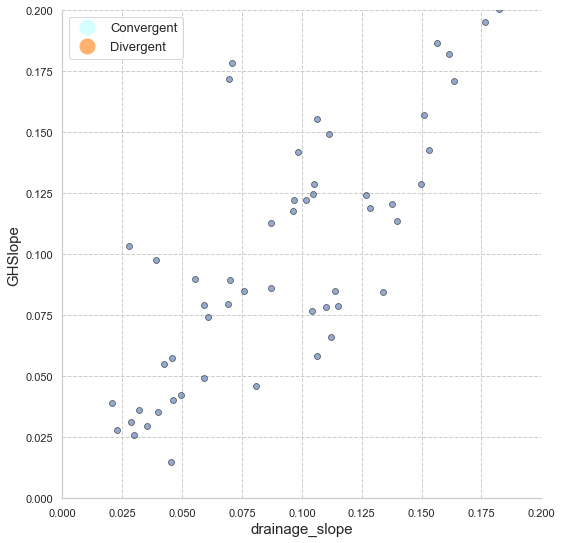

In [80]:
sns.set_style('whitegrid', {'grid.linestyle': '--'})
# baby blue, pale pink
data = slope_and_elevation_10m_df
colours = {0:'xkcd:very light blue', 1:'xkcd:pumpkin'}
x_axis = 'drainage_slope'
y_axis = 'GHSlope'

fig = sns.relplot(x=x_axis, y=y_axis,  palette = colours, 
                 data=data, alpha = 0.6,  edgecolor='xkcd:black', 
                   markers=['o', 'o'])

ax = fig.axes[0,0]
ax.set_xlim(0.0,0.2)
ax.set_ylim(0.0,0.2)
ax.set_xlabel(x_axis, fontsize = 20)
ax.set_ylabel(y_axis, fontsize = 20)
leg = fig._legend
plt.rcParams["axes.edgecolor"] = "0.15"


Div = Line2D([], [], color='xkcd:apricot', marker='o', linestyle='None',
                          markersize=15, label='Divergent')
Conv = Line2D([], [], color='xkcd:very light blue', marker='o', linestyle='None',
                          markersize=15, label='Convergent')

#ax.tick_params(axis='both', which='major', labelsize=15)
ax.set_xlabel(x_axis, fontsize = 15)
ax.set_ylabel((y_axis), fontsize = 15)

#ax.set(xscale="log")

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,fontsize='12')
plt.setp(ax.get_legend().get_title(), fontsize='12') # for legend title
plt.legend(handles=[Conv, Div],fontsize=13)
fig.fig.set_size_inches(8,8)

In [81]:
final_gully_head_nodes = np.isin(grid_nodes,final_gully_heads).astype('int64')

In [82]:
len(final_gully_heads)

133

# Locate gully edges.

# Check whether gully edges meet same criteria as gully head earlier (can be modified), then locate edges next to 5m_downstream_points and gh.

In [83]:
start_time = timeit.default_timer()

line_length = 20
list_of_final_gully_heads = []
gully_edges_dict = {}
for key, value in final_gh_and_5m_downstream.items():
    cp = key
    print('cp: ',cp)
    gh = value
    print('gh: ', gh)
    gh_lat = np.where(grid_nodes == gh)[0][0]
    cp_lat = np.where(grid_nodes == cp)[0][0]
    gh_lon = np.where(grid_nodes == gh)[1][0]
    cp_lon = np.where(grid_nodes == cp)[1][0]

    lat_displacement = cp_lat - gh_lat
    print('lat: ', lat_displacement)
    lon_displacement = gh_lon - cp_lon
    print('lon: ', lon_displacement)

    # a^2 + b^2 = c^2
    gully_length = np.sqrt(lat_displacement**2 + lon_displacement**2)
    
    gully_angle = gullyUnknownAngle(lat_displacement, lon_displacement)   
    
    gully_and_cross_section = GullyOrientation(gully_angle, key, mg.shape)
    
    approx_angle = gully_and_cross_section.closest_angle
        
    cross_section_nodes = gully_and_cross_section.cross_section(line_length)
    
    result = np.where(grid_nodes == key)
    #################################################################################################
    # Find the index position (in the whole DEM) that corresponds to the current gully head point in the list.
    row_index = result[0][0];
    col_index = result[1][0];
    #################################################################################################
    # Create a subset based on above. Plus 1 to bottom abnd right so that the currenmmt gully ead node is always the 
    # central grid node of the subset.
    subset_row_top = int(row_index - line_length)
    subset_row_bot = int(row_index + line_length) + 1
    subset_col_left = int(col_index - line_length)
    subset_col_right = int(col_index + line_length) + 1
    #################################################################################################
    # Restrict the size of the subset in cases where it is on the edge of a DEM.
    subset_row_top_adjusted = max(subset_row_top, 0);
    subset_row_bot_adjusted = min(subset_row_bot, input_DEM.shape[0]);
    subset_col_left_adjusted = max(subset_col_left, 0);
    subset_col_right_adjusted = min(subset_col_right, input_DEM.shape[1]);
    #################################################################################################
    # Find the offset required by restricting the size of the subset around DEM edges.
    # This offset is needed to find the new location of the current gully head grid cell (no longer center of the subset).
    offset_row_top = int(np.sqrt((subset_row_top - subset_row_top_adjusted)**2)) * -1;
    offset_row_bot = int(np.sqrt((subset_row_bot - subset_row_bot_adjusted)**2));
    offset_col_left = int(np.sqrt((subset_col_left - subset_col_left_adjusted)**2)) * -1;
    offset_col_right = int(np.sqrt((subset_col_right - subset_col_right_adjusted)**2));
    #################################################################################################
    # Create subset around the current gully head grid node. 
    grid_nodes_subset_copy = np.copy(grid_nodes).astype('int32');
    grid_nodes_subset = grid_nodes_subset_copy[subset_row_top_adjusted:subset_row_bot_adjusted, 
                                 subset_col_left_adjusted:subset_col_right_adjusted]

    lat = grid_nodes_subset.shape[0]
    lon = grid_nodes_subset.shape[1]

    nodes_1d = np.squeeze(grid_nodes_subset.reshape(1, lat * lon))

    cross_section_subset_mask = np.isin(nodes_1d,cross_section_nodes).reshape(grid_nodes_subset.shape)
    cross_section_subset_image = cross_section_subset_mask.astype('int64')

    #################################################################################################
    # Take subsets of desired surface parameters for gulyl analysis (e.g. DFME, slope, curvature etc)
    #################################################################################################
    elevation_subset_copy = np.copy(input_DEM).astype('float32');
    cross_section_elevation = elevation_subset_copy[subset_row_top_adjusted:subset_row_bot_adjusted, 
                                 subset_col_left_adjusted:subset_col_right_adjusted]

    cross_section_elevation[~cross_section_subset_mask] = np.nan
    cross_section_elevation_1d = np.squeeze(cross_section_elevation.reshape(1, lat * lon))
    #################################################################################################
    dfme_subset_copy = np.copy(DFME).astype('float32');
    cross_section_dfme = dfme_subset_copy[subset_row_top_adjusted:subset_row_bot_adjusted, 
                                 subset_col_left_adjusted:subset_col_right_adjusted]

    cross_section_dfme[~cross_section_subset_mask] = np.nan
    cross_section_dfme_1d = np.squeeze(cross_section_dfme.reshape(1, lat * lon))
    #################################################################################################
    
    node_cross_section_dfme_dict = {}
    for A, B in zip(nodes_1d, cross_section_dfme_1d):
        node_cross_section_dfme_dict[A] = B
    
    node_cross_section_elevation_dict = {}
    for A, B in zip(nodes_1d, cross_section_elevation_1d):
        node_cross_section_elevation_dict[A] = B
        
    dfme_cross_section_unordered = { key:value for key, 
                                     value in node_cross_section_dfme_dict.items() if ~np.isnan(value) }

    elevation_cross_section_unordered = { key:value for key, 
                                         value in node_cross_section_elevation_dict.items() if ~np.isnan(value) }

    ds = [dfme_cross_section_unordered, elevation_cross_section_unordered]
    d = {}
    for k in dfme_cross_section_unordered.keys():
        d[k] = tuple(d[k] for d in ds)

    cross_section_parameters = pd.DataFrame.from_dict(d)

    cross_section_parameters.rename(index={0:'DFME', 1:'Elevation'}, inplace=True)

    cross_section_parameters_transpose = cross_section_parameters.T

    cross_section_parameters_transpose.insert(0, "Distance", 0)
    
    for j in range(0, (line_length * 2)+1):
        if j < line_length:
            cross_section_parameters_transpose.iloc[j,0] = -line_length + j
        else:
            cross_section_parameters_transpose.iloc[j,0] = j - line_length
        
    cross_section_parameters_transpose['Node'] = cross_section_parameters_transpose.index.values
    
    dir1, dir1_nodes, dir2, dir2_nodes = assignDirection(cross_section_parameters_transpose, 
                                                 gully_and_cross_section.closest_angle)
    
    dir1e, dir1_nodes, dir2e, dir2_nodes = assignDirectionElev(cross_section_parameters_transpose, 
                                             gully_and_cross_section.closest_angle)
    


    #outcome_d1, D1 = checkGullyEdges(dir1,step_s,comp_d,-0.2,-0.2)
    #outcome_d2, D2 = checkGullyEdges(dir2,step_s,comp_d,-0.2,-0.2)
    
    outcome_d1, D1 = checkGullyEdgesElev(dir1,dir1e, step_s,comp_d,dfme_threshold,gh_min_elev, gh_relief);
    outcome_d2, D2 = checkGullyEdgesElev(dir2, dir2e, step_s,comp_d,dfme_threshold,gh_min_elev, gh_relief);
    
    if outcome_d1 == 'yes' and outcome_d2 == 'yes':
        list_of_final_gully_heads.append(key)
        # Directions will depend on orientation so need two sets of schemes.
        if approx_angle == 180 or approx_angle == 225 or approx_angle == 270 or approx_angle == 315:
            
            points_next_to_head_d1 = pointsAlongGully(dir1_nodes[D1], approx_angle, 5, grid_nodes)
            points_next_to_head_d2 = pointsAlongGully(dir2_nodes[D2], approx_angle, 5, grid_nodes)
            
            print('d1 : ', dir1_nodes[D1], 'd2: ', dir2_nodes[D2], 'New points: ', 
                  points_next_to_head_d1, points_next_to_head_d2, 'angle: ', approx_angle)
            
            gully_edges_dict[key] = [dir1_nodes[D1], dir2_nodes[D2], points_next_to_head_d1, points_next_to_head_d2]
            
        else:
            points_next_to_head_d1 = pointsAlongGully(dir1_nodes[D1], approx_angle, 5, grid_nodes)
            points_next_to_head_d2 = pointsAlongGully(dir2_nodes[D2], approx_angle, 5, grid_nodes)
            
            print('d1 : ', dir1_nodes[D1], 'd2: ', dir2_nodes[D2], 'New points: ', 
                  points_next_to_head_d1, points_next_to_head_d2, 'angle: ', approx_angle)
            
            gully_edges_dict[key] = [dir2_nodes[D2],dir1_nodes[D1], points_next_to_head_d2, points_next_to_head_d1]
        
    else:
        print('no')

    
timeit.default_timer() - start_time

cp:  79713
gh:  81579
lat:  -1
lon:  -4
Quadrant = Q3 min angle 180 max angle 270
east-west gully
elevation difference:  0.879623413086
elevation difference:  1.15148925781
west_to_east gully
west_to_east gully
d1 :  72233 d2:  87193 New points:  72228 87188 angle:  270
cp:  116607
gh:  125955
lat:  -5
lon:  -2
Quadrant = Q3 min angle 180 max angle 270
north-south gully
elevation difference:  0.777633666992
elevation difference:  0.42790222168
elevation difference:  0.439224243164
elevation difference:  0.45002746582
elevation difference:  0.455932617188
elevation difference:  0.208786010742
elevation difference:  0.0171508789063
elevation difference:  -0.0341796875
elevation difference:  -0.0883941650391
elevation difference:  -0.113311767578
elevation difference:  -0.0986022949219
elevation difference:  -0.0230407714844
elevation difference:  0.0252685546875
elevation difference:  -0.00363159179688
elevation difference:  -0.00642395019531
no
cp:  143865
gh:  149471
lat:  -3
lon:  -4


elevation difference:  0.587463378906
elevation difference:  0.978897094727
southeast_to_northwest gully
southeast_to_northwest gully
d1 :  216306 d2:  231258 New points:  225657 240609 angle:  135
cp:  228096
gh:  239313
lat:  -6
lon:  -3
Quadrant = Q3 min angle 180 max angle 270
northeast-southwest gully
elevation difference:  0.484298706055
elevation difference:  1.45101928711
elevation difference:  1.51365661621
elevation difference:  1.34260559082
elevation difference:  1.00483703613
elevation difference:  0.832733154297
elevation difference:  0.470626831055
elevation difference:  0.422561645508
elevation difference:  0.350463867188
elevation difference:  0.212265014648
elevation difference:  0.241912841797
elevation difference:  0.132751464844
elevation difference:  0.157455444336
elevation difference:  0.124923706055
elevation difference:  0.148101806641
no
cp:  241628
gh:  230413
lat:  6
lon:  5
Quadrant = Q1 min angle 0 max angle 90
northeast-southwest gully
elevation differen

lat:  -5
lon:  -12
Quadrant = Q3 min angle 180 max angle 270
northeast-southwest gully
elevation difference:  0.935806274414
elevation difference:  0.953216552734
elevation difference:  0.972595214844
elevation difference:  0.885070800781
elevation difference:  0.724838256836
elevation difference:  0.568557739258
elevation difference:  0.440078735352
elevation difference:  0.377868652344
elevation difference:  0.325820922852
elevation difference:  0.282043457031
elevation difference:  0.209609985352
elevation difference:  0.112426757813
elevation difference:  0.0418701171875
elevation difference:  -0.0284423828125
elevation difference:  1.93963623047
elevation difference:  1.74269104004
elevation difference:  1.35595703125
elevation difference:  1.15783691406
elevation difference:  1.04711914063
elevation difference:  0.859909057617
elevation difference:  0.92692565918
elevation difference:  0.703659057617
elevation difference:  0.517150878906
elevation difference:  0.506072998047
elev

elevation difference:  0.722915649414
elevation difference:  0.471420288086
southeast_to_northwest gully
southeast_to_northwest gully
d1 :  380263 d2:  395215 New points:  389614 404566 angle:  135
cp:  389346
gh:  396826
lat:  -4
lon:  0
north-south gully
elevation difference:  0.707916259766
elevation difference:  1.02102661133
elevation difference:  1.12344360352
elevation difference:  1.18473815918
elevation difference:  1.11920166016
elevation difference:  1.09460449219
elevation difference:  1.09288024902
elevation difference:  1.18493652344
elevation difference:  1.1997833252
elevation difference:  1.17408752441
elevation difference:  1.21240234375
elevation difference:  1.09037780762
elevation difference:  1.068359375
elevation difference:  1.04747009277
elevation difference:  0.957748413086
elevation difference:  0.775573730469
elevation difference:  0.744873046875
elevation difference:  0.770492553711
elevation difference:  0.814117431641
elevation difference:  0.759078979492

elevation difference:  0.28857421875
elevation difference:  0.110595703125
elevation difference:  0.176147460938
elevation difference:  0.204330444336
elevation difference:  0.205718994141
elevation difference:  0.182266235352
elevation difference:  0.172149658203
elevation difference:  0.328231811523
elevation difference:  0.325759887695
elevation difference:  0.326965332031
elevation difference:  0.202072143555
elevation difference:  0.172470092773
elevation difference:  0.274520874023
elevation difference:  0.380920410156
elevation difference:  0.982315063477
elevation difference:  0.833755493164
elevation difference:  0.702255249023
elevation difference:  0.610153198242
elevation difference:  0.567428588867
elevation difference:  0.442779541016
elevation difference:  0.458572387695
elevation difference:  0.485198974609
elevation difference:  0.47883605957
elevation difference:  0.5048828125
elevation difference:  0.483093261719
elevation difference:  0.420135498047
elevation differ

elevation difference:  1.31666564941
elevation difference:  1.34605407715
elevation difference:  1.50685119629
elevation difference:  1.41635131836
elevation difference:  1.10600280762
elevation difference:  0.881774902344
elevation difference:  0.571166992188
elevation difference:  0.338195800781
elevation difference:  0.301666259766
elevation difference:  0.337539672852
elevation difference:  0.360366821289
elevation difference:  0.298553466797
elevation difference:  0.261260986328
elevation difference:  0.237686157227
elevation difference:  1.00294494629
elevation difference:  0.982604980469
no
cp:  985379
gh:  989115
lat:  -2
lon:  -4
Quadrant = Q3 min angle 180 max angle 270
northeast-southwest gully
elevation difference:  1.48959350586
elevation difference:  -1.15165710449
elevation difference:  -1.20133972168
elevation difference:  -0.939895629883
elevation difference:  -0.118667602539
elevation difference:  0.380630493164
elevation difference:  0.82991027832
elevation differenc

elevation difference:  0.465744018555
elevation difference:  0.682113647461
west_to_east gully
west_to_east gully
d1 :  1526065 d2:  1541025 New points:  1526060 1541020 angle:  270
cp:  1576508
gh:  1578374
lat:  -1
lon:  -4
Quadrant = Q3 min angle 180 max angle 270
east-west gully
elevation difference:  0.171875
elevation difference:  -0.247497558594
elevation difference:  -0.462371826172
elevation difference:  -0.610931396484
elevation difference:  -0.703735351563
elevation difference:  -0.652648925781
elevation difference:  -0.561447143555
elevation difference:  -0.503784179688
elevation difference:  -0.436233520508
elevation difference:  -0.477142333984
elevation difference:  -0.398239135742
elevation difference:  -0.389129638672
elevation difference:  -0.411956787109
elevation difference:  -0.322967529297
elevation difference:  0.720672607422
no
cp:  1587711
gh:  1595186
lat:  -4
lon:  -5
Quadrant = Q3 min angle 180 max angle 270
northeast-southwest gully
elevation difference:  0

elevation difference:  1.24052429199
elevation difference:  1.04333496094
elevation difference:  1.01344299316
elevation difference:  1.04289245605
elevation difference:  1.09881591797
elevation difference:  0.95378112793
elevation difference:  0.896087646484
elevation difference:  0.83251953125
elevation difference:  0.538665771484
elevation difference:  0.476425170898
elevation difference:  0.420974731445
elevation difference:  0.335052490234
elevation difference:  0.34700012207
elevation difference:  0.498458862305
elevation difference:  0.830932617188
no
cp:  2430969
gh:  2438446
lat:  -4
lon:  -3
Quadrant = Q3 min angle 180 max angle 270
northeast-southwest gully
elevation difference:  0.426498413086
elevation difference:  0.808212280273
elevation difference:  1.31962585449
elevation difference:  1.46241760254
elevation difference:  1.92417907715
elevation difference:  1.88238525391
elevation difference:  1.86259460449
elevation difference:  2.13938903809
elevation difference:  1.

elevation difference:  1.05360412598
elevation difference:  1.07736206055
elevation difference:  0.917816162109
elevation difference:  0.761032104492
elevation difference:  0.429016113281
elevation difference:  0.461730957031
elevation difference:  0.885070800781
elevation difference:  1.34498596191
elevation difference:  1.66481018066
elevation difference:  1.8307800293
elevation difference:  1.61558532715
elevation difference:  1.61308288574
elevation difference:  1.37484741211
elevation difference:  1.19633483887
elevation difference:  2.37571716309
elevation difference:  2.66667175293
elevation difference:  2.78239440918
elevation difference:  2.95903015137
elevation difference:  2.86183166504
elevation difference:  2.78771972656
elevation difference:  2.34880065918
elevation difference:  2.16569519043
elevation difference:  1.87153625488
elevation difference:  1.87280273438
elevation difference:  1.96022033691
elevation difference:  1.76554870605
elevation difference:  1.937301635

elevation difference:  1.33729553223
elevation difference:  2.35369873047
elevation difference:  2.55406188965
elevation difference:  2.01670837402
elevation difference:  1.97285461426
elevation difference:  2.08746337891
elevation difference:  1.76622009277
elevation difference:  1.77626037598
elevation difference:  1.86985778809
elevation difference:  1.95013427734
elevation difference:  2.3402557373
elevation difference:  2.65896606445
elevation difference:  2.81922912598
elevation difference:  2.75102233887
elevation difference:  2.84129333496
no
cp:  2709528
gh:  2718878
lat:  -5
lon:  0
north-south gully
elevation difference:  0.540893554688
elevation difference:  0.87028503418
elevation difference:  0.792617797852
elevation difference:  0.641448974609
elevation difference:  0.515960693359
elevation difference:  0.397171020508
elevation difference:  0.285003662109
elevation difference:  0.162506103516
elevation difference:  0.0706481933594
elevation difference:  -0.0896911621094


elevation difference:  0.522689819336
elevation difference:  1.40017700195
elevation difference:  1.94964599609
elevation difference:  2.35037231445
elevation difference:  2.56962585449
elevation difference:  2.71961975098
elevation difference:  2.91952514648
elevation difference:  2.99270629883
elevation difference:  2.73020935059
elevation difference:  2.59390258789
elevation difference:  2.26838684082
elevation difference:  1.72467041016
elevation difference:  1.53172302246
elevation difference:  1.27958679199
elevation difference:  3.0249786377
elevation difference:  3.05155944824
elevation difference:  3.37637329102
elevation difference:  3.20643615723
elevation difference:  3.19966125488
elevation difference:  2.75276184082
elevation difference:  2.27925109863
elevation difference:  2.52499389648
elevation difference:  2.1515045166
elevation difference:  1.87565612793
elevation difference:  1.94650268555
elevation difference:  1.23625183105
elevation difference:  1.19696044922
el

elevation difference:  0.974624633789
elevation difference:  0.591918945313
elevation difference:  0.471939086914
elevation difference:  0.344421386719
elevation difference:  0.361282348633
elevation difference:  0.421173095703
elevation difference:  0.636566162109
elevation difference:  0.597442626953
elevation difference:  0.381576538086
elevation difference:  0.239028930664
elevation difference:  -0.0956573486328
elevation difference:  -0.148223876953
elevation difference:  -0.245056152344
elevation difference:  -0.237899780273
elevation difference:  0.167602539063
elevation difference:  -0.0436859130859
elevation difference:  -0.0436859130859
elevation difference:  -0.0428314208984
elevation difference:  0.0897827148438
elevation difference:  0.0319213867188
elevation difference:  0.104690551758
elevation difference:  0.0310668945313
elevation difference:  -0.0872344970703
elevation difference:  -0.125305175781
elevation difference:  -0.206878662109
elevation difference:  -0.148284

elevation difference:  0.869903564453
elevation difference:  0.934814453125
elevation difference:  0.803558349609
elevation difference:  0.522857666016
elevation difference:  0.221893310547
elevation difference:  -0.00759887695313
elevation difference:  -0.119110107422
elevation difference:  -0.0534973144531
elevation difference:  0.214874267578
elevation difference:  0.333251953125
elevation difference:  0.590087890625
elevation difference:  0.808807373047
elevation difference:  0.920227050781
elevation difference:  0.825042724609
elevation difference:  1.03775024414
elevation difference:  1.05676269531
elevation difference:  1.0192565918
elevation difference:  0.995513916016
elevation difference:  1.05480957031
elevation difference:  0.910095214844
elevation difference:  0.935852050781
elevation difference:  0.846923828125
elevation difference:  0.937438964844
elevation difference:  1.01864624023
elevation difference:  1.10025024414
elevation difference:  1.08651733398
elevation diff

lat:  -5
lon:  -3
Quadrant = Q3 min angle 180 max angle 270
northeast-southwest gully
elevation difference:  1.13653564453
elevation difference:  1.36911010742
elevation difference:  0.879913330078
elevation difference:  0.849060058594
elevation difference:  0.72900390625
elevation difference:  0.674407958984
elevation difference:  0.982666015625
elevation difference:  1.20849609375
elevation difference:  1.29827880859
elevation difference:  1.48132324219
elevation difference:  1.41989135742
elevation difference:  1.39663696289
elevation difference:  1.67428588867
elevation difference:  1.72033691406
elevation difference:  1.91012573242
elevation difference:  2.23889160156
elevation difference:  1.42456054688
no
cp:  3204372
gh:  3213719
lat:  -5
lon:  -3
Quadrant = Q3 min angle 180 max angle 270
northeast-southwest gully
elevation difference:  2.07888793945
elevation difference:  2.87753295898
elevation difference:  3.26086425781
elevation difference:  3.29409790039
elevation differen

elevation difference:  0.368896484375
elevation difference:  0.893829345703
elevation difference:  0.921234130859
elevation difference:  1.1501159668
elevation difference:  1.16656494141
elevation difference:  1.18676757813
elevation difference:  1.14416503906
elevation difference:  1.12338256836
elevation difference:  1.12176513672
elevation difference:  1.12564086914
elevation difference:  1.10726928711
elevation difference:  1.01934814453
elevation difference:  1.05905151367
elevation difference:  1.07473754883
elevation difference:  1.15472412109
no
cp:  3248388
gh:  3248401
lat:  0
lon:  13
east-west gully
elevation difference:  0.136535644531
elevation difference:  -0.00054931640625
elevation difference:  -0.037353515625
elevation difference:  -0.0608520507813
elevation difference:  -0.0582275390625
elevation difference:  -0.0863189697266
elevation difference:  -0.172393798828
elevation difference:  -0.179504394531
elevation difference:  -0.259735107422
elevation difference:  -0.

47.03938769999968

# Check the list of final gully heads.

In [84]:
final_5m_downstream_nodes = np.isin(grid_nodes,list_of_final_gully_heads).astype('int64')
len(list_of_final_gully_heads)

13

In [85]:
gully_edges_df = pd.DataFrame.from_dict(gully_edges_dict).T
gully_edges_df.columns = ['LeftCP', 'RightCP', 'LeftGH', 'RightGH']
gully_edges_df['5m'] = gully_edges_df.index
initial_cp_5m_final_edges_df = initial_cp_5m_final_df.merge(gully_edges_df, on="5m", how = 'inner')

## Compare drainage area of final gh to cp and initial gh and throw out any with large differences.

In [86]:
final_gh_da = initial_cp_5m_final_edges_df['final'].values.tolist() 

In [87]:
fgh_da_dict = {}

for i in final_gh_da:
    result = np.where(grid_nodes == i);
    #################################################################################################
    # Find the index position (in the whole DEM) that corresponds to the current gully head point in the list.
    row_index = result[0][0];
    col_index = result[1][0];
    fgh_da = catchment_area[row_index,col_index];
    fgh_da_dict[i] = np.round(fgh_da, 5);
    
fgh_da_df = pd.DataFrame.from_dict(fgh_da_dict, orient='index')
fgh_da_df['final'] = fgh_da_df.index
initial_cp_5m_final_da_df = initial_cp_5m_final_edges_df.merge(fgh_da_df, on="final", how = 'inner')
initial_cp_5m_final_da_df.rename(columns={0: 'fgh_area'}, inplace=True)


In [88]:
final_gh_copy = initial_cp_5m_final_da_df.copy()

In [89]:
drainage_ratio_threshold = 5

In [90]:
def drainageDifference(drainage_cp, drainage_fgh):
    return drainage_cp/drainage_fgh
final_gh_copy['final_drainage_ratio'] = final_gh_copy.apply(lambda x: drainageDifference(x['area'], x['fgh_area']), axis=1)

In [91]:
final_gh_copy.drop(final_gh_copy[final_gh_copy['final_drainage_ratio'] > drainage_ratio_threshold].index, inplace = True) 

## Combine points around head with GH slope estimate.

In [92]:
gully_topographic_data = final_gh_copy.merge(slope_and_elevation_10m_df, on="final", how = 'inner')

In [93]:
gully_topographic_data['GHSlopeMean'] = gully_topographic_data[['GHSlope', 'GHSlope10']].mean(axis=1)

## Extract each point seperately.

In [94]:
left_edge_points = gully_edges_df['LeftCP'].values
right_edge_points = gully_edges_df['RightCP'].values
left_head_points = gully_edges_df['LeftGH'].values
right_head_points = gully_edges_df['RightGH'].values
gully_left_edges = np.isin(grid_nodes,left_edge_points).astype('int64')
gully_right_edges = np.isin(grid_nodes,right_edge_points).astype('int64')
gully_left_head = np.isin(grid_nodes,left_head_points).astype('int64')
gully_right_head = np.isin(grid_nodes,right_head_points).astype('int64')

left_cp_slope = getSlopeValues(left_edge_points, slope, grid_nodes)
right_cp_slope = getSlopeValues(right_edge_points, slope, grid_nodes)
left_head_slope = getSlopeValues(left_head_points, slope, grid_nodes)
right_head_slope = getSlopeValues(right_head_points, slope, grid_nodes)

left_cp_slope_df = pd.DataFrame.from_dict(left_cp_slope, orient='index')
left_cp_slope_df['LeftCP'] = left_cp_slope_df.index
all_data_plus_left_cp = gully_topographic_data.merge(left_cp_slope_df, on="LeftCP", how = 'inner')
all_data_plus_left_cp.rename(columns={0: 'LeftCPslope'}, inplace=True)

right_cp_slope_df = pd.DataFrame.from_dict(right_cp_slope, orient='index')
right_cp_slope_df['RightCP'] = right_cp_slope_df.index
all_data_plus_right_cp = all_data_plus_left_cp.merge(right_cp_slope_df, on="RightCP", how = 'inner')
all_data_plus_right_cp.rename(columns={0: 'RightCPslope'}, inplace=True)

left_head_slope_df = pd.DataFrame.from_dict(left_head_slope, orient='index')
left_head_slope_df['LeftGH'] = left_head_slope_df.index
all_data_plus_left_gh = all_data_plus_right_cp.merge(left_head_slope_df, on="LeftGH", how = 'inner')
all_data_plus_left_gh.rename(columns={0: 'LeftGHslope'}, inplace=True)

right_head_slope_df = pd.DataFrame.from_dict(right_head_slope, orient='index')
right_head_slope_df['RightGH'] = right_head_slope_df.index
all_data_plus_right_gh = all_data_plus_left_gh.merge(right_head_slope_df, on="RightGH", how = 'inner')
all_data_plus_right_gh.rename(columns={0: 'RightGHslope'}, inplace=True)

all_data_plus_right_gh['median'] = all_data_plus_right_gh[['LeftCPslope', 'RightCPslope','LeftGHslope','RightGHslope','GHSlope']].median(axis=1)
all_data_plus_right_gh['std'] = all_data_plus_right_gh[['LeftCPslope', 'RightCPslope','LeftGHslope','RightGHslope','GHSlope']].std(axis=1)



In [95]:
gully_head_node_array = np.isin(grid_nodes,all_data_plus_right_gh['final'].values).astype('int64')

In [96]:
df_filtered = all_data_plus_right_gh[all_data_plus_right_gh['std'] < 0.05] 
df_filtered_new = df_filtered.reset_index()

In [97]:
data_to_plot = all_data_plus_right_gh

In [98]:
slope_to_use = 'drainage_slope'

In [99]:
data_to_plot['log_area'] = np.log10(data_to_plot['area'])
data_to_plot['log_slope'] = np.log10(data_to_plot[slope_to_use])

In [100]:
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

No handles with labels found to put in legend.


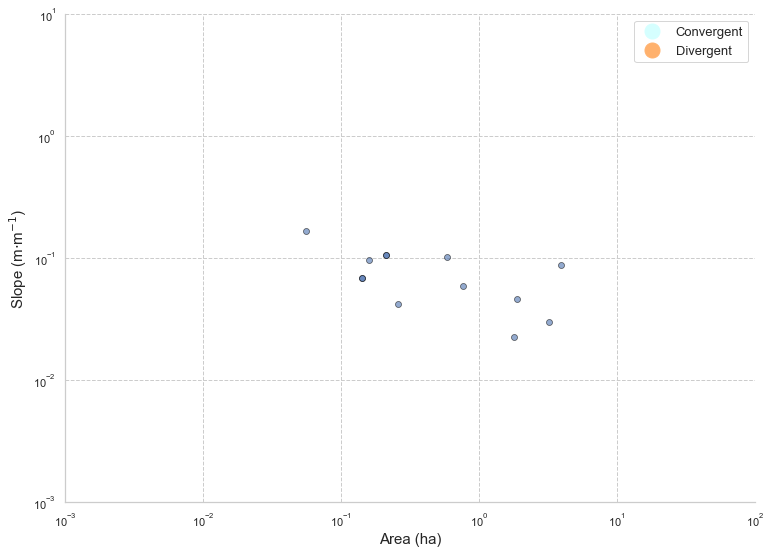

In [101]:
sns.set_style('whitegrid', {'grid.linestyle': '--'})
# baby blue, pale pink
data = data_to_plot
colours = {0:'xkcd:very light blue', 1:'xkcd:pumpkin'}
x_axis = 'area'
y_axis = slope_to_use

fig = sns.relplot(x=x_axis, y=y_axis,  palette = colours, 
                 data=data, alpha = 0.6,  edgecolor='xkcd:black', 
                   markers=['o', 'o'])

ax = fig.axes[0,0]
ax.set_xlim(0.001,100)
ax.set_ylim(0.001,10)
ax.set_xlabel(x_axis, fontsize = 20)
ax.set_ylabel(y_axis, fontsize = 20)
leg = fig._legend
plt.rcParams["axes.edgecolor"] = "0.15"


Div = Line2D([], [], color='xkcd:apricot', marker='o', linestyle='None',
                          markersize=15, label='Divergent')
Conv = Line2D([], [], color='xkcd:very light blue', marker='o', linestyle='None',
                          markersize=15, label='Convergent')

#ax.tick_params(axis='both', which='major', labelsize=15)
ax.set_xlabel('Area (ha)', fontsize = 15)
ax.set_ylabel(('Slope (m$\cdot$m$^{-1}$)'), fontsize = 15)
ax.set(xscale="log", yscale="log")
#ax.set(xscale="log")

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,fontsize='12')
plt.setp(ax.get_legend().get_title(), fontsize='12') # for legend title
plt.legend(handles=[Conv, Div],fontsize=13)
fig.fig.set_size_inches(12,8)

In [99]:
untransformed_b, untransformed_k, exponent_b, scalar_k, data_used_by_model = thresholdLineFixedB(data_to_plot, 'area', slope_to_use, 0.4)

In [100]:
data_used_by_model = thresholdLineOnlyCooks(data_to_plot, 'area', slope_to_use)

In [101]:
data_used_by_model2 = thresholdLineOnlyCooks(data_used_by_model, 'area', slope_to_use)

No handles with labels found to put in legend.


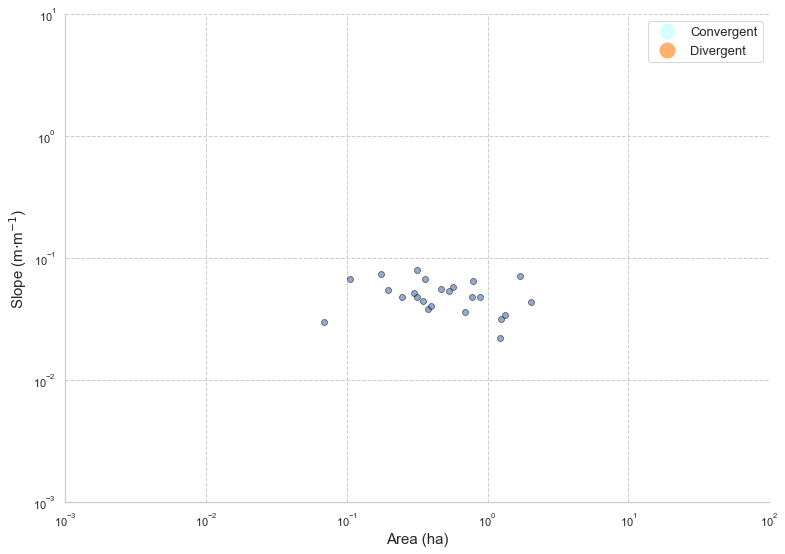

In [102]:
sns.set_style('whitegrid', {'grid.linestyle': '--'})
# baby blue, pale pink
data = data_used_by_model
colours = {0:'xkcd:very light blue', 1:'xkcd:pumpkin'}
x_axis = 'area'
y_axis = slope_to_use

fig = sns.relplot(x=x_axis, y=y_axis,  palette = colours, 
                 data=data, alpha = 0.6,  edgecolor='xkcd:black', 
                   markers=['o', 'o'])

ax = fig.axes[0,0]
ax.set_xlim(0.001,100)
ax.set_ylim(0.001,10)
ax.set_xlabel(x_axis, fontsize = 20)
ax.set_ylabel(y_axis, fontsize = 20)
leg = fig._legend
plt.rcParams["axes.edgecolor"] = "0.15"


Div = Line2D([], [], color='xkcd:apricot', marker='o', linestyle='None',
                          markersize=15, label='Divergent')
Conv = Line2D([], [], color='xkcd:very light blue', marker='o', linestyle='None',
                          markersize=15, label='Convergent')

#ax.tick_params(axis='both', which='major', labelsize=15)
ax.set_xlabel('Area (ha)', fontsize = 15)
ax.set_ylabel(('Slope (m$\cdot$m$^{-1}$)'), fontsize = 15)
ax.set(xscale="log", yscale="log")
#ax.set(xscale="log")

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,fontsize='12')
plt.setp(ax.get_legend().get_title(), fontsize='12') # for legend title
plt.legend(handles=[Conv, Div],fontsize=13)
fig.fig.set_size_inches(12,8)

No handles with labels found to put in legend.


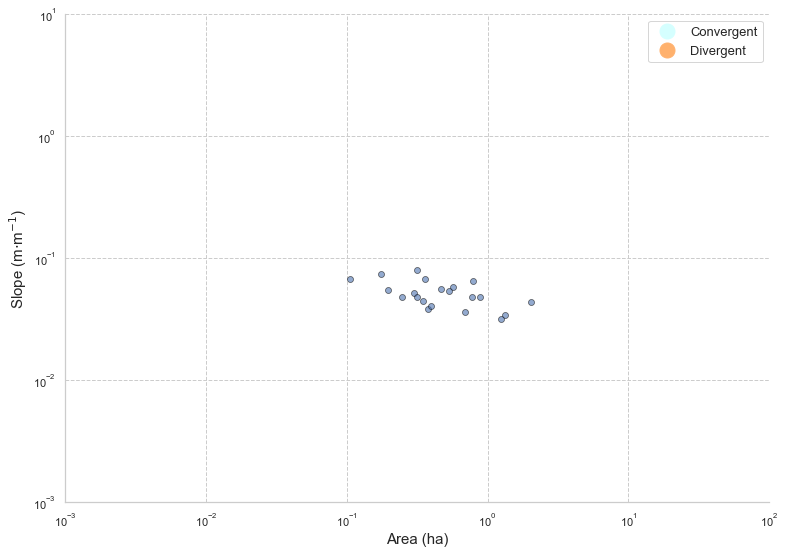

In [103]:
sns.set_style('whitegrid', {'grid.linestyle': '--'})
# baby blue, pale pink
data = data_used_by_model2
colours = {0:'xkcd:very light blue', 1:'xkcd:pumpkin'}
x_axis = 'area'
y_axis = slope_to_use

fig = sns.relplot(x=x_axis, y=y_axis,  palette = colours, 
                 data=data, alpha = 0.6,  edgecolor='xkcd:black', 
                   markers=['o', 'o'])

ax = fig.axes[0,0]
ax.set_xlim(0.001,100)
ax.set_ylim(0.001,10)
ax.set_xlabel(x_axis, fontsize = 20)
ax.set_ylabel(y_axis, fontsize = 20)
leg = fig._legend
plt.rcParams["axes.edgecolor"] = "0.15"


Div = Line2D([], [], color='xkcd:apricot', marker='o', linestyle='None',
                          markersize=15, label='Divergent')
Conv = Line2D([], [], color='xkcd:very light blue', marker='o', linestyle='None',
                          markersize=15, label='Convergent')

#ax.tick_params(axis='both', which='major', labelsize=15)
ax.set_xlabel('Area (ha)', fontsize = 15)
ax.set_ylabel(('Slope (m$\cdot$m$^{-1}$)'), fontsize = 15)
ax.set(xscale="log", yscale="log")
#ax.set(xscale="log")

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,fontsize='12')
plt.setp(ax.get_legend().get_title(), fontsize='12') # for legend title
plt.legend(handles=[Conv, Div],fontsize=13)
fig.fig.set_size_inches(12,8)

In [104]:
print('b: ', exponent_b)
print('k: ', scalar_k)

b:  0.211694543889
k:  0.0338969292285


In [105]:
orthogonal_regression_dataset = data_used_by_model2

In [106]:
# Initiate some data, giving some randomness using random.random().
x = orthogonal_regression_dataset.loc[:,'log_area'].values
y = orthogonal_regression_dataset.loc[:,'log_slope'].values

# Define a function (quadratic in our case) to fit the data with.
def linear_func(p, x):
    m, c = p
    return m*x + c
   
# Create a model for fitting.
linear_model = Model(linear_func)

# Create a RealData object using our initiated data from above.
data = RealData(x, y)

# Set up ODR with the model and data.
odr = ODR(data, linear_model, beta0=[-0.4, -1])

# Run the regression.
out = odr.run()

# Use the in-built pprint method to give us results.
out.pprint()

Beta: [-0.21849526 -1.37210407]
Beta Std Error: [ 0.06619244  0.03009805]
Beta Covariance: [[ 0.53220646  0.17891207]
 [ 0.17891207  0.11003734]]
Residual Variance: 0.00823259392246474
Inverse Condition #: 0.26760462422105097
Reason(s) for Halting:
  Sum of squares convergence


In [107]:
print('b: ', out.beta[0] *-1)
print('k: ', 10**out.beta[1])

b:  0.218495255038
k:  0.0424517824192


In [108]:
b_orth = out.beta[0] 
k_orth = out.beta[1]

In [109]:
k_adjustment_dataset = data_to_plot

In [110]:
target_number_of_points_above_line = np.ceil(len(k_adjustment_dataset)*0.8).astype(int)
adjustment = 0
for u in range(0,100):
    above_model_line = []
    for j in k_adjustment_dataset.index:
        measured_slope = k_adjustment_dataset['log_slope'].loc[j]
        adjusted_intercept = k_orth - adjustment
        model_slope = b_orth * k_adjustment_dataset['log_area'].loc[j] + adjusted_intercept
        if  measured_slope > model_slope:
            above_model_line.append(j)                
        else:
            pass
    if len(above_model_line) >= target_number_of_points_above_line:
        break
    else:
        adjustment += 0.01
                

#corrected_set = regression_dataset.drop(above_model_line, axis='index')


# Generate graph

In [111]:
exponent_b_to_use = b_orth*-1
scalar_k_to_use = 10**adjusted_intercept

In [112]:
graph_data = data_to_plot

In [113]:
model_parameter_k = scalar_k_to_use
model_parameter_b = exponent_b_to_use

In [114]:
generate_area_values = np.arange(0.01, 10, 0.0001)
model_slope = model_parameter_k * (generate_area_values**-model_parameter_b )
df_model_area = pd.DataFrame(generate_area_values)
df_model_area.rename(columns={0: 'area'}, inplace=True)
graph_data['DC'] = 1
reshaped_model_slope = model_slope.reshape(-1,1)
df_model_slope = pd.DataFrame(reshaped_model_slope)
df_model_slope.rename(columns={0: slope_to_use}, inplace=True)
df_model = pd.concat([df_model_slope, df_model_area], axis=1, sort=False)
df_model['DC'] = 3
graph_data['Size'] = 500
df_model['Size'] = 1

df_all_1 = df_model.append(graph_data)

No handles with labels found to put in legend.


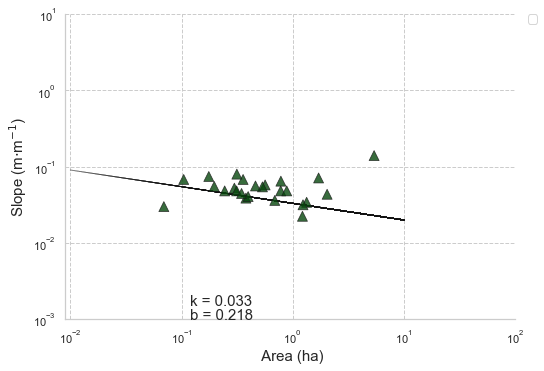

In [115]:
sns.set_style('whitegrid', {'grid.linestyle': '--'})
data = df_all_1
colours = {1:'xkcd:forest green', 3:'xkcd:black', 4:'xkcd:forest green'}
x_axis = 'area'
#x_axis_label = x_axis + ' Area (ha)'
x_axis_label = ' Area (ha)'
y_axis = slope_to_use
fig = sns.relplot(x=x_axis, y=y_axis,  palette = colours, hue = 'DC', 
                 data=data, alpha = 0.8, legend = False, edgecolor="k", 
                  style = 'DC', size = 'Size', sizes = (0.1,100), markers =['^', '.', '.'])

ax = fig.axes[0,0]

ax.set_xlabel(x_axis, fontsize = 20)
ax.set_ylabel(y_axis, fontsize = 20)

fig.set(xlim = (0.009, 100))
fig.set(ylim = (0.001, 10))

leg = fig._legend
plt.rcParams["axes.edgecolor"] = "0.15"

#g1 = Line2D([], [], color='xkcd:orange', marker='s', linestyle='None',
#                          markersize=15, label='Gully head 1 (divergent)')

rs = Line2D([], [], color='xkcd:merlot', marker='^', linestyle='None',
                          markersize=15, label='Random sample (convergent)')

#g2 = Line2D([], [], color='xkcd:scarlet', marker='o', linestyle='None',
#                          markersize=15, label='Gully head 2 (divergent)')

#ax.tick_params(axis='both', which='major', labelsize=15)
ax.set_xlabel(x_axis_label, fontsize = 15)
ax.set_ylabel(('Slope (m$\cdot$m$^{-1}$)'), fontsize = 15)

plt.legend(bbox_to_anchor=(1.05, 1),  borderaxespad=0.,fontsize='12')
plt.setp(ax.get_legend().get_title(), fontsize='12') # for legend title
#plt.legend(handles=[rs, g1, g2],fontsize=13, loc=3)
#plt.legend(handles=[rs],fontsize=13, loc=3)

ax.text(0.12, 0.0015,'k = ' + str(np.round(model_parameter_k, 3)), fontsize=15) 
ax.text(0.12, 0.001,'b = ' + str(np.round(model_parameter_b, 3)), fontsize=15)

ax.set_xscale('log')
ax.set_yscale('log')
fig.fig.set_size_inches(8,5)

In [ ]:
all_data_plus_right_gh

In [ ]:
#all_data_plus_right_gh.to_csv('kf_13.csv')

In [116]:
cp_node_array = np.isin(grid_nodes,all_data_plus_right_gh['cp'].values).astype('int64')

In [117]:
initial_gh_node_array = np.isin(grid_nodes,all_data_plus_right_gh['initial'].values).astype('int64')

In [118]:
downstream_5m_node_array = np.isin(grid_nodes,all_data_plus_right_gh['5m'].values).astype('int64')

In [102]:
final_node_array = np.isin(grid_nodes,all_data_plus_right_gh['final'].values).astype('int64')

In [103]:
def np_array_to_Geotiff(newfile, original_tiff, np_array, dtype):
    
    cols = np_array.shape[1]
    rows = np_array.shape[0]
    originX, pixelWidth, b, originY, d, pixelHeight = original_tiff.GetGeoTransform() 
    driver = gdal.GetDriverByName('GTiff')
    GDT_dtype = gdal.GDT_Unknown
    if dtype == "Float64": 
        GDT_dtype = gdal.GDT_Float64
    elif dtype == "Float32":
        GDT_dtype = gdal.GDT_Float32
    else:
        print("Not supported data type.")
    
    if np_array.ndim == 2:
        band_num = 1
    else:
        band_num = np_array.shape[2]

    outRaster = driver.Create(newfile, cols, rows, band_num, GDT_dtype)
    outRaster.SetGeoTransform((originX, pixelWidth, 0, originY, 0, pixelHeight))
    
    # Loop over all bands.
    for b in range(band_num):
        outband = outRaster.GetRasterBand(b + 1)
    
        # Read in the band's data into the third dimension of our array
        if band_num == 1:
            outband.WriteArray(np_array)
        else:
            outband.WriteArray(np_array[:,:,b])

    # setteing srs from input tif file.
    prj=original_tiff.GetProjection()
    outRasterSRS = osr.SpatialReference(wkt=prj)
    outRaster.SetProjection(outRasterSRS.ExportToWkt())
    outband.FlushCache()
    outRaster = None
    
    return outRaster

In [105]:
np_array_to_Geotiff('testfgh_ra3_b.tif', input_geotiff, final_node_array, catchment_area.dtype)#np_array_to_Geotiff('bogie_ghs.tif', input_geotiff, gully_head_node_array, catchment_area.dtype)

C:\Users\sjwal\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  


In [ ]:
np.sum(cp_node_array)

In [ ]:
list_of_exponents = []
list_of_scalars = []
for r in range(0, 10):
    if r == 0:
        exponent_b, scalar_k, data_used_by_model = thresholdLine(data_to_plot, 'area', slope_to_use)
        list_of_exponents.append(exponent_b)
        list_of_scalars.append(scalar_k)
    else:
        if len(data_used_by_model) > 30:
            exponent_b, scalar_k, data_used_by_model = thresholdLine(data_used_by_model, 'area', slope_to_use)
            list_of_exponents.append(exponent_b)
            list_of_scalars.append(scalar_k)
        else:
            break
        
exponent_to_use = max(list_of_exponents)
scalar_to_use = min(list_of_scalars)